# 🎙️ Voice-Based Stress Detection Using MFCC + Time-Series Features
### RAVDESS Dataset | Full Pipeline: Preprocessing → Feature Extraction → ML Classification

**Dataset:** RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song)  
**Goal:** Detect stress/emotional arousal from speech using signal processing + ML  
**Labels:** `calm/neutral` → Normal | `fearful/angry/disgusted` → Stressed

## 📦 Cell 1 — Install & Import All Dependencies

In [1]:
import subprocess, sys

for pkg in ["kagglehub", "librosa", "soundfile", "scikit-learn", "seaborn", "matplotlib", "numpy", "pandas", "tqdm"]:
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "--quiet"])

import os, glob, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import librosa
import librosa.display
from tqdm import tqdm
from IPython.display import Audio, display

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

warnings.filterwarnings('ignore')
np.random.seed(42)
random.seed(42)

plt.rcParams.update({
    'figure.dpi': 120, 'font.size': 11, 'axes.titlesize': 13, 'axes.labelsize': 11,
    'figure.facecolor': '#0d1117', 'axes.facecolor': '#161b22', 'axes.edgecolor': '#30363d',
    'text.color': 'white', 'axes.labelcolor': 'white', 'xtick.color': 'white',
    'ytick.color': 'white', 'legend.facecolor': '#21262d', 'legend.edgecolor': '#30363d',
})

print('All libraries imported successfully!')
print(f'  librosa  : {librosa.__version__}')
print(f'  numpy    : {np.__version__}')
print(f'  sklearn  : {__import__("sklearn").__version__}')

All libraries imported successfully!
  librosa  : 0.11.0
  numpy    : 2.0.2
  sklearn  : 1.6.1


## 📥 Cell 2 — Download RAVDESS Dataset via KaggleHub

In [2]:
import kagglehub

path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("Path to dataset files:", path)

all_wav_files = glob.glob(os.path.join(path, '**', '*.wav'), recursive=True)
print(f"Total .wav files found: {len(all_wav_files)}")
print("\nSample file paths:")
for f in all_wav_files[:5]:
    print(' ', f)

Using Colab cache for faster access to the 'ravdess-emotional-speech-audio' dataset.
Path to dataset files: /kaggle/input/ravdess-emotional-speech-audio
Total .wav files found: 2880

Sample file paths:
  /kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-08-01-01-01-02.wav
  /kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav
  /kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-07-02-01-02-02.wav
  /kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-07-01-01-02-02.wav
  /kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-02-01-02.wav


## 🏷️ Cell 3 — RAVDESS Emotion Label Parsing

**RAVDESS Filename Format:** `03-01-{emotion}-{intensity}-{statement}-{repetition}-{actor}.wav`  
Emotion codes: 01=neutral, 02=calm, 03=happy, 04=sad, 05=angry, 06=fearful, 07=disgust, 08=surprised

In [3]:
EMOTION_MAP = {
    '01': 'neutral', '02': 'calm',   '03': 'happy',    '04': 'sad',
    '05': 'angry',   '06': 'fearful','07': 'disgust',  '08': 'surprised'
}
STRESS_MAP = {
    'neutral': 'normal',  'calm': 'normal',    'happy': 'normal',   'sad': 'normal',
    'angry': 'stressed',  'fearful': 'stressed','disgust': 'stressed','surprised': 'stressed'
}

def parse_ravdess_label(filepath):
    fname = os.path.basename(filepath)
    parts = fname.replace('.wav', '').split('-')
    emotion_code = parts[2] if len(parts) >= 3 else '01'
    emotion = EMOTION_MAP.get(emotion_code, 'unknown')
    stress  = STRESS_MAP.get(emotion, 'normal')
    return emotion, stress

records = []
for fpath in all_wav_files:
    emotion, stress = parse_ravdess_label(fpath)
    records.append({'filepath': fpath, 'emotion': emotion, 'stress_label': stress})

df_meta = pd.DataFrame(records)
print('Dataset Metadata (first 10 rows):')
print(df_meta.head(10).to_string(index=False))
print(f"\nTotal samples : {len(df_meta)}")
print("\nEmotion distribution:")
print(df_meta['emotion'].value_counts().to_string())
print("\nStress label distribution:")
print(df_meta['stress_label'].value_counts().to_string())

Dataset Metadata (first 10 rows):
                                                                      filepath   emotion stress_label
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-08-01-01-01-02.wav surprised     stressed
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav   neutral       normal
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-07-02-01-02-02.wav   disgust     stressed
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-07-01-01-02-02.wav   disgust     stressed
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-02-01-02.wav   neutral       normal
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-02-02-01-02.wav   fearful     stressed
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-04-01-02-01-02.wav       sad       normal
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-02-02.wav   neutral       normal
/kaggle/input/ravdess-emotional-speech-audio/Act

## 📊 Cell 4 — Dataset Distribution Visualization

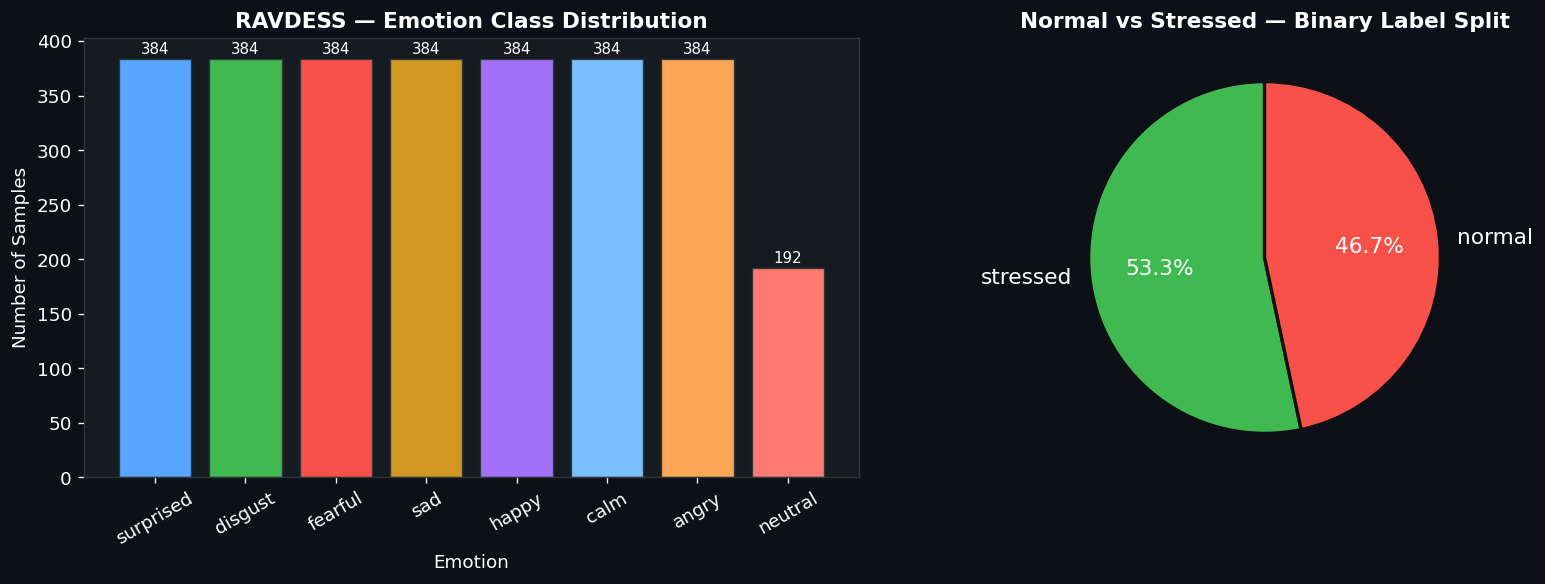

Dataset distribution plotted.


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

emotion_counts = df_meta['emotion'].value_counts()
colors_e = ['#58a6ff','#3fb950','#f85149','#d29922','#a371f7','#79c0ff','#ffa657','#ff7b72']
axes[0].bar(emotion_counts.index, emotion_counts.values, color=colors_e, edgecolor='#30363d', linewidth=0.8)
axes[0].set_title('RAVDESS — Emotion Class Distribution', fontweight='bold')
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=30)
for i, (idx, val) in enumerate(emotion_counts.items()):
    axes[0].text(i, val + 2, str(val), ha='center', va='bottom', fontsize=9, color='white')

stress_counts = df_meta['stress_label'].value_counts()
axes[1].pie(
    stress_counts.values, labels=stress_counts.index,
    colors=['#3fb950', '#f85149'], autopct='%1.1f%%', startangle=90,
    wedgeprops={'edgecolor': '#0d1117', 'linewidth': 2},
    textprops={'color': 'white', 'fontsize': 13}
)
axes[1].set_title('Normal vs Stressed — Binary Label Split', fontweight='bold')

plt.tight_layout()
plt.savefig('dataset_distribution.png', bbox_inches='tight')
plt.show()
print("Dataset distribution plotted.")

## 🔊 Cell 5 — Load Sample Audio & Play (Normal vs Stressed)

In [5]:
SR         = 22050
N_FFT      = 2048
HOP_LENGTH = 512
N_MFCC     = 40

normal_file   = df_meta[df_meta['stress_label'] == 'normal']['filepath'].iloc[0]
stressed_file = df_meta[df_meta['stress_label'] == 'stressed']['filepath'].iloc[0]

y_normal,   sr_normal   = librosa.load(normal_file,   sr=SR)
y_stressed, sr_stressed = librosa.load(stressed_file, sr=SR)

print(f"Normal sample   : {os.path.basename(normal_file)}")
print(f"Duration        : {len(y_normal)/sr_normal:.2f}s  |  SR: {sr_normal} Hz")
print(f"\nStressed sample : {os.path.basename(stressed_file)}")
print(f"Duration        : {len(y_stressed)/sr_stressed:.2f}s  |  SR: {sr_stressed} Hz")

print("\nNormal audio:")
display(Audio(y_normal,   rate=SR))
print("\nStressed audio:")
display(Audio(y_stressed, rate=SR))

Normal sample   : 03-01-01-01-01-01-02.wav
Duration        : 3.64s  |  SR: 22050 Hz

Stressed sample : 03-01-08-01-01-01-02.wav
Duration        : 3.54s  |  SR: 22050 Hz

Normal audio:



Stressed audio:


## 🌊 Cell 6 — Waveform Comparison: Normal vs Stressed

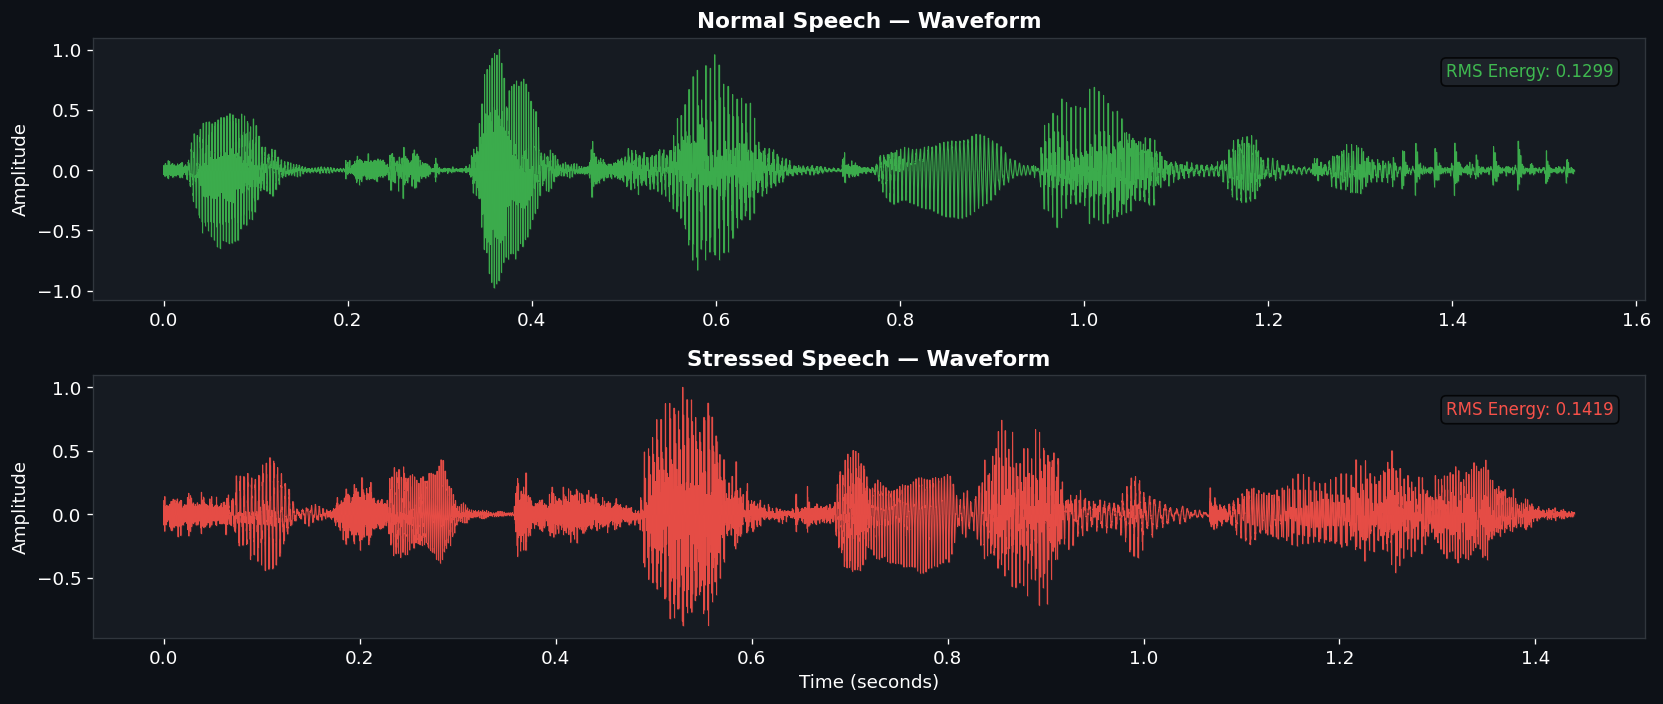

Normal RMS Energy   : 0.12990
Stressed RMS Energy : 0.14187
Energy Ratio (S/N)  : 1.09x


In [6]:
def preprocess_audio(y, sr=SR):
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)
    return librosa.util.normalize(y_trimmed)

y_n_proc = preprocess_audio(y_normal)
y_s_proc = preprocess_audio(y_stressed)

fig, axes = plt.subplots(2, 1, figsize=(14, 6))

t_normal = np.linspace(0, len(y_n_proc)/SR, len(y_n_proc))
axes[0].plot(t_normal, y_n_proc, color='#3fb950', linewidth=0.6, alpha=0.9)
axes[0].set_title('Normal Speech — Waveform', fontweight='bold')
axes[0].set_ylabel('Amplitude')
axes[0].fill_between(t_normal, y_n_proc, alpha=0.15, color='#3fb950')

t_stressed = np.linspace(0, len(y_s_proc)/SR, len(y_s_proc))
axes[1].plot(t_stressed, y_s_proc, color='#f85149', linewidth=0.6, alpha=0.9)
axes[1].set_title('Stressed Speech — Waveform', fontweight='bold')
axes[1].set_ylabel('Amplitude')
axes[1].set_xlabel('Time (seconds)')
axes[1].fill_between(t_stressed, y_s_proc, alpha=0.15, color='#f85149')

rms_n = np.sqrt(np.mean(y_n_proc**2))
rms_s = np.sqrt(np.mean(y_s_proc**2))
axes[0].text(0.98, 0.85, f'RMS Energy: {rms_n:.4f}', transform=axes[0].transAxes,
             ha='right', color='#3fb950', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='#21262d', alpha=0.8))
axes[1].text(0.98, 0.85, f'RMS Energy: {rms_s:.4f}', transform=axes[1].transAxes,
             ha='right', color='#f85149', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='#21262d', alpha=0.8))

plt.tight_layout()
plt.savefig('waveforms.png', bbox_inches='tight')
plt.show()
print(f"Normal RMS Energy   : {rms_n:.5f}")
print(f"Stressed RMS Energy : {rms_s:.5f}")
print(f"Energy Ratio (S/N)  : {rms_s/rms_n:.2f}x")

## ⚙️ Cell 7 — Signal Preprocessing: Framing & Windowing

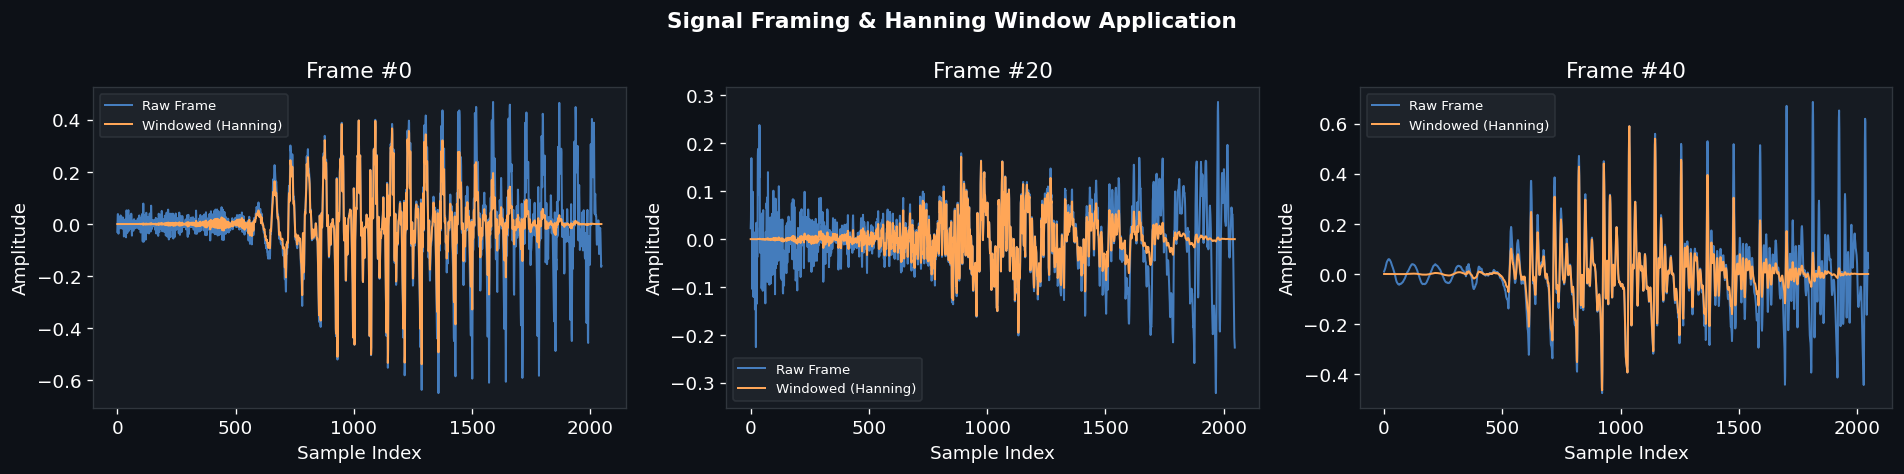

Frame shape     : (2048, 63)  (samples x num_frames)
Windowed shape  : (2048, 63)


In [7]:
frames = librosa.util.frame(y_n_proc, frame_length=N_FFT, hop_length=HOP_LENGTH)
window = np.hanning(N_FFT)
windowed_frames = frames * window[:, np.newaxis]

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for i, ax in enumerate(axes):
    frame_idx = i * 20
    ax.plot(frames[:, frame_idx], color='#58a6ff', linewidth=1.2, label='Raw Frame', alpha=0.7)
    ax.plot(windowed_frames[:, frame_idx], color='#ffa657', linewidth=1.2, label='Windowed (Hanning)')
    ax.set_title(f'Frame #{frame_idx}')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Amplitude')
    ax.legend(fontsize=8)

fig.suptitle('Signal Framing & Hanning Window Application', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.savefig('framing_windowing.png', bbox_inches='tight')
plt.show()
print(f"Frame shape     : {frames.shape}  (samples x num_frames)")
print(f"Windowed shape  : {windowed_frames.shape}")

## 🌈 Cell 8 — Spectrogram Comparison (STFT + Mel)

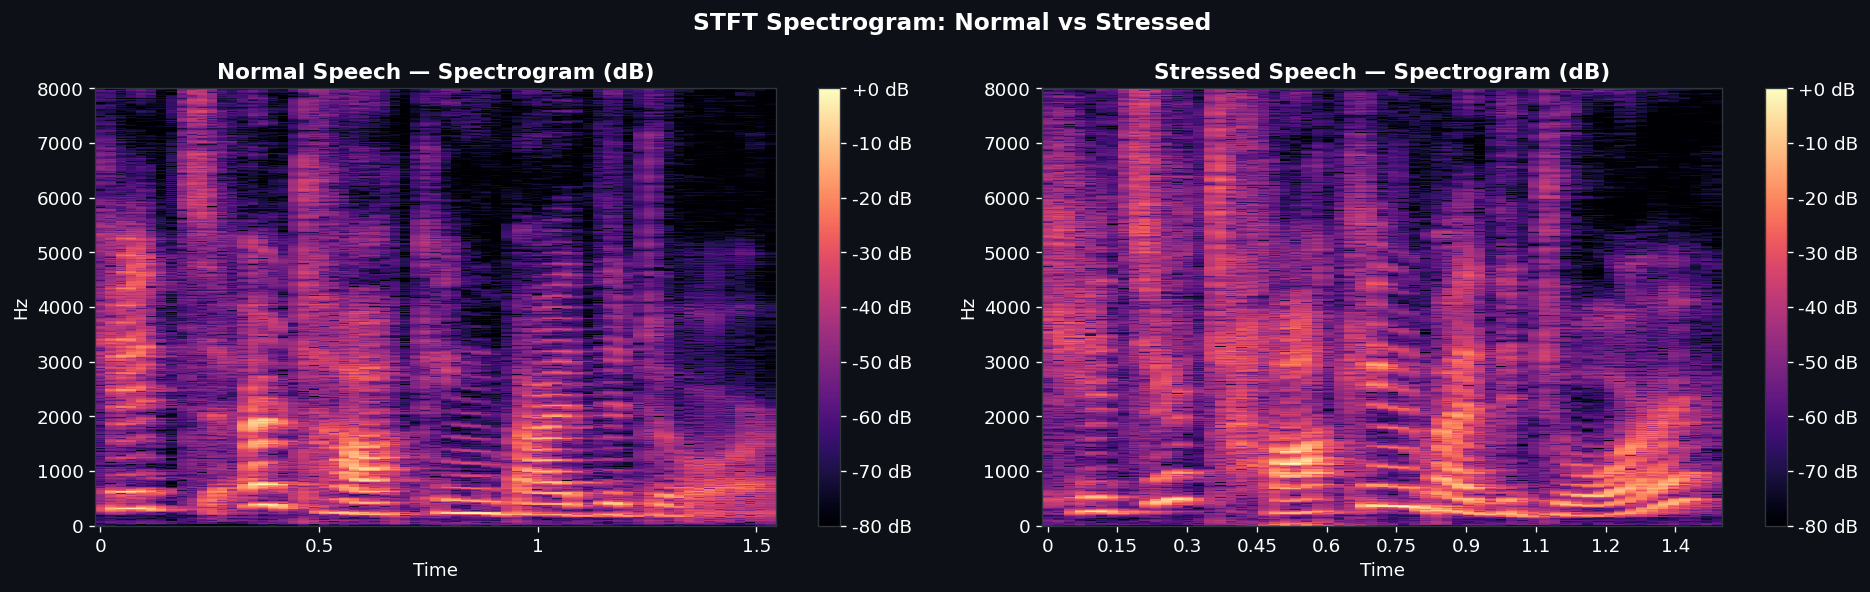

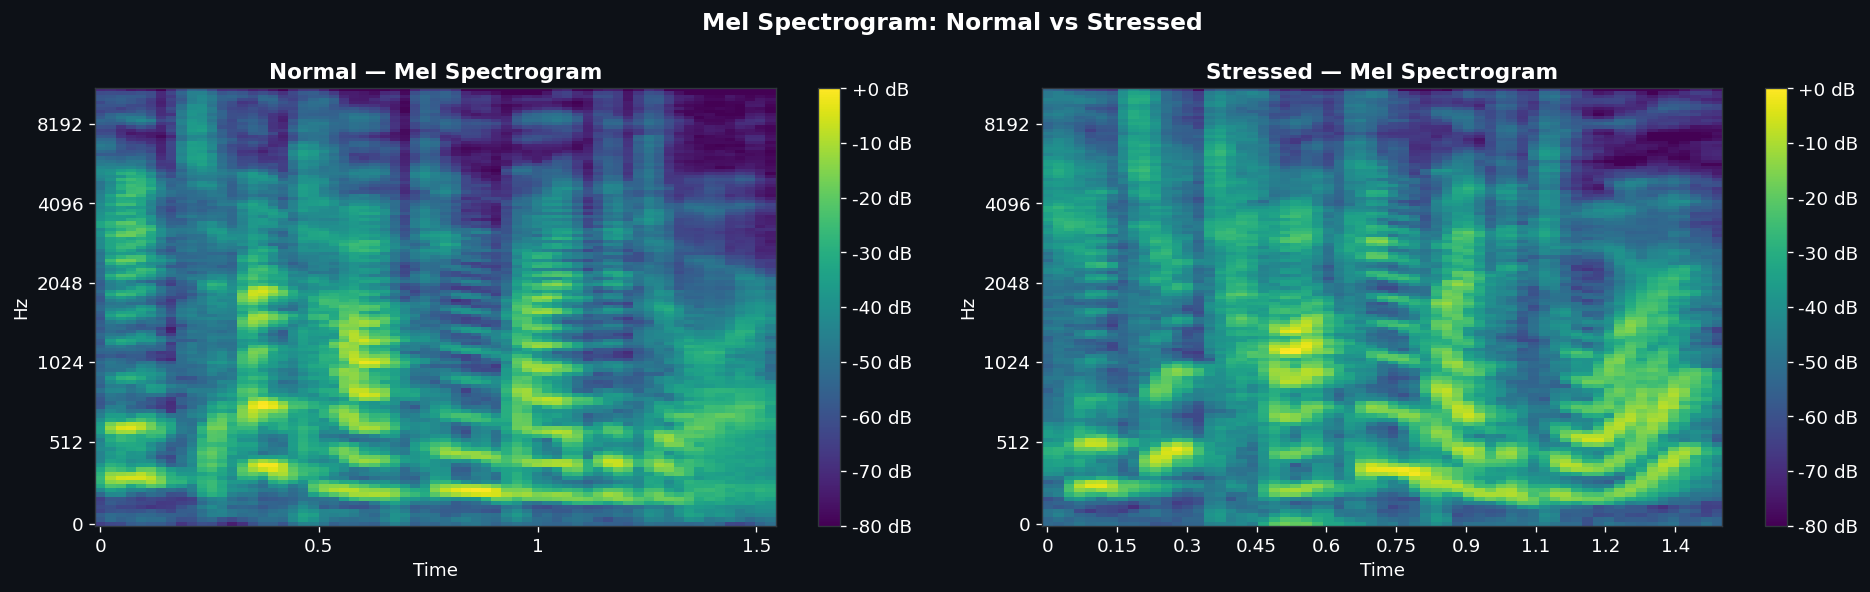

Spectrograms generated.


In [8]:
D_normal   = librosa.stft(y_n_proc, n_fft=N_FFT, hop_length=HOP_LENGTH)
D_stressed = librosa.stft(y_s_proc, n_fft=N_FFT, hop_length=HOP_LENGTH)
DB_normal   = librosa.amplitude_to_db(np.abs(D_normal),   ref=np.max)
DB_stressed = librosa.amplitude_to_db(np.abs(D_stressed), ref=np.max)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
img1 = librosa.display.specshow(DB_normal, sr=SR, hop_length=HOP_LENGTH,
                                 x_axis='time', y_axis='hz', ax=axes[0], cmap='magma')
axes[0].set_title('Normal Speech — Spectrogram (dB)', fontweight='bold')
axes[0].set_ylim([0, 8000])
fig.colorbar(img1, ax=axes[0], format='%+2.0f dB')

img2 = librosa.display.specshow(DB_stressed, sr=SR, hop_length=HOP_LENGTH,
                                 x_axis='time', y_axis='hz', ax=axes[1], cmap='magma')
axes[1].set_title('Stressed Speech — Spectrogram (dB)', fontweight='bold')
axes[1].set_ylim([0, 8000])
fig.colorbar(img2, ax=axes[1], format='%+2.0f dB')

plt.suptitle('STFT Spectrogram: Normal vs Stressed', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('spectrograms.png', bbox_inches='tight')
plt.show()

mel_n = librosa.feature.melspectrogram(y=y_n_proc, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=128)
mel_s = librosa.feature.melspectrogram(y=y_s_proc, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=128)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
img3 = librosa.display.specshow(librosa.power_to_db(mel_n, ref=np.max),
                                 sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel',
                                 ax=axes[0], cmap='viridis')
axes[0].set_title('Normal — Mel Spectrogram', fontweight='bold')
fig.colorbar(img3, ax=axes[0], format='%+2.0f dB')

img4 = librosa.display.specshow(librosa.power_to_db(mel_s, ref=np.max),
                                 sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel',
                                 ax=axes[1], cmap='viridis')
axes[1].set_title('Stressed — Mel Spectrogram', fontweight='bold')
fig.colorbar(img4, ax=axes[1], format='%+2.0f dB')

plt.suptitle('Mel Spectrogram: Normal vs Stressed', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('mel_spectrograms.png', bbox_inches='tight')
plt.show()
print("Spectrograms generated.")

## 🔬 Cell 9 — MFCC Extraction & Visualization (40 Coefficients)

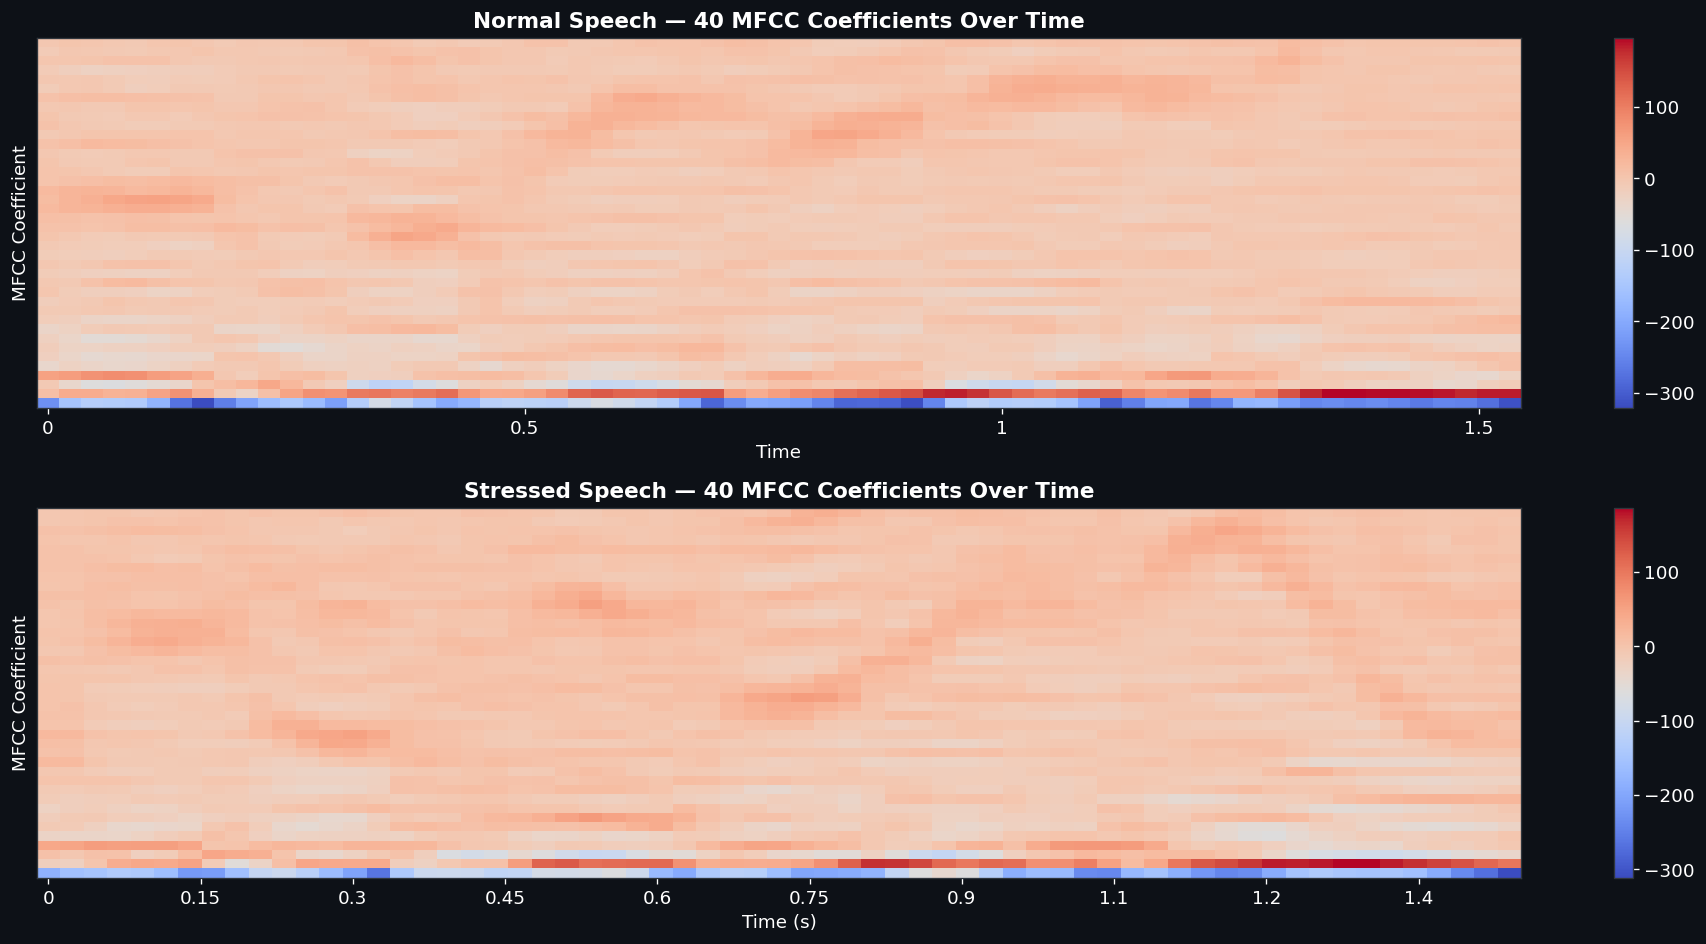

Normal MFCC   — Shape: (40, 67) | Mean: -5.659 | Std: 41.064
Stressed MFCC — Shape: (40, 63) | Mean: -4.282 | Std: 34.905


In [9]:
mfcc_normal   = librosa.feature.mfcc(y=y_n_proc, sr=SR, n_mfcc=40, n_fft=N_FFT, hop_length=HOP_LENGTH)
mfcc_stressed = librosa.feature.mfcc(y=y_s_proc, sr=SR, n_mfcc=40, n_fft=N_FFT, hop_length=HOP_LENGTH)

fig, axes = plt.subplots(2, 1, figsize=(16, 8))
img5 = librosa.display.specshow(mfcc_normal, x_axis='time', ax=axes[0],
                                 cmap='coolwarm', hop_length=HOP_LENGTH, sr=SR)
axes[0].set_title('Normal Speech — 40 MFCC Coefficients Over Time', fontweight='bold')
axes[0].set_ylabel('MFCC Coefficient')
fig.colorbar(img5, ax=axes[0])

img6 = librosa.display.specshow(mfcc_stressed, x_axis='time', ax=axes[1],
                                 cmap='coolwarm', hop_length=HOP_LENGTH, sr=SR)
axes[1].set_title('Stressed Speech — 40 MFCC Coefficients Over Time', fontweight='bold')
axes[1].set_ylabel('MFCC Coefficient')
axes[1].set_xlabel('Time (s)')
fig.colorbar(img6, ax=axes[1])

plt.tight_layout()
plt.savefig('mfcc_heatmap.png', bbox_inches='tight')
plt.show()
print(f"Normal MFCC   — Shape: {mfcc_normal.shape} | Mean: {mfcc_normal.mean():.3f} | Std: {mfcc_normal.std():.3f}")
print(f"Stressed MFCC — Shape: {mfcc_stressed.shape} | Mean: {mfcc_stressed.mean():.3f} | Std: {mfcc_stressed.std():.3f}")

## 📉 Cell 10 — MFCC Trajectory Over Time (Time-Series Analysis)

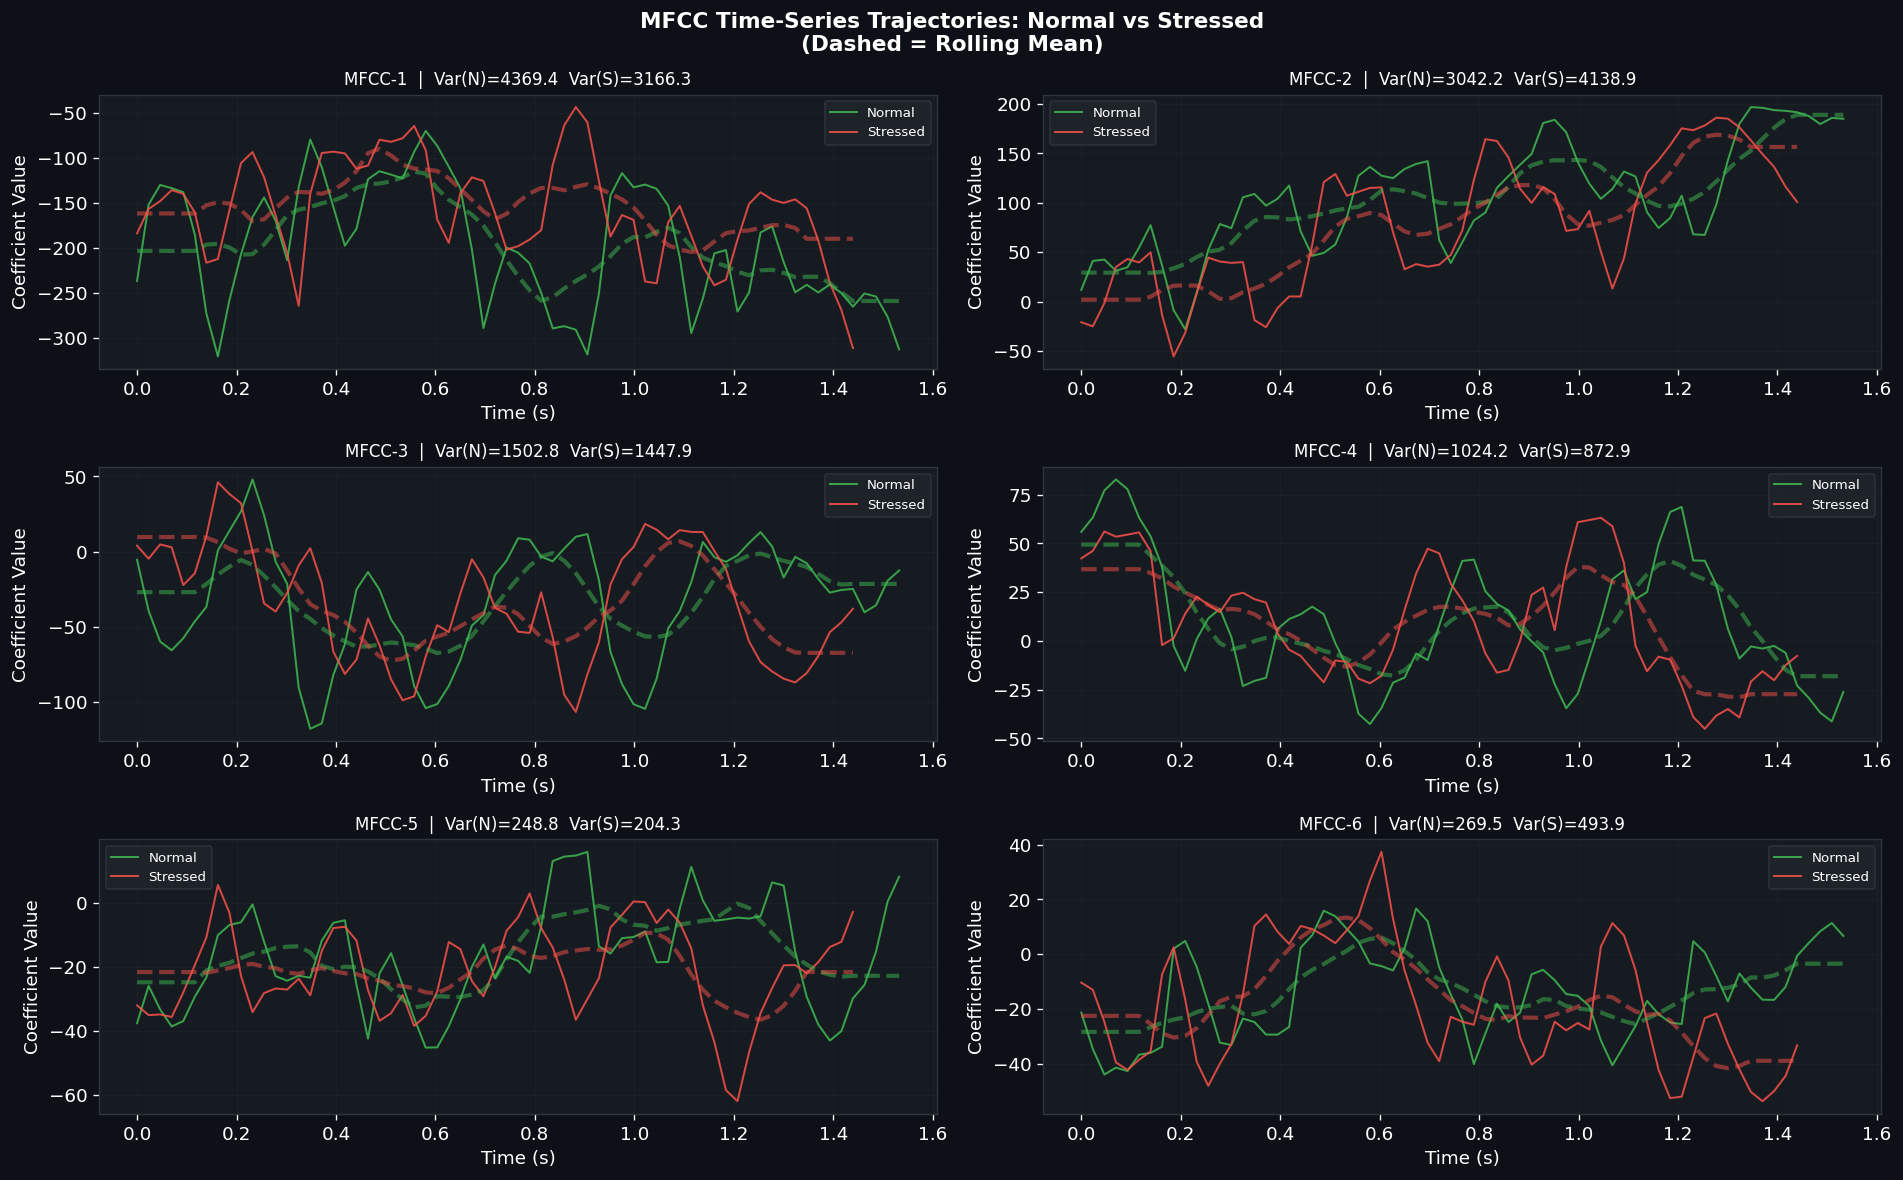

MFCC time-series trajectories plotted.


In [10]:
fig, axes = plt.subplots(3, 2, figsize=(16, 10))
axes = axes.flatten()

times_n = librosa.frames_to_time(np.arange(mfcc_normal.shape[1]),   sr=SR, hop_length=HOP_LENGTH)
times_s = librosa.frames_to_time(np.arange(mfcc_stressed.shape[1]), sr=SR, hop_length=HOP_LENGTH)

for i in range(6):
    ax = axes[i]
    ax.plot(times_n, mfcc_normal[i],   color='#3fb950', linewidth=1.2, label='Normal',   alpha=0.85)
    ax.plot(times_s, mfcc_stressed[i], color='#f85149', linewidth=1.2, label='Stressed', alpha=0.85)
    roll_n = pd.Series(mfcc_normal[i]).rolling(10, center=True).mean().bfill().ffill()
    roll_s = pd.Series(mfcc_stressed[i]).rolling(10, center=True).mean().bfill().ffill()
    ax.plot(times_n[:len(roll_n)], roll_n.values, color='#3fb950', linewidth=2.5, linestyle='--', alpha=0.5)
    ax.plot(times_s[:len(roll_s)], roll_s.values, color='#f85149', linewidth=2.5, linestyle='--', alpha=0.5)
    var_n = np.var(mfcc_normal[i])
    var_s = np.var(mfcc_stressed[i])
    ax.set_title(f'MFCC-{i+1}  |  Var(N)={var_n:.1f}  Var(S)={var_s:.1f}', fontsize=10)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Coefficient Value')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.2, color='#30363d')

fig.suptitle('MFCC Time-Series Trajectories: Normal vs Stressed\n(Dashed = Rolling Mean)',
             fontweight='bold', fontsize=13)
plt.tight_layout()
plt.savefig('mfcc_trajectories.png', bbox_inches='tight')
plt.show()
print("MFCC time-series trajectories plotted.")

## 🎵 Cell 11 — Pitch Contour Extraction (Autocorrelation / pyin)

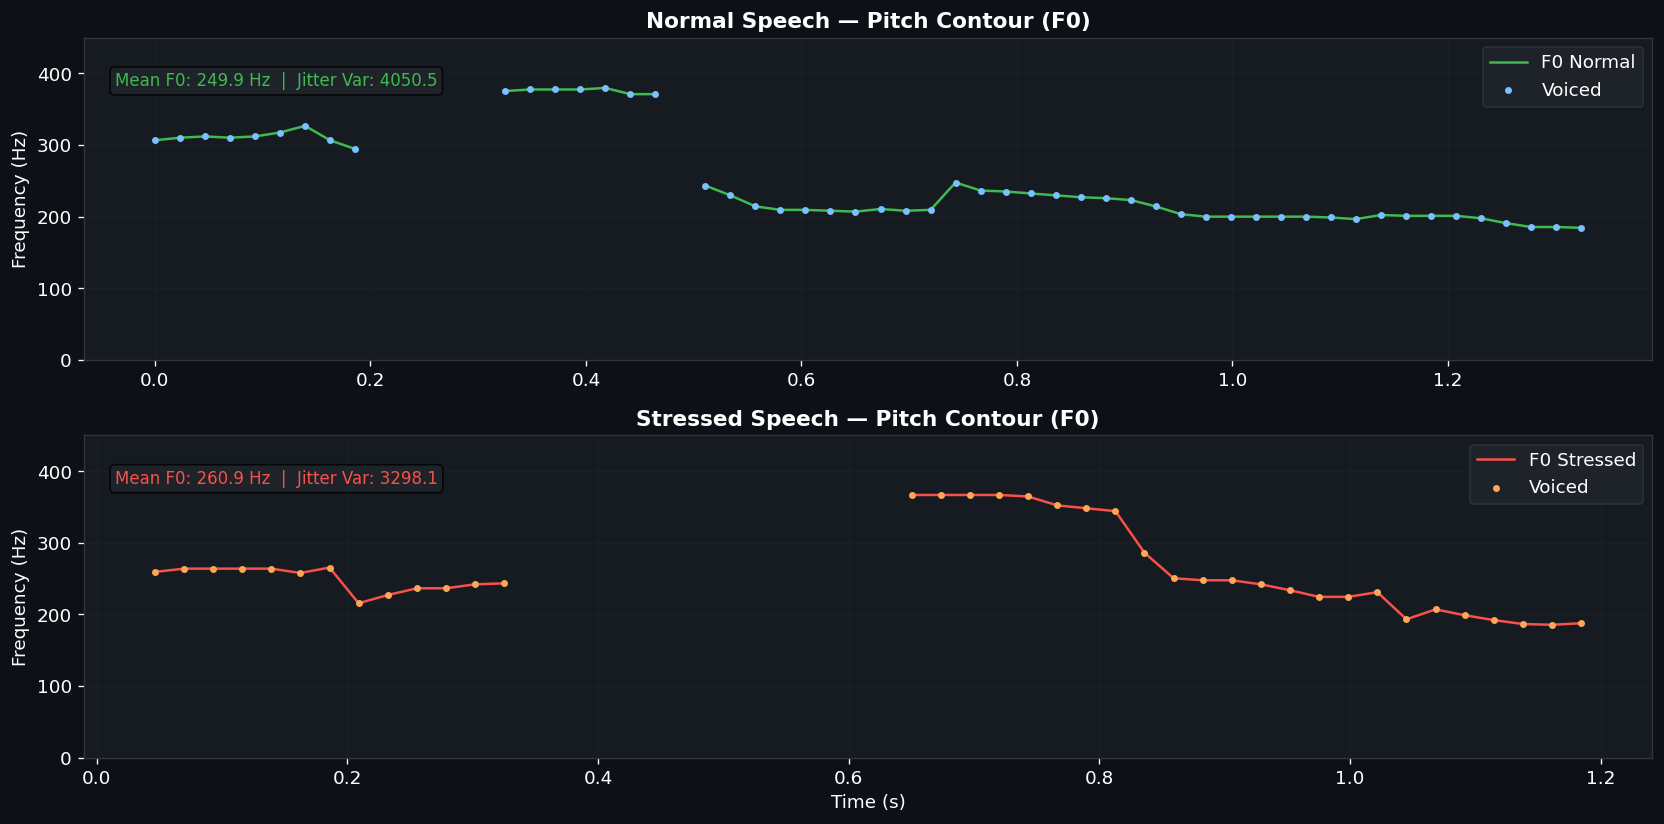

Normal   — Mean Pitch: 249.9 Hz | Jitter (Var): 4050.48
Stressed — Mean Pitch: 260.9 Hz | Jitter (Var): 3298.08


In [11]:
f0_normal,   vf_normal,   _ = librosa.pyin(y_n_proc, fmin=50, fmax=400, sr=SR, hop_length=HOP_LENGTH)
f0_stressed, vf_stressed, _ = librosa.pyin(y_s_proc, fmin=50, fmax=400, sr=SR, hop_length=HOP_LENGTH)

times_f0_n = librosa.frames_to_time(np.arange(len(f0_normal)),   sr=SR, hop_length=HOP_LENGTH)
times_f0_s = librosa.frames_to_time(np.arange(len(f0_stressed)), sr=SR, hop_length=HOP_LENGTH)

fig, axes = plt.subplots(2, 1, figsize=(14, 7))
axes[0].plot(times_f0_n, f0_normal, color='#3fb950', linewidth=1.5, label='F0 Normal')
axes[0].scatter(times_f0_n[vf_normal], f0_normal[vf_normal], color='#79c0ff', s=10, zorder=5, label='Voiced')
axes[0].set_title('Normal Speech — Pitch Contour (F0)', fontweight='bold')
axes[0].set_ylabel('Frequency (Hz)')
axes[0].set_ylim([0, 450])
axes[0].legend()
axes[0].grid(alpha=0.2, color='#30363d')
axes[0].text(0.02, 0.85, f'Mean F0: {np.nanmean(f0_normal):.1f} Hz  |  Jitter Var: {np.nanvar(f0_normal):.1f}',
             transform=axes[0].transAxes, color='#3fb950', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='#21262d', alpha=0.8))

axes[1].plot(times_f0_s, f0_stressed, color='#f85149', linewidth=1.5, label='F0 Stressed')
axes[1].scatter(times_f0_s[vf_stressed], f0_stressed[vf_stressed], color='#ffa657', s=10, zorder=5, label='Voiced')
axes[1].set_title('Stressed Speech — Pitch Contour (F0)', fontweight='bold')
axes[1].set_ylabel('Frequency (Hz)')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylim([0, 450])
axes[1].legend()
axes[1].grid(alpha=0.2, color='#30363d')
axes[1].text(0.02, 0.85, f'Mean F0: {np.nanmean(f0_stressed):.1f} Hz  |  Jitter Var: {np.nanvar(f0_stressed):.1f}',
             transform=axes[1].transAxes, color='#f85149', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='#21262d', alpha=0.8))

plt.tight_layout()
plt.savefig('pitch_contours.png', bbox_inches='tight')
plt.show()
print(f"Normal   — Mean Pitch: {np.nanmean(f0_normal):.1f} Hz | Jitter (Var): {np.nanvar(f0_normal):.2f}")
print(f"Stressed — Mean Pitch: {np.nanmean(f0_stressed):.1f} Hz | Jitter (Var): {np.nanvar(f0_stressed):.2f}")

## 📊 Cell 11b — ZCR, Spectral Centroid & RMS Energy (Normal vs Stressed)

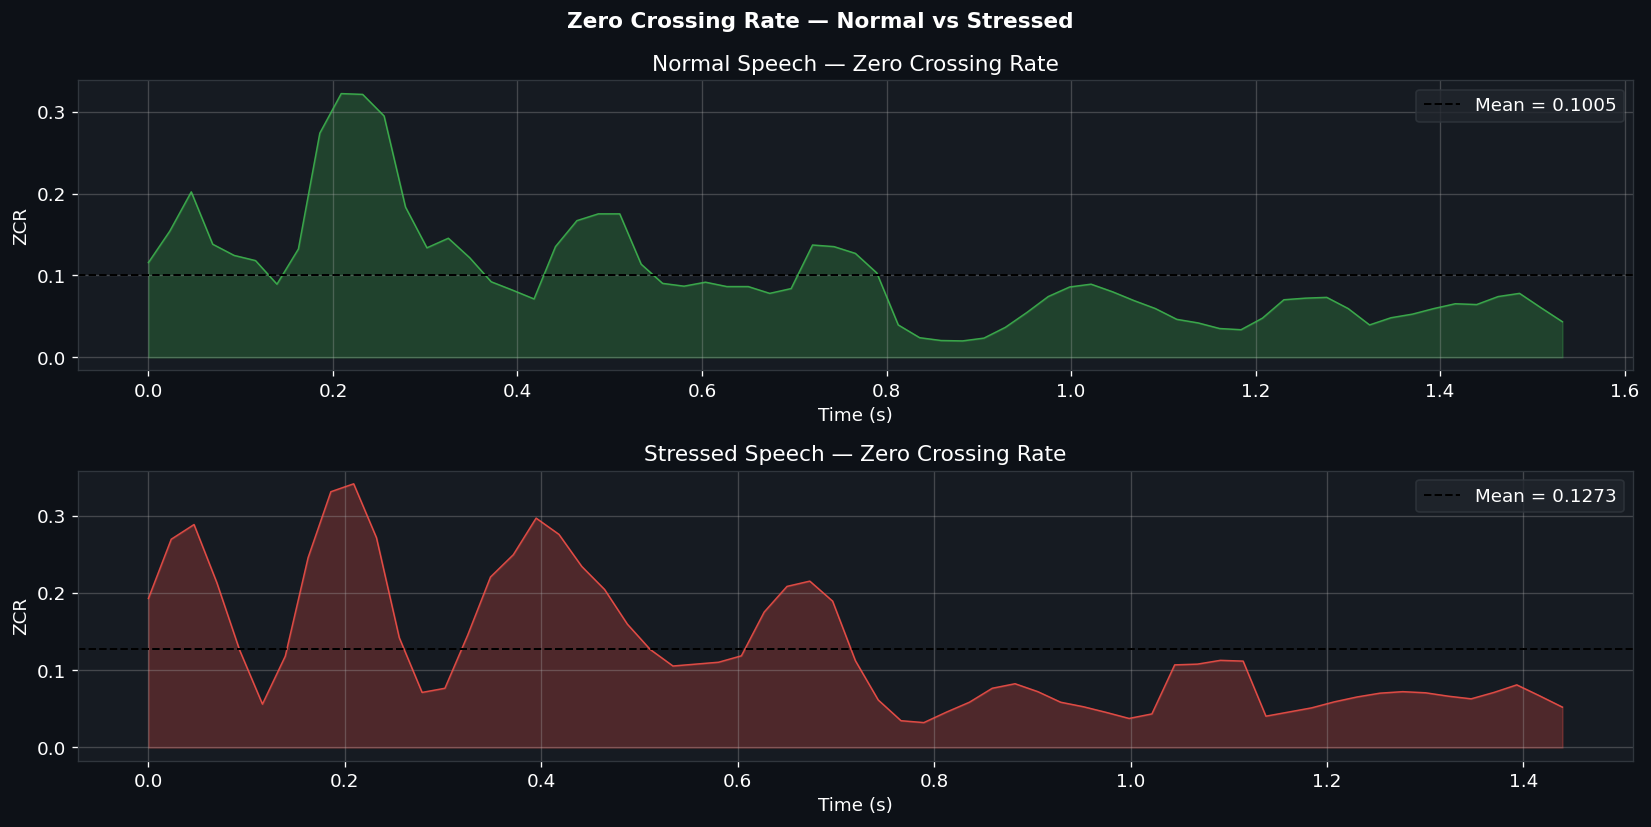

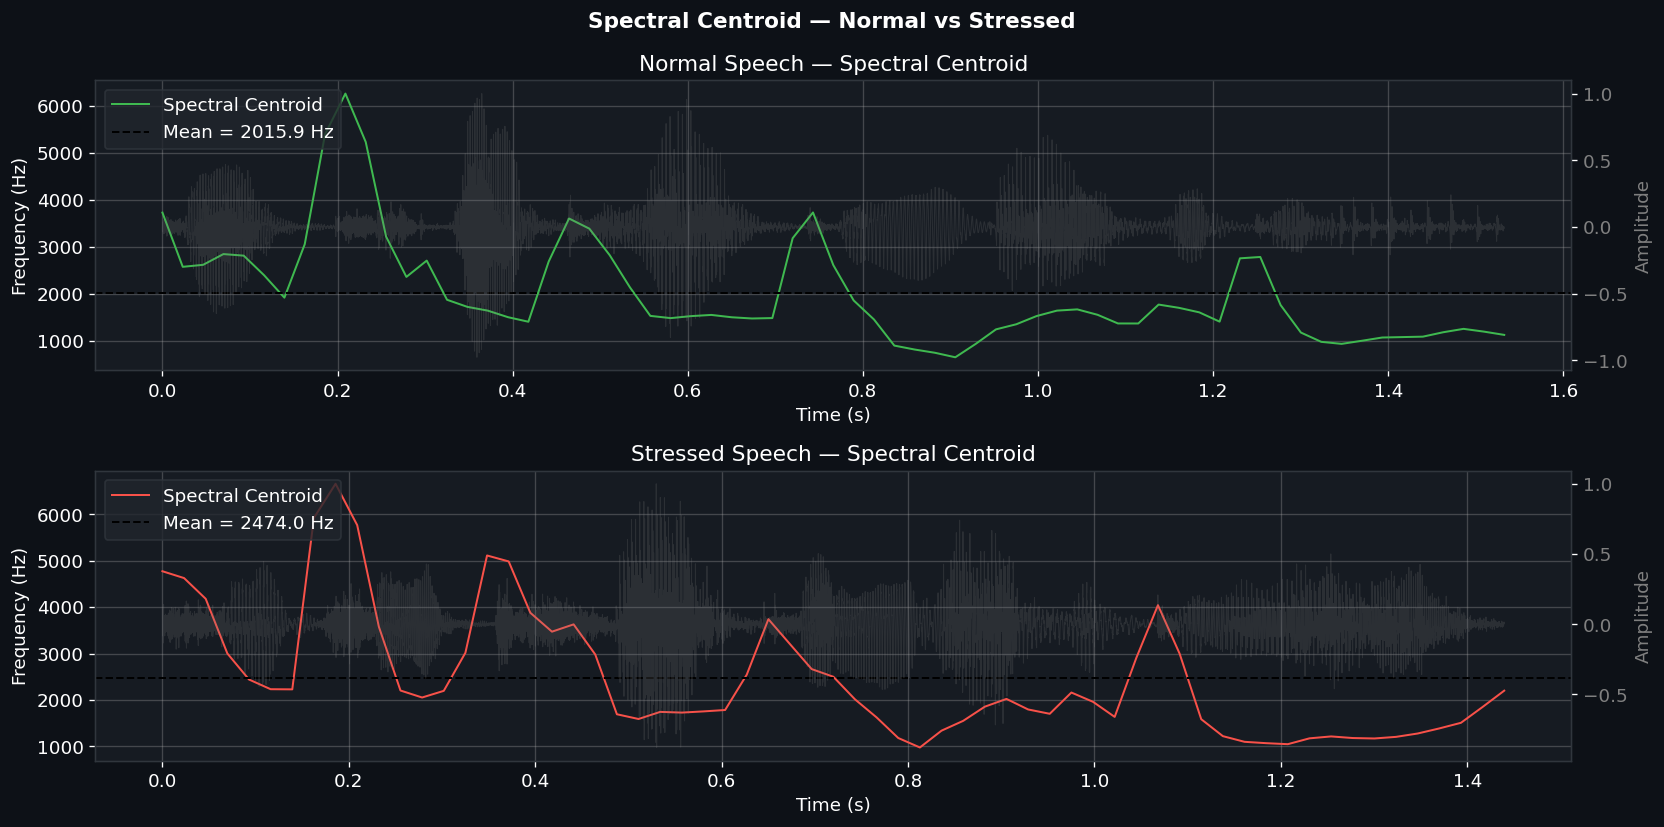

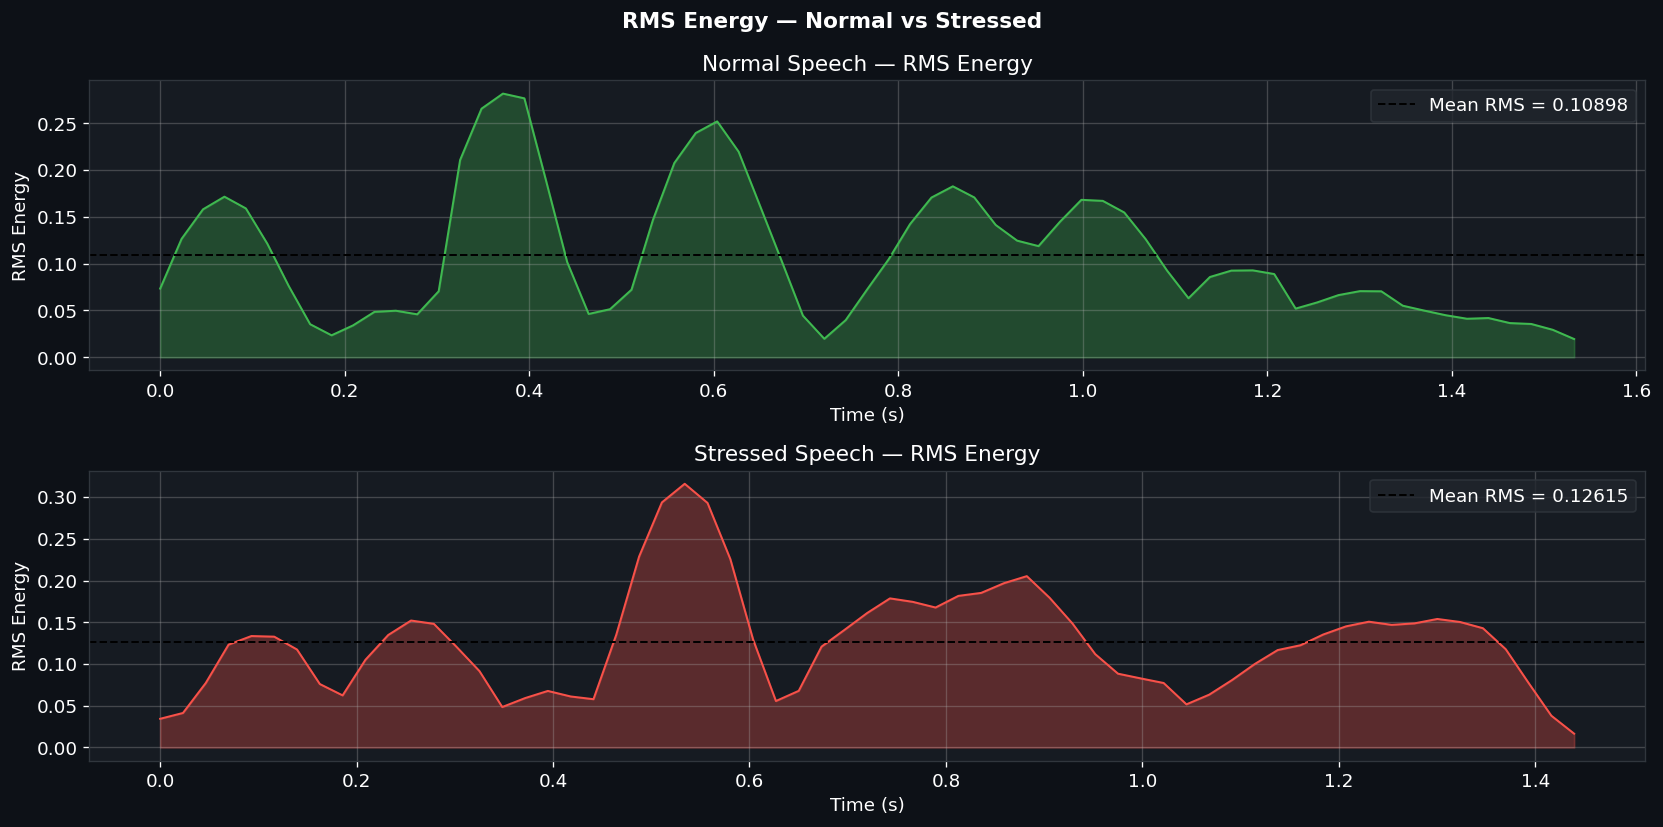

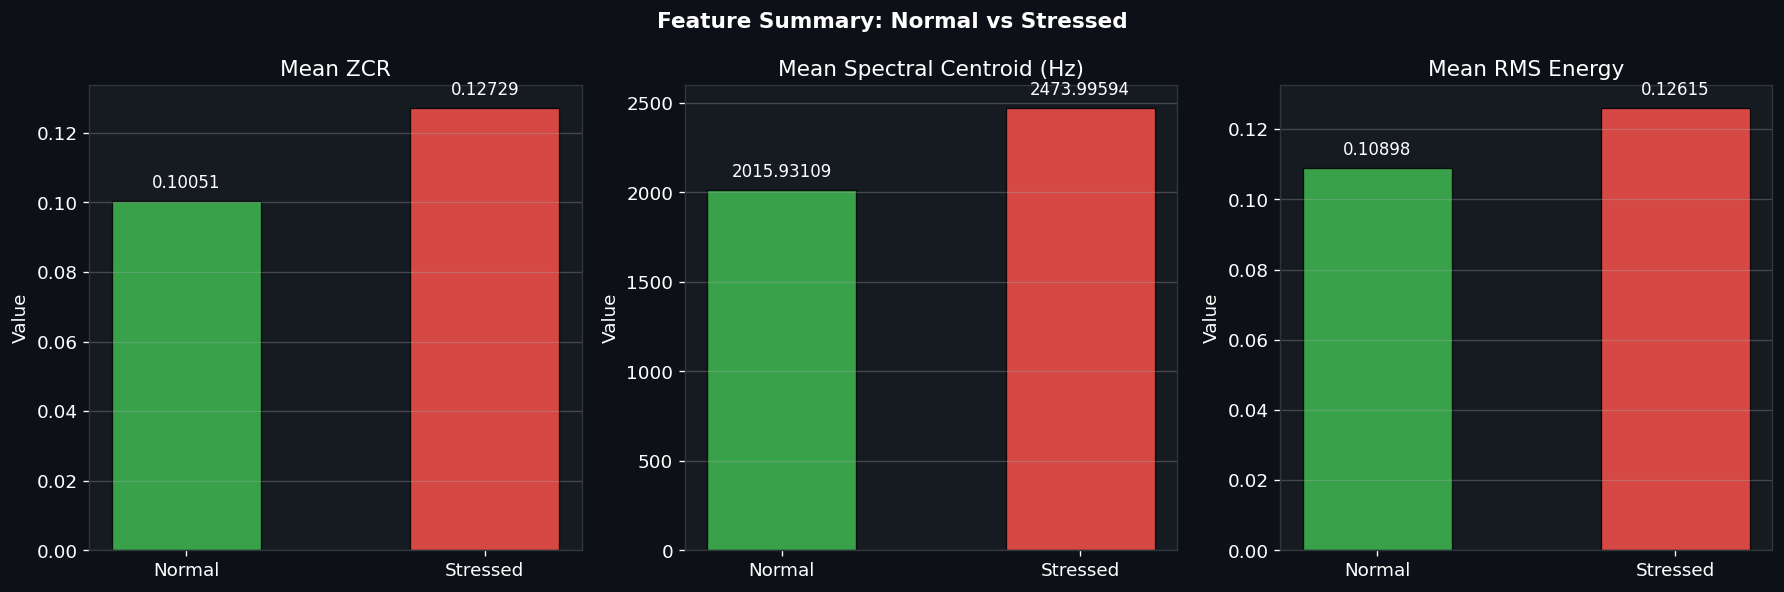

ZCR    - Normal mean: 0.10051 | Stressed mean: 0.12729
SC     - Normal mean: 2015.93 Hz | Stressed mean: 2474.0 Hz
RMS    - Normal mean: 0.108978 | Stressed mean: 0.126145


In [12]:
from scipy import signal as scipy_signal

# ── Compute features ─────────────────────────────────────────────────────────
zcr_n   = librosa.feature.zero_crossing_rate(y_n_proc, frame_length=N_FFT, hop_length=HOP_LENGTH).flatten()
zcr_s   = librosa.feature.zero_crossing_rate(y_s_proc, frame_length=N_FFT, hop_length=HOP_LENGTH).flatten()

sc_n    = librosa.feature.spectral_centroid(y=y_n_proc, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH).flatten()
sc_s    = librosa.feature.spectral_centroid(y=y_s_proc, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH).flatten()

rms_n   = librosa.feature.rms(y=y_n_proc, frame_length=N_FFT, hop_length=HOP_LENGTH).flatten()
rms_s   = librosa.feature.rms(y=y_s_proc, frame_length=N_FFT, hop_length=HOP_LENGTH).flatten()

t_zcr_n = librosa.frames_to_time(np.arange(len(zcr_n)), sr=SR, hop_length=HOP_LENGTH)
t_zcr_s = librosa.frames_to_time(np.arange(len(zcr_s)), sr=SR, hop_length=HOP_LENGTH)

# ── Plot ZCR ─────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=False)
fig.suptitle('Zero Crossing Rate — Normal vs Stressed', fontsize=13, fontweight='bold')

for ax, zcr, times, label, color in [
    (axes[0], zcr_n, t_zcr_n, 'Normal',   '#3fb950'),
    (axes[1], zcr_s, t_zcr_s, 'Stressed', '#f85149'),
]:
    ax.plot(times, zcr, color=color, alpha=0.85, linewidth=0.9)
    ax.axhline(np.mean(zcr), color='black', linestyle='--',
               linewidth=1.2, label=f'Mean = {np.mean(zcr):.4f}')
    ax.fill_between(times, zcr, alpha=0.25, color=color)
    ax.set_title(f'{label} Speech — Zero Crossing Rate')
    ax.set_xlabel('Time (s)'); ax.set_ylabel('ZCR')
    ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# ── Plot Spectral Centroid ────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=False)
fig.suptitle('Spectral Centroid — Normal vs Stressed', fontsize=13, fontweight='bold')

for ax, sc, y_sig, times, label, color in [
    (axes[0], sc_n, y_n_proc, t_zcr_n, 'Normal',   '#3fb950'),
    (axes[1], sc_s, y_s_proc, t_zcr_s, 'Stressed', '#f85149'),
]:
    ax2 = ax.twinx()
    t_wave = np.linspace(0, len(y_sig)/SR, len(y_sig))
    ax2.plot(t_wave, y_sig, color='gray', alpha=0.2, linewidth=0.6)
    ax2.set_ylabel('Amplitude', color='gray'); ax2.tick_params(axis='y', labelcolor='gray')
    ax.plot(times, sc, color=color, linewidth=1.2, label='Spectral Centroid')
    ax.axhline(np.mean(sc), color='black', linestyle='--',
               linewidth=1.2, label=f'Mean = {np.mean(sc):.1f} Hz')
    ax.set_title(f'{label} Speech — Spectral Centroid')
    ax.set_xlabel('Time (s)'); ax.set_ylabel('Frequency (Hz)')
    ax.legend(loc='upper left'); ax.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# ── Plot RMS Energy ───────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=False)
fig.suptitle('RMS Energy — Normal vs Stressed', fontsize=13, fontweight='bold')

for ax, rms, times, label, color in [
    (axes[0], rms_n, t_zcr_n, 'Normal',   '#3fb950'),
    (axes[1], rms_s, t_zcr_s, 'Stressed', '#f85149'),
]:
    ax.plot(times, rms, color=color, linewidth=1.2)
    ax.fill_between(times, rms, alpha=0.3, color=color)
    ax.axhline(np.mean(rms), color='black', linestyle='--',
               linewidth=1.2, label=f'Mean RMS = {np.mean(rms):.5f}')
    ax.set_title(f'{label} Speech — RMS Energy')
    ax.set_xlabel('Time (s)'); ax.set_ylabel('RMS Energy')
    ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# ── Feature Summary Bar ───────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Feature Summary: Normal vs Stressed', fontsize=13, fontweight='bold')

feature_pairs = {
    'Mean ZCR':              [np.mean(zcr_n), np.mean(zcr_s)],
    'Mean Spectral Centroid (Hz)': [np.mean(sc_n), np.mean(sc_s)],
    'Mean RMS Energy':       [np.mean(rms_n), np.mean(rms_s)],
}
for ax, (metric, vals) in zip(axes, feature_pairs.items()):
    bars = ax.bar(['Normal', 'Stressed'], vals, color=['#3fb950', '#f85149'], alpha=0.85,
                  width=0.5, edgecolor='black', linewidth=0.8)
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(vals)*0.02,
                f'{val:.5f}', ha='center', va='bottom', fontsize=10)
    ax.set_title(metric); ax.set_ylabel('Value'); ax.grid(axis='y', alpha=0.3)
plt.tight_layout(); plt.show()

print("ZCR    - Normal mean:", round(np.mean(zcr_n),5), "| Stressed mean:", round(np.mean(zcr_s),5))
print("SC     - Normal mean:", round(np.mean(sc_n),2),  "Hz | Stressed mean:", round(np.mean(sc_s),2), "Hz")
print("RMS    - Normal mean:", round(np.mean(rms_n),6), "| Stressed mean:", round(np.mean(rms_s),6))


## 📈 Cell 11c — MFCC Individual Coefficient Time-Series (Coefficients 1–4)

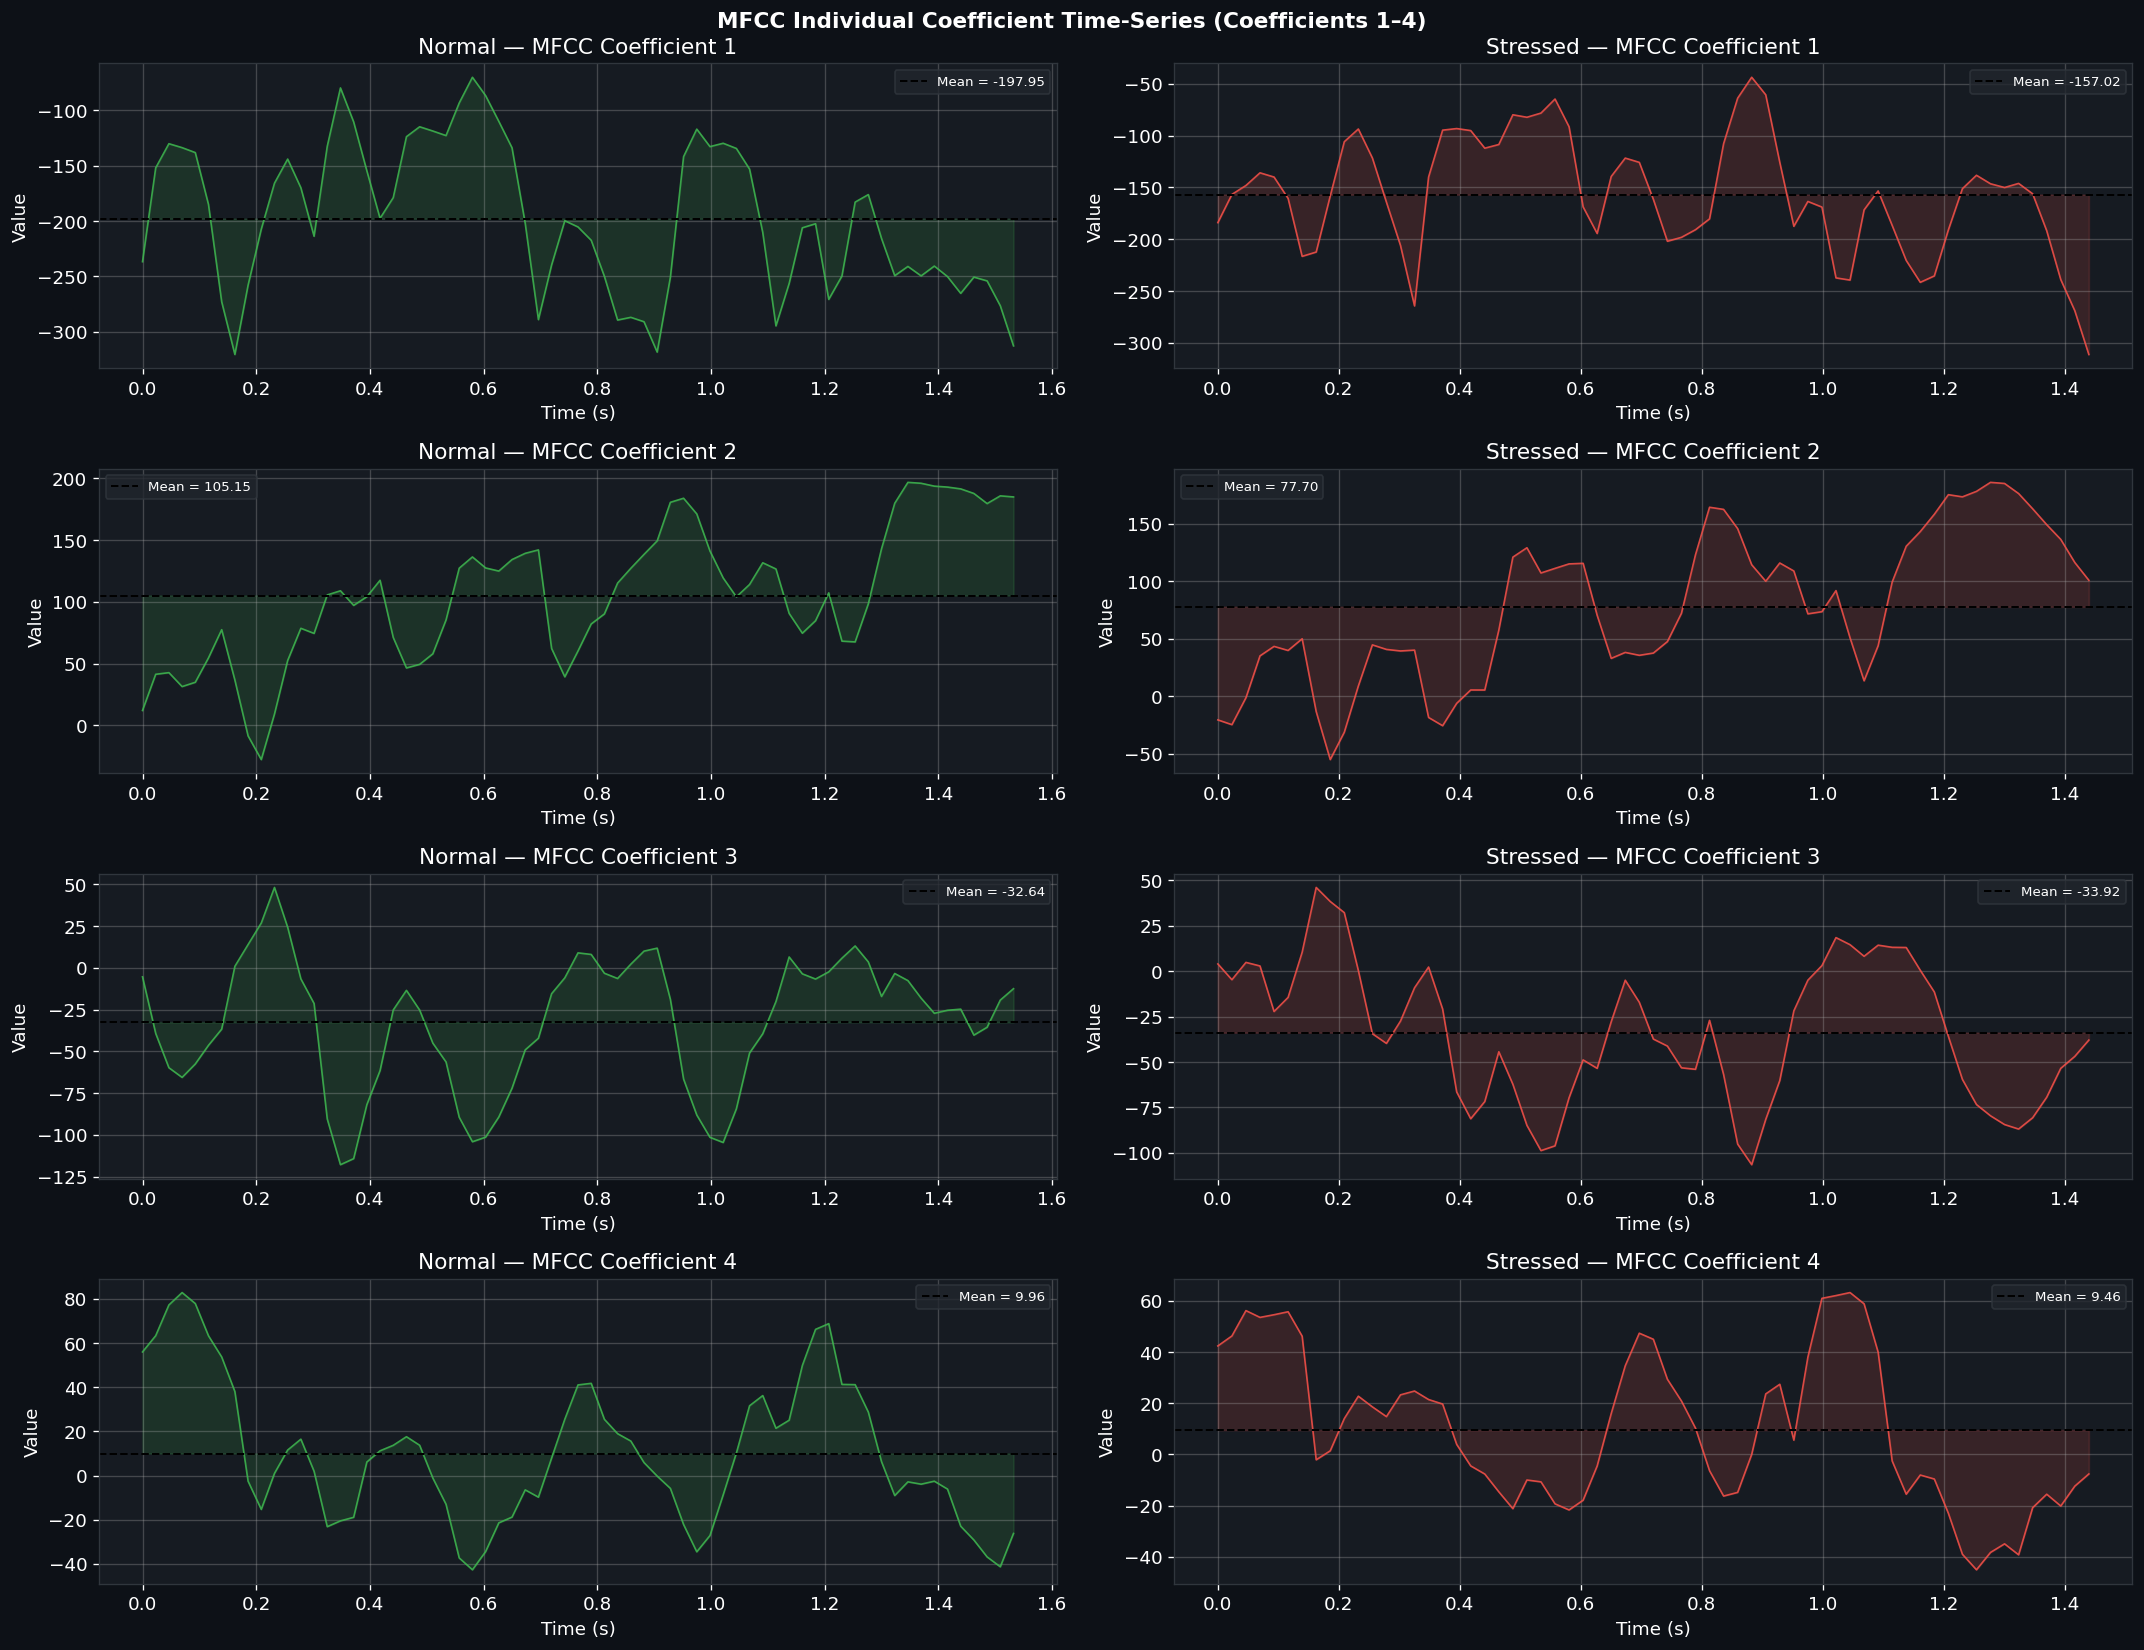

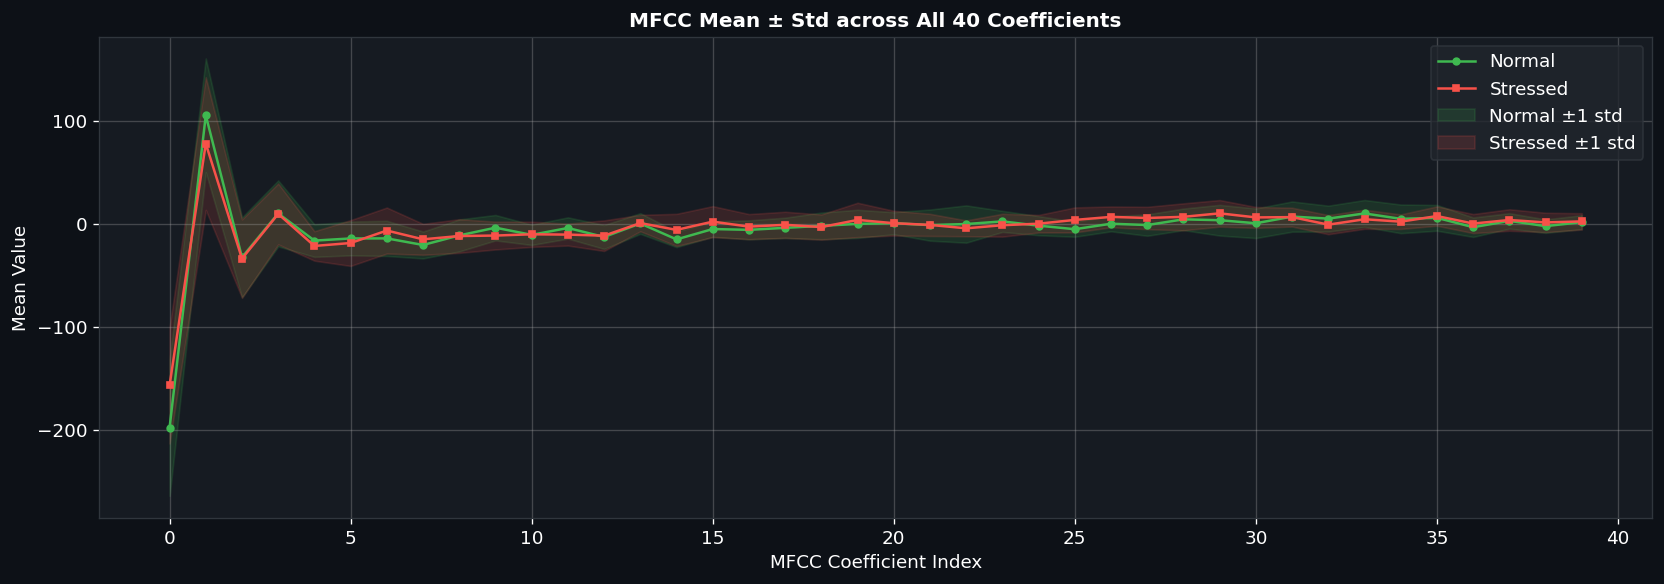

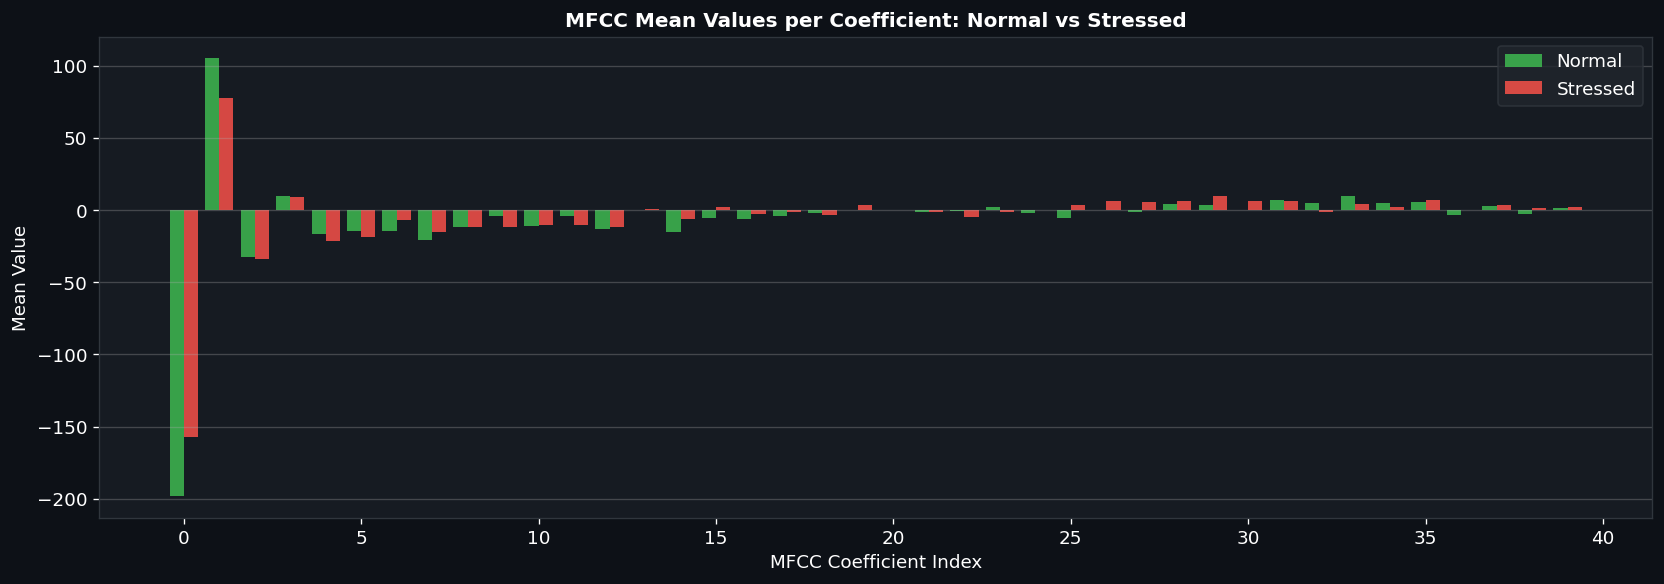

In [13]:
# ── MFCC Individual Coefficient Time-Series ──────────────────────────────────
fig, axes = plt.subplots(4, 2, figsize=(18, 14))
fig.suptitle('MFCC Individual Coefficient Time-Series (Coefficients 1–4)',
             fontsize=13, fontweight='bold')

for row, coeff_idx in enumerate([0, 1, 2, 3]):
    for col, (mfcc, label, color) in enumerate([
        (mfcc_normal,   'Normal',   '#3fb950'),
        (mfcc_stressed, 'Stressed', '#f85149'),
    ]):
        ax    = axes[row][col]
        coeff = mfcc[coeff_idx]
        times = librosa.frames_to_time(np.arange(len(coeff)), sr=SR, hop_length=HOP_LENGTH)
        ax.plot(times, coeff, color=color, linewidth=1.0, alpha=0.85)
        ax.axhline(np.mean(coeff), color='black', linestyle='--',
                   linewidth=1.2, label=f'Mean = {np.mean(coeff):.2f}')
        ax.fill_between(times, coeff, np.mean(coeff), alpha=0.15, color=color)
        ax.set_title(f'{label} — MFCC Coefficient {coeff_idx+1}')
        ax.set_xlabel('Time (s)'); ax.set_ylabel('Value')
        ax.legend(fontsize=8); ax.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# ── MFCC Mean ± Std across all 40 coefficients ───────────────────────────────
fig, ax = plt.subplots(figsize=(14, 5))
x = np.arange(40)
mn_n = mfcc_normal.mean(axis=1);   std_n = mfcc_normal.std(axis=1)
mn_s = mfcc_stressed.mean(axis=1); std_s = mfcc_stressed.std(axis=1)

ax.plot(x, mn_n, color='#3fb950', marker='o', markersize=4, linewidth=1.5, label='Normal')
ax.plot(x, mn_s, color='#f85149', marker='s', markersize=4, linewidth=1.5, label='Stressed')
ax.fill_between(x, mn_n - std_n, mn_n + std_n, alpha=0.15, color='#3fb950', label='Normal ±1 std')
ax.fill_between(x, mn_s - std_s, mn_s + std_s, alpha=0.15, color='#f85149', label='Stressed ±1 std')
ax.set_title('MFCC Mean ± Std across All 40 Coefficients', fontsize=12, fontweight='bold')
ax.set_xlabel('MFCC Coefficient Index'); ax.set_ylabel('Mean Value')
ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# ── MFCC Mean Bar Chart ───────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 5))
x_idx = np.arange(40)
ax.bar(x_idx - 0.2, mfcc_normal.mean(axis=1),   0.4, label='Normal',   color='#3fb950', alpha=0.85)
ax.bar(x_idx + 0.2, mfcc_stressed.mean(axis=1), 0.4, label='Stressed', color='#f85149', alpha=0.85)
ax.set_title('MFCC Mean Values per Coefficient: Normal vs Stressed', fontsize=12, fontweight='bold')
ax.set_xlabel('MFCC Coefficient Index'); ax.set_ylabel('Mean Value')
ax.legend(); ax.grid(axis='y', alpha=0.3)
plt.tight_layout(); plt.show()


## 🔄 Cell 11d — Autocorrelation, PSD & Rolling Mean of MFCC-1

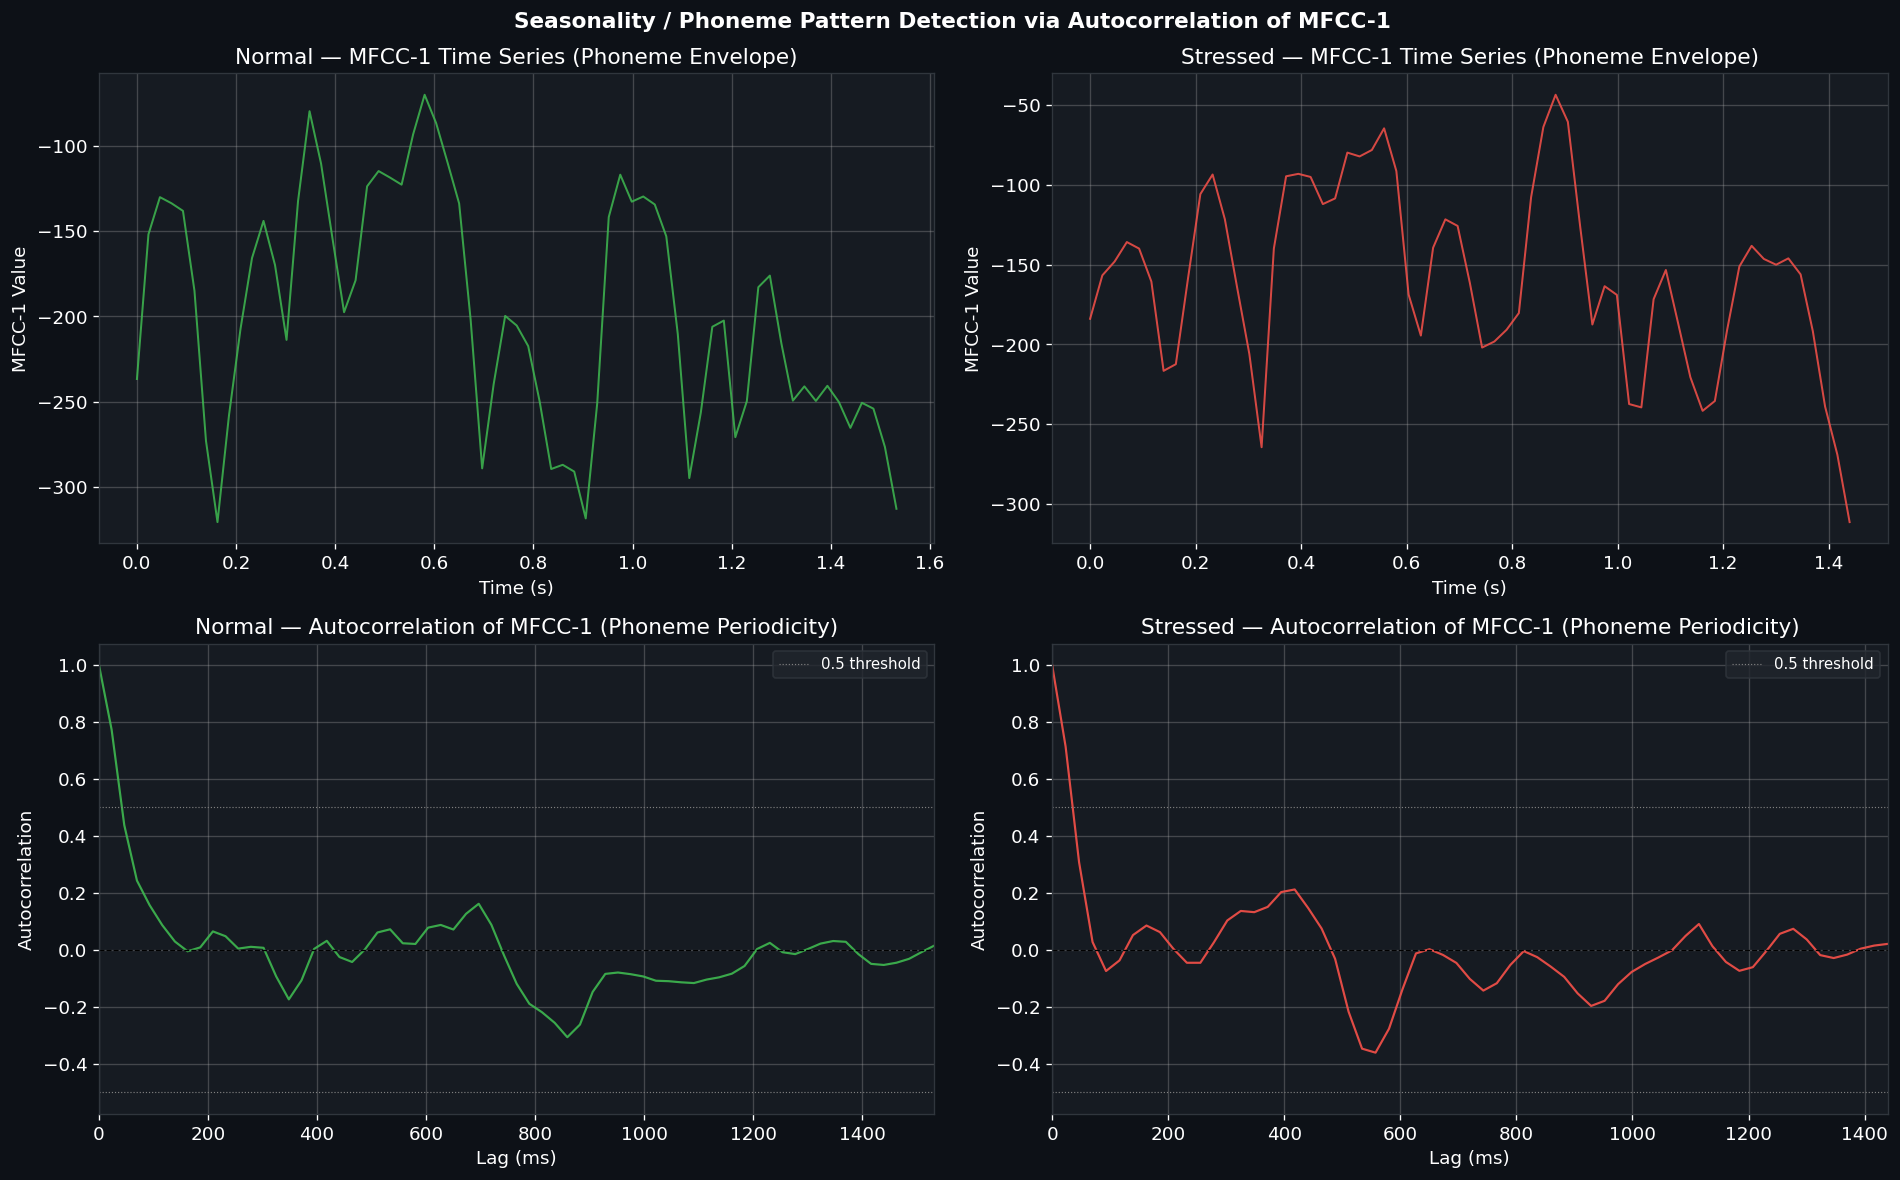

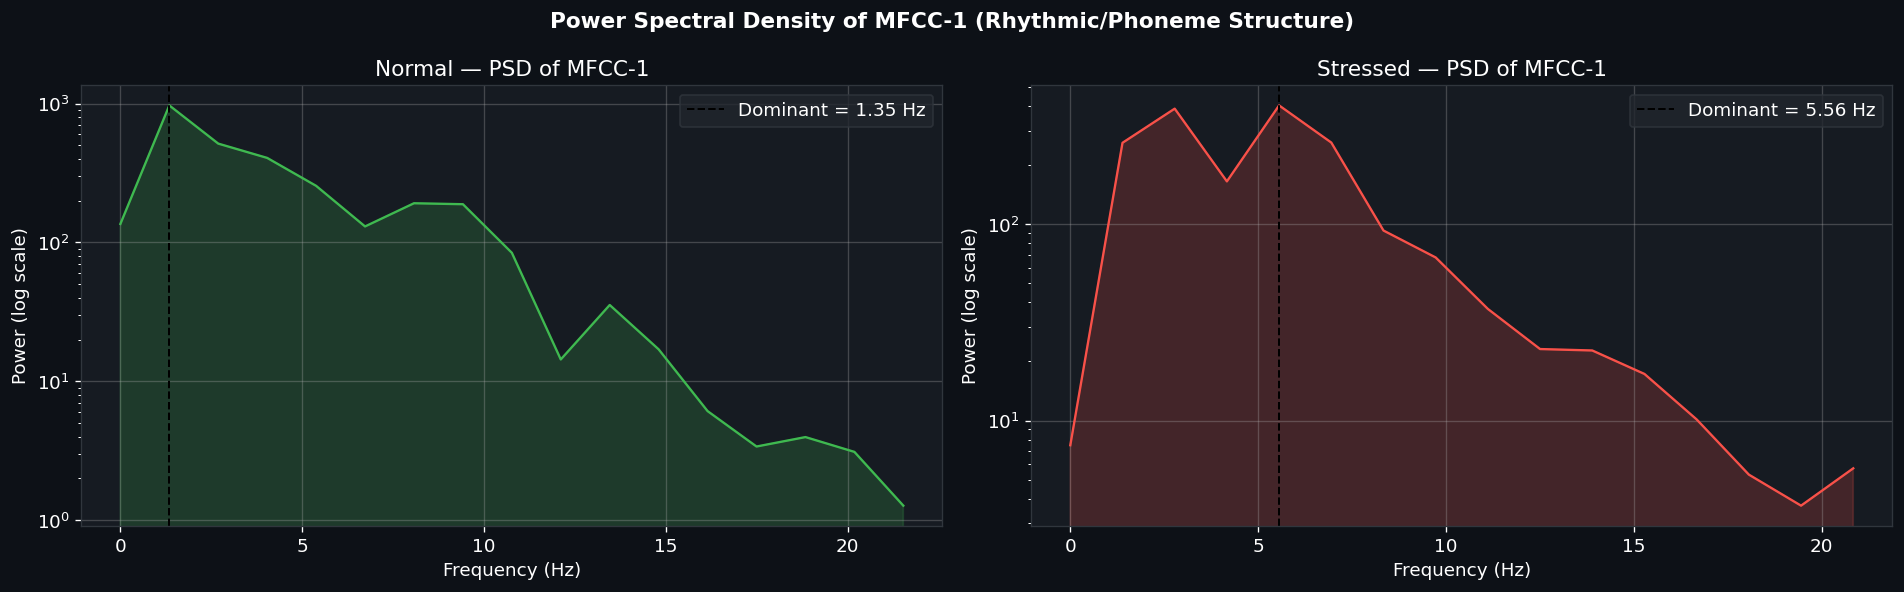

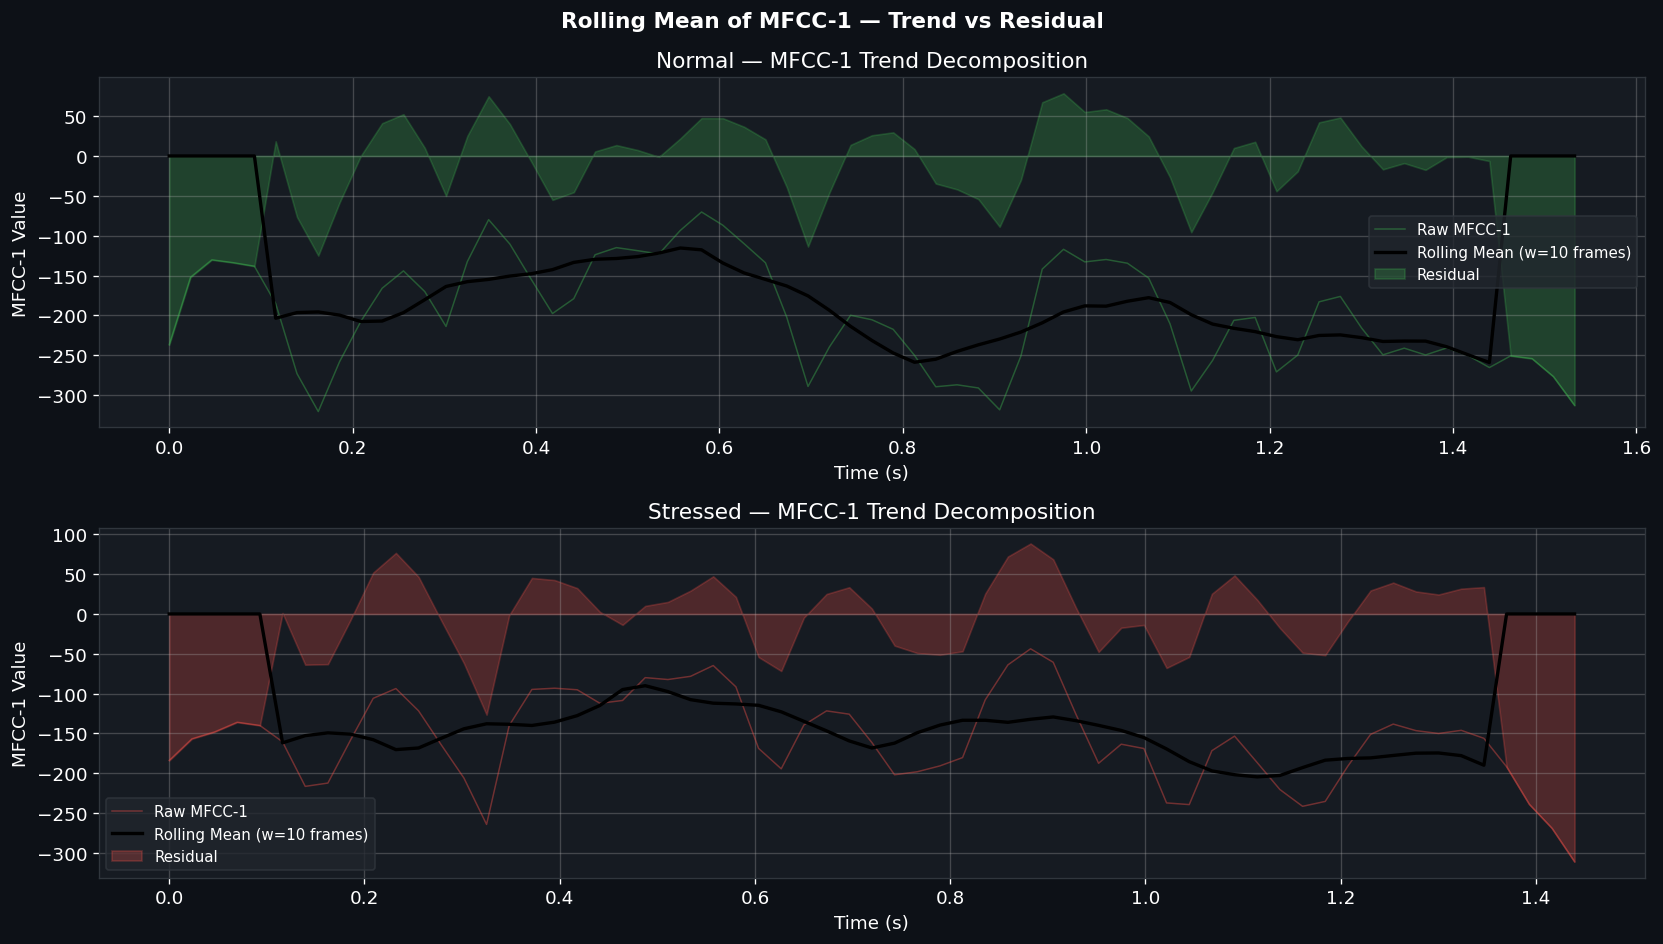

In [16]:
from scipy import signal as scipy_signal
import pandas as pd

def autocorrelation(series):
    series   = series - np.mean(series)
    acf_full = np.correlate(series, series, mode='full')
    acf      = acf_full[len(acf_full)//2:]
    acf      = acf / acf[0]
    return acf

mfcc1_n = mfcc_normal[0]
mfcc1_s = mfcc_stressed[0]

# ── Autocorrelation of MFCC-1 ────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Seasonality / Phoneme Pattern Detection via Autocorrelation of MFCC-1',
             fontsize=13, fontweight='bold')

# Define a limit for the number of frames to display in autocorrelation plots
# The original code implicitly assumed at least 80 frames, but audio samples might be shorter.
display_lag_limit_frames = 80 # The original intended limit

for col, (mfcc1, label, color) in enumerate([
    (mfcc1_n, 'Normal',   '#3fb950'),
    (mfcc1_s, 'Stressed', '#f85149'),
]):
    times = librosa.frames_to_time(np.arange(len(mfcc1)), sr=SR, hop_length=HOP_LENGTH)
    ax_top = axes[0][col]
    ax_top.plot(times, mfcc1, color=color, linewidth=1.2, alpha=0.85)
    ax_top.set_title(f'{label} — MFCC-1 Time Series (Phoneme Envelope)')
    ax_top.set_xlabel('Time (s)'); ax_top.set_ylabel('MFCC-1 Value'); ax_top.grid(alpha=0.3)

    acf    = autocorrelation(mfcc1)
    lags   = np.arange(len(acf))
    lag_ms = (lags * HOP_LENGTH / SR) * 1000

    # Determine the actual number of frames to plot, respecting the array length
    plot_until_idx = min(display_lag_limit_frames, len(acf))

    ax_bot = axes[1][col]
    ax_bot.plot(lag_ms[:plot_until_idx], acf[:plot_until_idx], color=color, linewidth=1.3, alpha=0.9)
    ax_bot.axhline(0,    color='black', linewidth=0.8, linestyle='--')
    ax_bot.axhline(0.5,  color='gray',  linewidth=0.7, linestyle=':', label='0.5 threshold')
    ax_bot.axhline(-0.5, color='gray',  linewidth=0.7, linestyle=':')

    # Find peaks within the plot_until_idx range
    peaks, _ = scipy_signal.find_peaks(acf[:plot_until_idx], height=0.3, distance=5)
    if len(peaks) > 0:
        # Plot up to 4 peaks found within the current plot range
        for pk in peaks[:4]:
            ax_bot.axvline(lag_ms[pk], color='black', linestyle='--', linewidth=0.9, alpha=0.6)
        ax_bot.scatter(lag_ms[peaks[:4]], acf[peaks[:4]], color='black', zorder=5, s=50,
                       label=f'Peaks ≈ {lag_ms[peaks[0]]:.0f}ms')
    ax_bot.set_title(f'{label} — Autocorrelation of MFCC-1 (Phoneme Periodicity)')
    ax_bot.set_xlabel('Lag (ms)'); ax_bot.set_ylabel('Autocorrelation')
    ax_bot.legend(fontsize=9); ax_bot.grid(alpha=0.3);
    # Set x-limit to the actual maximum lag plotted or the intended limit if it exists
    if plot_until_idx > 0:
        ax_bot.set_xlim([0, lag_ms[plot_until_idx - 1]])
    else: # Handle case where plot_until_idx is 0 (shouldn't happen with current data)
        ax_bot.set_xlim([0, display_lag_limit_frames * HOP_LENGTH / SR * 1000]) # Fallback to original intended max if no data
plt.tight_layout(); plt.show()

# ── Power Spectral Density of MFCC-1 ─────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Power Spectral Density of MFCC-1 (Rhythmic/Phoneme Structure)',
             fontsize=13, fontweight='bold')

for ax, (mfcc1, label, color) in zip(axes, [
    (mfcc1_n, 'Normal',   '#3fb950'),
    (mfcc1_s, 'Stressed', '#f85149'),
]):
    freqs, psd = scipy_signal.welch(mfcc1, fs=SR/HOP_LENGTH, nperseg=min(32, len(mfcc1)//2))
    ax.semilogy(freqs, psd, color=color, linewidth=1.4)
    ax.fill_between(freqs, psd, alpha=0.2, color=color)
    dom_freq = freqs[np.argmax(psd)]
    ax.axvline(dom_freq, color='black', linestyle='--', linewidth=1.2,
               label=f'Dominant = {dom_freq:.2f} Hz')
    ax.set_title(f'{label} — PSD of MFCC-1')
    ax.set_xlabel('Frequency (Hz)'); ax.set_ylabel('Power (log scale)')
    ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# ── Rolling Mean Decomposition ────────────────────────────────────────────────
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
fig.suptitle('Rolling Mean of MFCC-1 — Trend vs Residual', fontsize=13, fontweight='bold')
WINDOW = 10

for ax, (mfcc1, label, color) in zip(axes, [
    (mfcc1_n, 'Normal',   '#3fb950'),
    (mfcc1_s, 'Stressed', '#f85149'),
]):
    times     = librosa.frames_to_time(np.arange(len(mfcc1)), sr=SR, hop_length=HOP_LENGTH)
    roll_mean = pd.Series(mfcc1).rolling(WINDOW, center=True).mean().values
    residual  = mfcc1 - np.nan_to_num(roll_mean)

    ax.plot(times, mfcc1, color=color, alpha=0.4, linewidth=0.9, label='Raw MFCC-1')
    ax.plot(times, np.nan_to_num(roll_mean), color='black', linewidth=2.0,
            label=f'Rolling Mean (w={WINDOW} frames)')
    ax.fill_between(times, residual, alpha=0.25, color=color, label='Residual')
    ax.set_title(f'{label} — MFCC-1 Trend Decomposition')
    ax.set_xlabel('Time (s)'); ax.set_ylabel('MFCC-1 Value')
    ax.legend(fontsize=9); ax.grid(alpha=0.3)
plt.tight_layout(); plt.show()

## 📐 Cell 11e — Variance & Frequency Jitter Analysis

[Normal]
  Global variance: 1686.2620
  Kurtosis      : 21.4956
  Skewness      : -2.6292

[Stressed]
  Global variance: 1218.3708
  Kurtosis      : 19.0254
  Skewness      : -2.0966



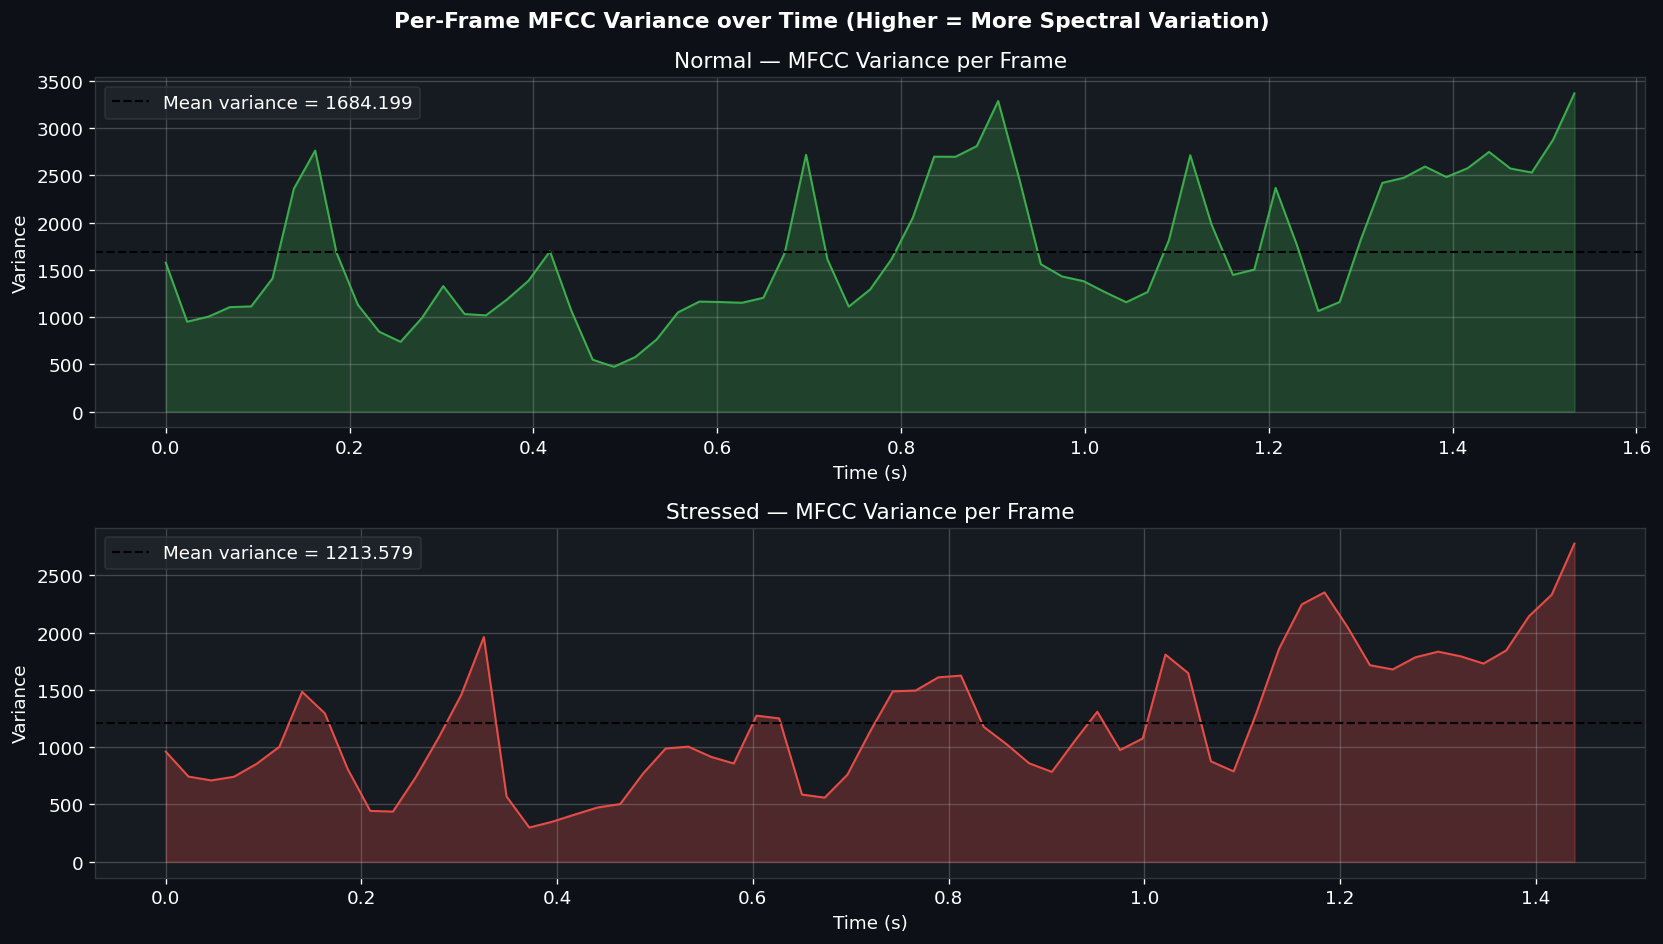

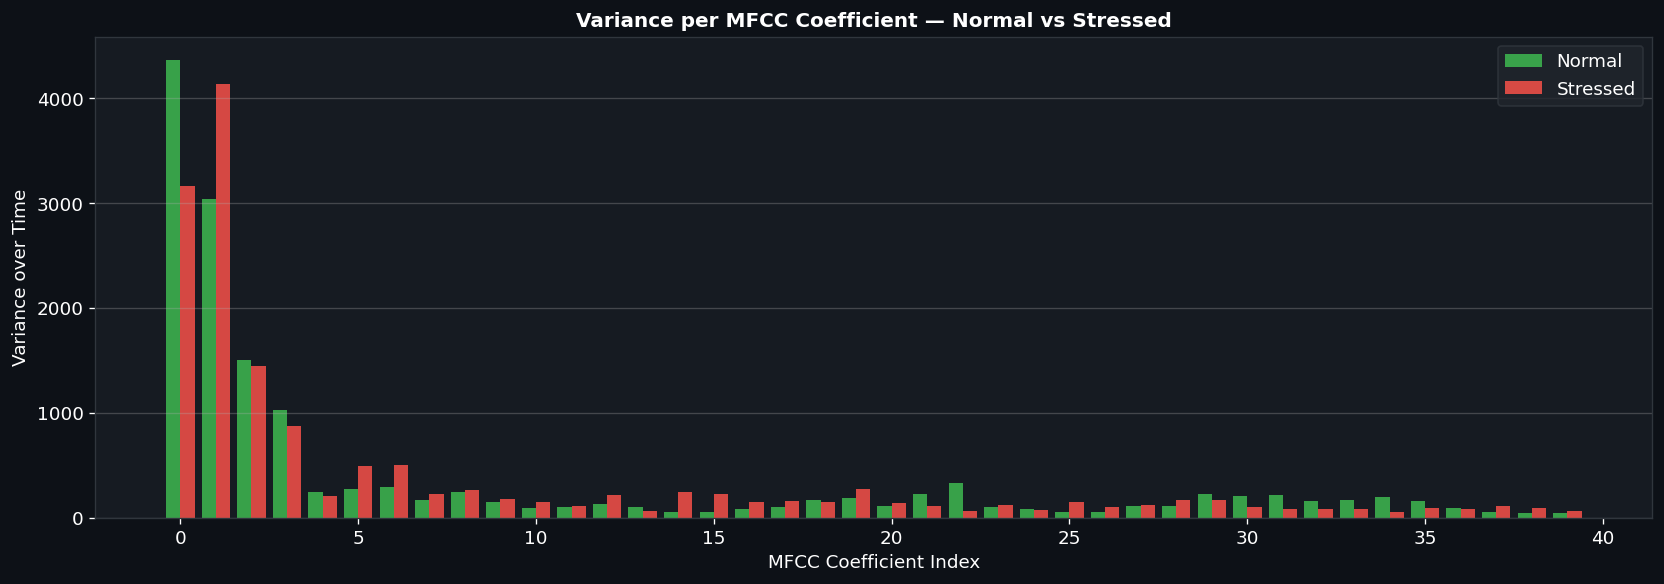

[Normal] Pitch Jitter: 10.3422%  |  F0 mean: 252.24 Hz  |  F0 std: 76.34 Hz
[Stressed] Pitch Jitter: 12.0326%  |  F0 mean: 262.86 Hz  |  F0 std: 74.45 Hz


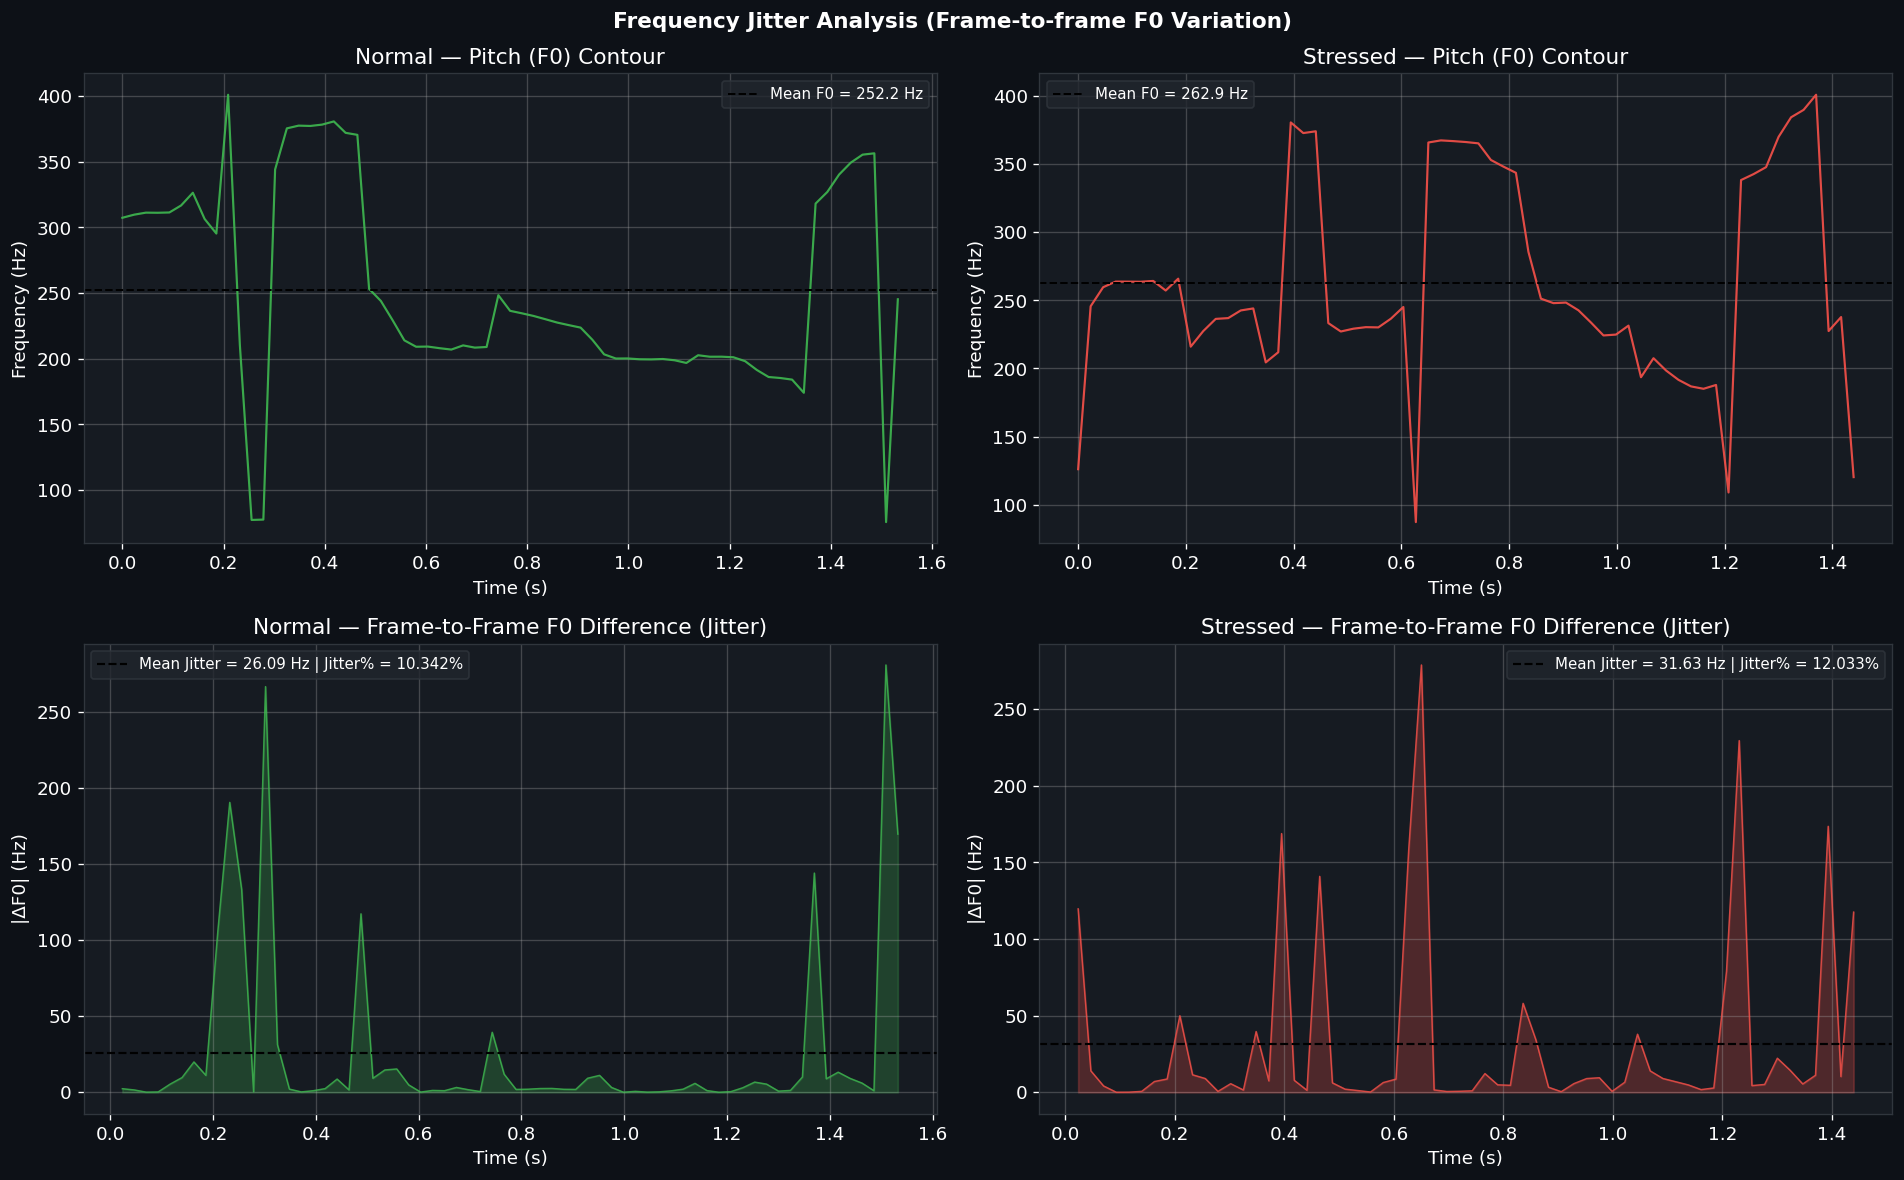

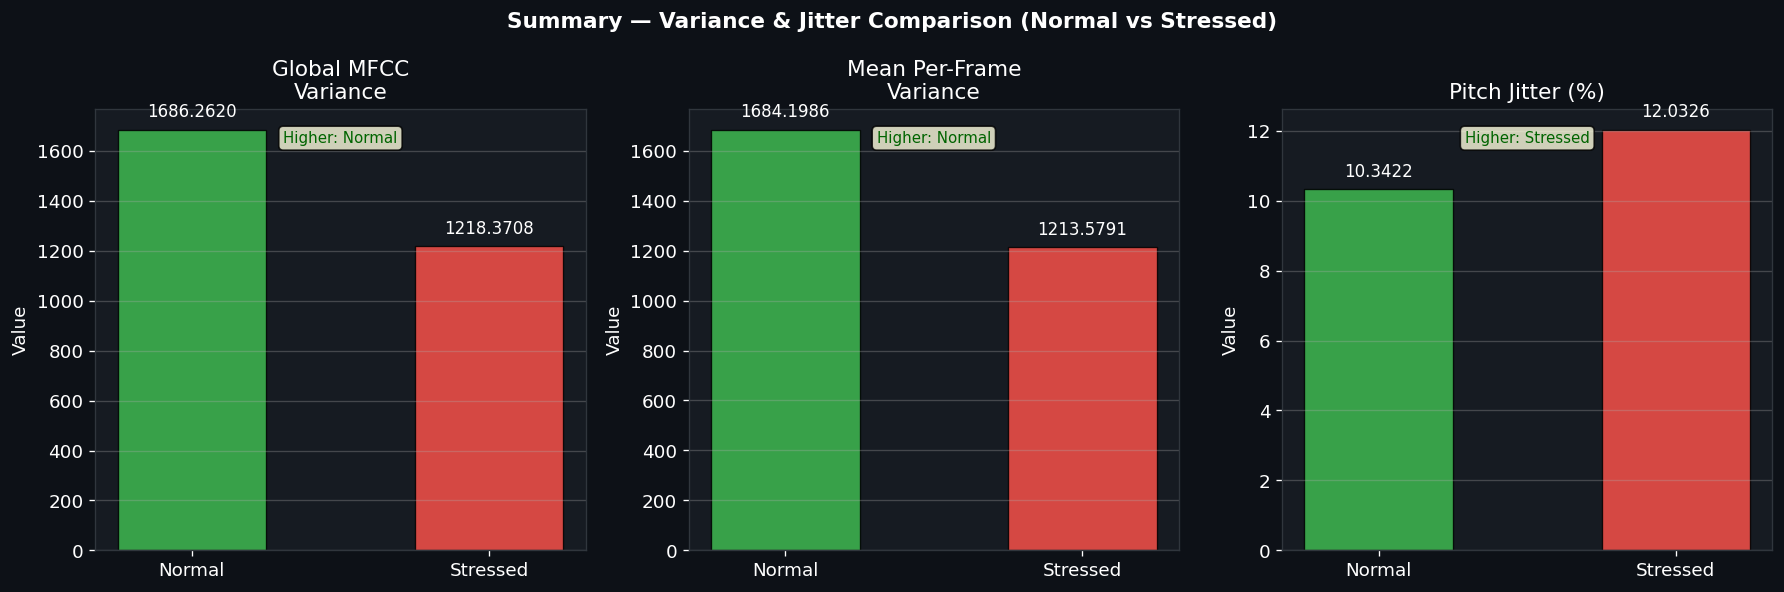

In [17]:
from scipy.stats import kurtosis as sp_kurtosis, skew as sp_skew

# ── Per-frame and per-coefficient variance ────────────────────────────────────
variance_data = {}
for label, mfcc in [('Normal', mfcc_normal), ('Stressed', mfcc_stressed)]:
    variance_data[label] = {
        'per_frame'   : np.var(mfcc, axis=0),
        'per_coeff'   : np.var(mfcc, axis=1),
        'global'      : np.var(mfcc),
        'kurtosis'    : sp_kurtosis(mfcc.flatten()),
        'skewness'    : sp_skew(mfcc.flatten()),
    }
    print(f"[{label}]")
    print(f"  Global variance: {variance_data[label]['global']:.4f}")
    print(f"  Kurtosis      : {variance_data[label]['kurtosis']:.4f}")
    print(f"  Skewness      : {variance_data[label]['skewness']:.4f}\n")

# ── Per-Frame Variance over Time ──────────────────────────────────────────────
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
fig.suptitle('Per-Frame MFCC Variance over Time (Higher = More Spectral Variation)',
             fontsize=13, fontweight='bold')

for ax, (label, color) in zip(axes, [('Normal', '#3fb950'), ('Stressed', '#f85149')]):
    var_pf = variance_data[label]['per_frame']
    times  = librosa.frames_to_time(np.arange(len(var_pf)), sr=SR, hop_length=HOP_LENGTH)
    ax.plot(times, var_pf, color=color, linewidth=1.2, alpha=0.9)
    ax.fill_between(times, var_pf, alpha=0.25, color=color)
    ax.axhline(np.mean(var_pf), color='black', linestyle='--',
               linewidth=1.3, label=f'Mean variance = {np.mean(var_pf):.3f}')
    ax.set_title(f'{label} — MFCC Variance per Frame')
    ax.set_xlabel('Time (s)'); ax.set_ylabel('Variance')
    ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# ── Per-Coefficient Variance ──────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 5))
x = np.arange(40)
ax.bar(x - 0.2, variance_data['Normal']['per_coeff'],   0.4,
       label='Normal',   color='#3fb950', alpha=0.85)
ax.bar(x + 0.2, variance_data['Stressed']['per_coeff'], 0.4,
       label='Stressed', color='#f85149', alpha=0.85)
ax.set_title('Variance per MFCC Coefficient — Normal vs Stressed', fontsize=12, fontweight='bold')
ax.set_xlabel('MFCC Coefficient Index'); ax.set_ylabel('Variance over Time')
ax.legend(); ax.grid(axis='y', alpha=0.3)
plt.tight_layout(); plt.show()

# ── Jitter Analysis ───────────────────────────────────────────────────────────
def compute_jitter(y, sr, hop_length, fmin=75, fmax=400):
    f0     = librosa.yin(y, fmin=fmin, fmax=fmax, sr=sr, hop_length=hop_length)
    voiced = f0[f0 >= fmin]
    if len(voiced) < 2:
        return 0.0, f0
    diffs  = np.abs(np.diff(voiced))
    jitter = np.mean(diffs) / np.mean(voiced) * 100
    return jitter, f0

jitter_vals, f0_vals = {}, {}
for label, y in [('Normal', y_n_proc), ('Stressed', y_s_proc)]:
    j, f0 = compute_jitter(y, SR, HOP_LENGTH)
    jitter_vals[label] = j
    f0_vals[label]     = f0
    voiced = f0[f0 >= 75]
    print(f"[{label}] Pitch Jitter: {j:.4f}%  |  F0 mean: {np.mean(voiced):.2f} Hz  |  F0 std: {np.std(voiced):.2f} Hz")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Frequency Jitter Analysis (Frame-to-frame F0 Variation)',
             fontsize=13, fontweight='bold')

for col, (label, color) in enumerate([('Normal', '#3fb950'), ('Stressed', '#f85149')]):
    f0     = f0_vals[label]
    voiced = f0.copy().astype(float)
    voiced[voiced < 75] = np.nan
    times  = librosa.frames_to_time(np.arange(len(f0)), sr=SR, hop_length=HOP_LENGTH)
    diffs  = np.abs(np.diff(np.nan_to_num(voiced)))

    ax1 = axes[0][col]
    ax1.plot(times, voiced, color=color, linewidth=1.3, alpha=0.9)
    ax1.axhline(np.nanmean(voiced), color='black', linestyle='--',
                linewidth=1.2, label=f'Mean F0 = {np.nanmean(voiced):.1f} Hz')
    ax1.set_title(f'{label} — Pitch (F0) Contour')
    ax1.set_xlabel('Time (s)'); ax1.set_ylabel('Frequency (Hz)')
    ax1.legend(fontsize=9); ax1.grid(alpha=0.3)

    ax2 = axes[1][col]
    ax2.plot(times[1:], diffs, color=color, linewidth=0.9, alpha=0.8)
    ax2.fill_between(times[1:], diffs, alpha=0.25, color=color)
    ax2.axhline(np.mean(diffs), color='black', linestyle='--', linewidth=1.3,
                label=f'Mean Jitter = {np.mean(diffs):.2f} Hz | Jitter% = {jitter_vals[label]:.3f}%')
    ax2.set_title(f'{label} — Frame-to-Frame F0 Difference (Jitter)')
    ax2.set_xlabel('Time (s)'); ax2.set_ylabel('|ΔF0| (Hz)')
    ax2.legend(fontsize=9); ax2.grid(alpha=0.3)

plt.tight_layout(); plt.show()

# ── Summary variance + jitter bar chart ──────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Summary — Variance & Jitter Comparison (Normal vs Stressed)',
             fontsize=13, fontweight='bold')

metrics = {
    'Global MFCC\nVariance'    : [variance_data['Normal']['global'],     variance_data['Stressed']['global']],
    'Mean Per-Frame\nVariance' : [np.mean(variance_data['Normal']['per_frame']), np.mean(variance_data['Stressed']['per_frame'])],
    'Pitch Jitter (%)'          : [jitter_vals['Normal'], jitter_vals['Stressed']],
}
bar_colors = ['#3fb950', '#f85149']
for ax, (metric, vals) in zip(axes, metrics.items()):
    bars = ax.bar(['Normal', 'Stressed'], vals, color=bar_colors, alpha=0.85,
                  width=0.5, edgecolor='black', linewidth=0.8)
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(vals)*0.02,
                f'{val:.4f}', ha='center', va='bottom', fontsize=10)
    ax.set_title(metric); ax.set_ylabel('Value'); ax.grid(axis='y', alpha=0.3)
    higher = 'Stressed' if vals[1] > vals[0] else 'Normal'
    ax.text(0.5, 0.95, f'Higher: {higher}', ha='center', va='top',
            transform=ax.transAxes, fontsize=9, color='darkgreen',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
plt.tight_layout(); plt.show()


## 🔧 Cell 12 — Full Feature Extraction Function (187 Features)

In [18]:
def extract_all_features(filepath, n_mfcc=40, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """
    Extract 187 acoustic features per audio file:
      MFCC(40) mean+std        = 80
      MFCC Delta mean+std      = 80
      ZCR mean+std             = 2
      Spectral Centroid        = 2
      Spectral Rolloff         = 2
      Spectral Bandwidth       = 2
      Spectral Contrast (7b)   = 14
      RMS Energy               = 2
      Pitch F0 mean+std+var    = 3
    """
    try:
        y, _ = librosa.load(filepath, sr=sr)
        y, _ = librosa.effects.trim(y, top_db=20)
        y    = librosa.util.normalize(y)
        if len(y) < sr * 0.1:
            return None
        feats = []

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        feats.extend(mfcc.mean(axis=1))
        feats.extend(mfcc.std(axis=1))

        mfcc_delta = librosa.feature.delta(mfcc)
        feats.extend(mfcc_delta.mean(axis=1))
        feats.extend(mfcc_delta.std(axis=1))

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length)
        feats.append(float(zcr.mean()))
        feats.append(float(zcr.std()))

        sc = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
        feats.append(float(sc.mean()))
        feats.append(float(sc.std()))

        sr_feat = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
        feats.append(float(sr_feat.mean()))
        feats.append(float(sr_feat.std()))

        sb = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
        feats.append(float(sb.mean()))
        feats.append(float(sb.std()))

        contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
        feats.extend(contrast.mean(axis=1))
        feats.extend(contrast.std(axis=1))

        rms = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)
        feats.append(float(rms.mean()))
        feats.append(float(rms.std()))

        f0, _, _ = librosa.pyin(y, fmin=50, fmax=400, sr=sr, hop_length=hop_length)
        f0_clean = f0[~np.isnan(f0)] if f0 is not None else np.array([0.0])
        if len(f0_clean) == 0:
            f0_clean = np.array([0.0])
        feats.append(float(np.mean(f0_clean)))
        feats.append(float(np.std(f0_clean)))
        feats.append(float(np.var(f0_clean)))

        return np.array(feats, dtype=np.float32)
    except Exception as e:
        print(f'Error: {os.path.basename(filepath)}: {e}')
        return None

test_features = extract_all_features(normal_file)
print(f'Feature vector shape: {test_features.shape}')
print(f'Min: {test_features.min():.3f} | Max: {test_features.max():.3f} | Mean: {test_features.mean():.3f}')

Feature vector shape: (187,)
Min: -197.952 | Max: 4050.480 | Mean: 87.001


## ⚙️ Cell 13 — Extract Features for ALL Files (Full Dataset)

In [19]:
print(f"Extracting features from {len(df_meta)} audio files...")
print("(May take 3-8 minutes — pyin pitch extraction is compute-heavy)\n")

feature_list, label_list, failed = [], [], 0

for _, row in tqdm(df_meta.iterrows(), total=len(df_meta), desc='Extracting Features'):
    feats = extract_all_features(row['filepath'])
    if feats is not None:
        feature_list.append(feats)
        label_list.append(row['stress_label'])
    else:
        failed += 1

X     = np.array(feature_list)
y_raw = np.array(label_list)
le    = LabelEncoder()
y     = le.fit_transform(y_raw)

print(f"\nFeature extraction complete!")
print(f"  Dataset shape : X={X.shape}, y={y.shape}")
print(f"  Failed files  : {failed}")
print(f"  Class mapping : {dict(zip(le.classes_, le.transform(le.classes_)))}")
print(f"  normal={np.sum(y_raw=='normal')}, stressed={np.sum(y_raw=='stressed')}")

Extracting features from 2880 audio files...
(May take 3-8 minutes — pyin pitch extraction is compute-heavy)



Extracting Features: 100%|██████████| 2880/2880 [11:09<00:00,  4.30it/s]


Feature extraction complete!
  Dataset shape : X=(2880, 187), y=(2880,)
  Failed files  : 0
  Class mapping : {np.str_('normal'): np.int64(0), np.str_('stressed'): np.int64(1)}
  normal=1344, stressed=1536


## 📊 Cell 14 — Feature Comparison: Normal vs Stressed

Key Feature Comparison — Normal vs Stressed:
             MFCC_1_mean            MFCC_2_mean            MFCC_3_mean            ZCR_mean        SpCentroid_mean             RMS_mean         Pitch_mean               Pitch_var             
                    mean        std        mean        std        mean        std     mean    std            mean         std     mean    std        mean        std         mean          std
stress_label                                                                                                                                                                                  
normal       -190.990997  33.404999   91.877998  24.499001  -10.866000  21.142000    0.111  0.031     2170.154053  349.286011    0.138  0.034  194.643997  66.989998  1212.056030  1524.692993
stressed     -184.938004  34.257999   76.005997  24.742001  -18.570999  19.438999    0.131  0.034     2467.665039  356.334991    0.132  0.033  231.992004  76.787003  1656.442017  1705.443970


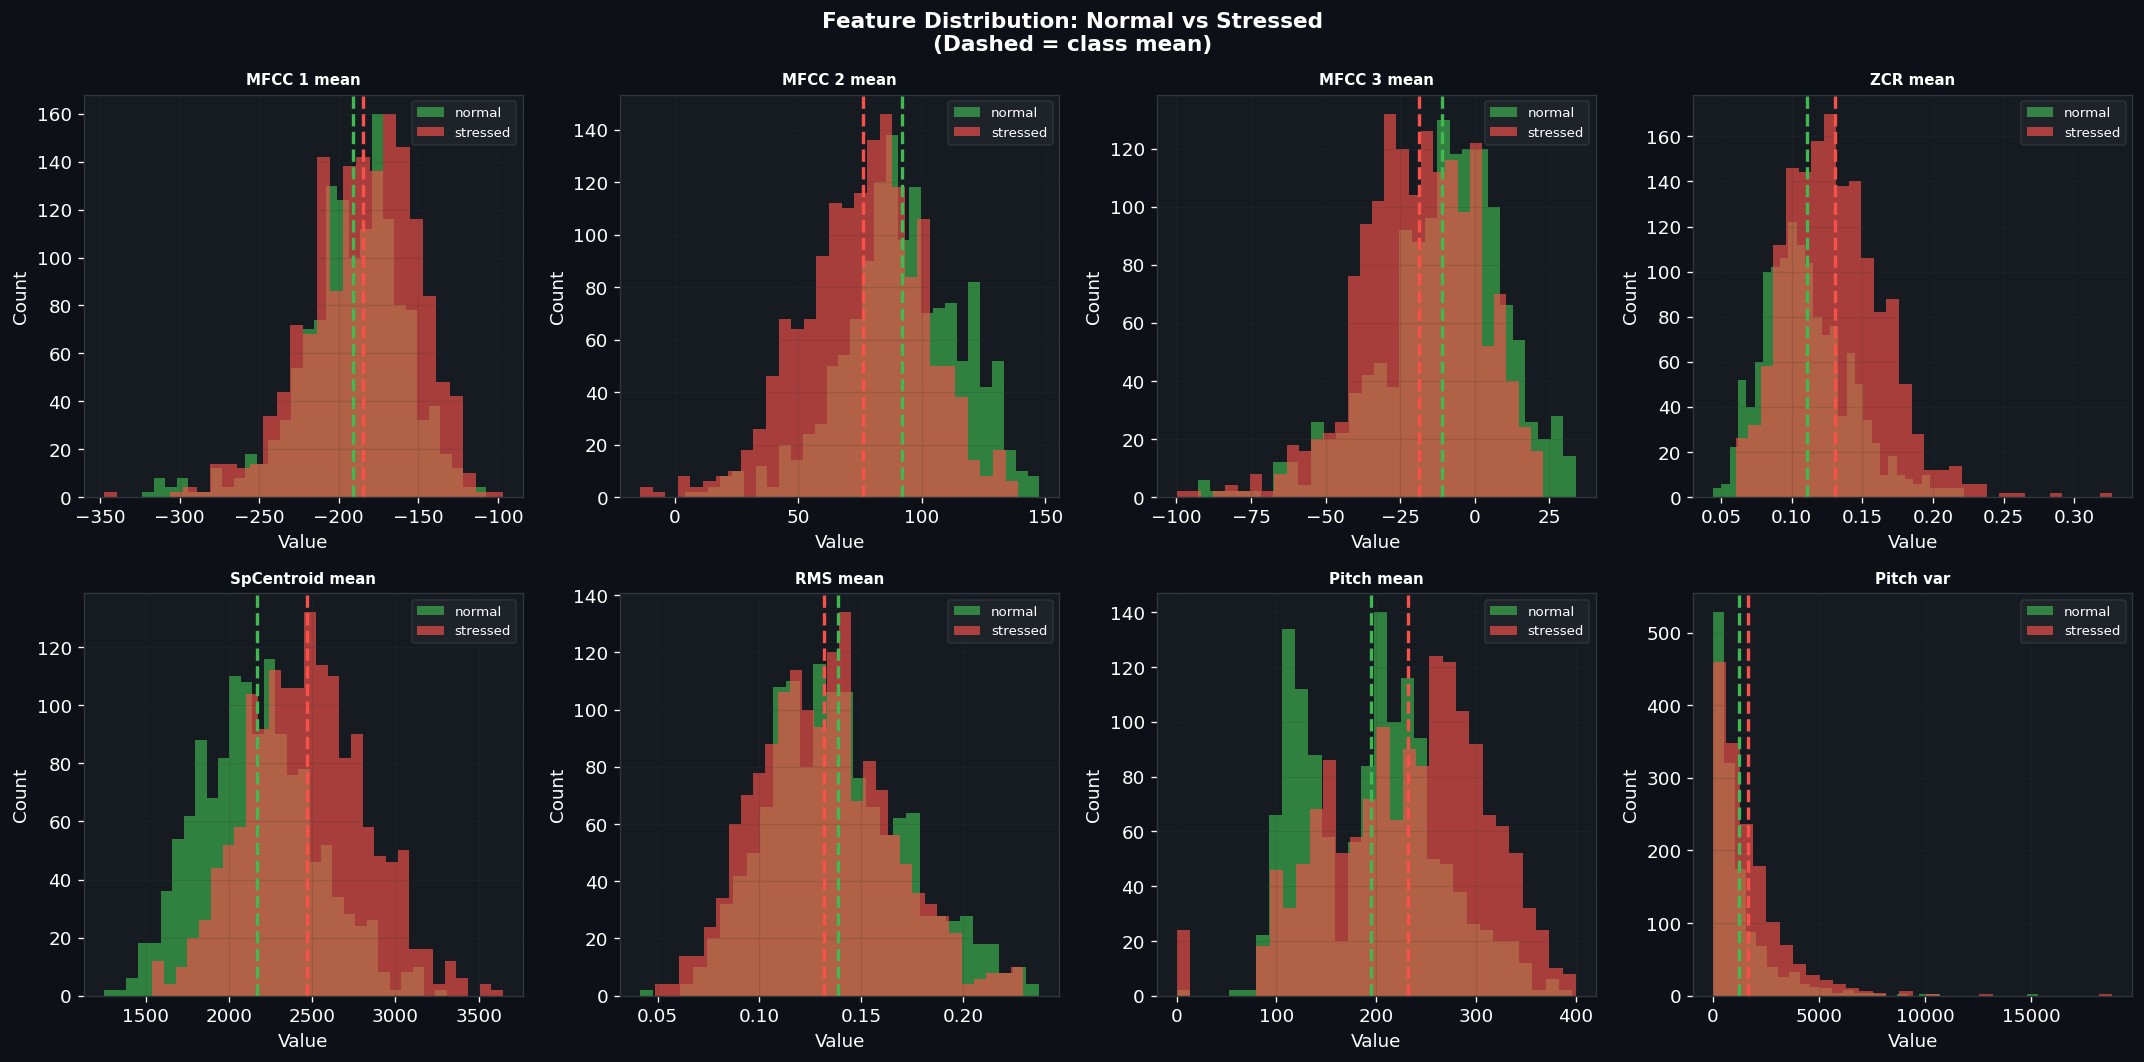

In [20]:
feat_names = (
    [f'MFCC_{i+1}_mean' for i in range(40)] + [f'MFCC_{i+1}_std' for i in range(40)] +
    [f'MFCC_delta_{i+1}_mean' for i in range(40)] + [f'MFCC_delta_{i+1}_std' for i in range(40)] +
    ['ZCR_mean','ZCR_std','SpCentroid_mean','SpCentroid_std',
     'SpRolloff_mean','SpRolloff_std','SpBandwidth_mean','SpBandwidth_std'] +
    [f'SpContrast_{i+1}_mean' for i in range(7)] + [f'SpContrast_{i+1}_std' for i in range(7)] +
    ['RMS_mean','RMS_std','Pitch_mean','Pitch_std','Pitch_var']
)

n_feats = X.shape[1]
df_features = pd.DataFrame(X, columns=feat_names[:n_feats])
df_features['stress_label'] = y_raw

key_features = ['MFCC_1_mean','MFCC_2_mean','MFCC_3_mean',
                'ZCR_mean','SpCentroid_mean','RMS_mean','Pitch_mean','Pitch_var']

print("Key Feature Comparison — Normal vs Stressed:")
print(df_features.groupby('stress_label')[key_features].agg(['mean','std']).round(3).to_string())

fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()
colors = {'normal': '#3fb950', 'stressed': '#f85149'}

for i, feat in enumerate(key_features):
    ax = axes[i]
    for label in ['normal', 'stressed']:
        data = df_features[df_features['stress_label'] == label][feat]
        ax.hist(data, bins=30, alpha=0.65, label=label, color=colors[label], edgecolor='none')
        ax.axvline(data.mean(), color=colors[label], linewidth=2, linestyle='--')
    ax.set_title(feat.replace('_', ' '), fontsize=9, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.15, color='#30363d')

fig.suptitle('Feature Distribution: Normal vs Stressed\n(Dashed = class mean)', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.savefig('feature_comparison.png', bbox_inches='tight')
plt.show()

## 🌡️ Cell 15 — Feature Correlation Heatmap

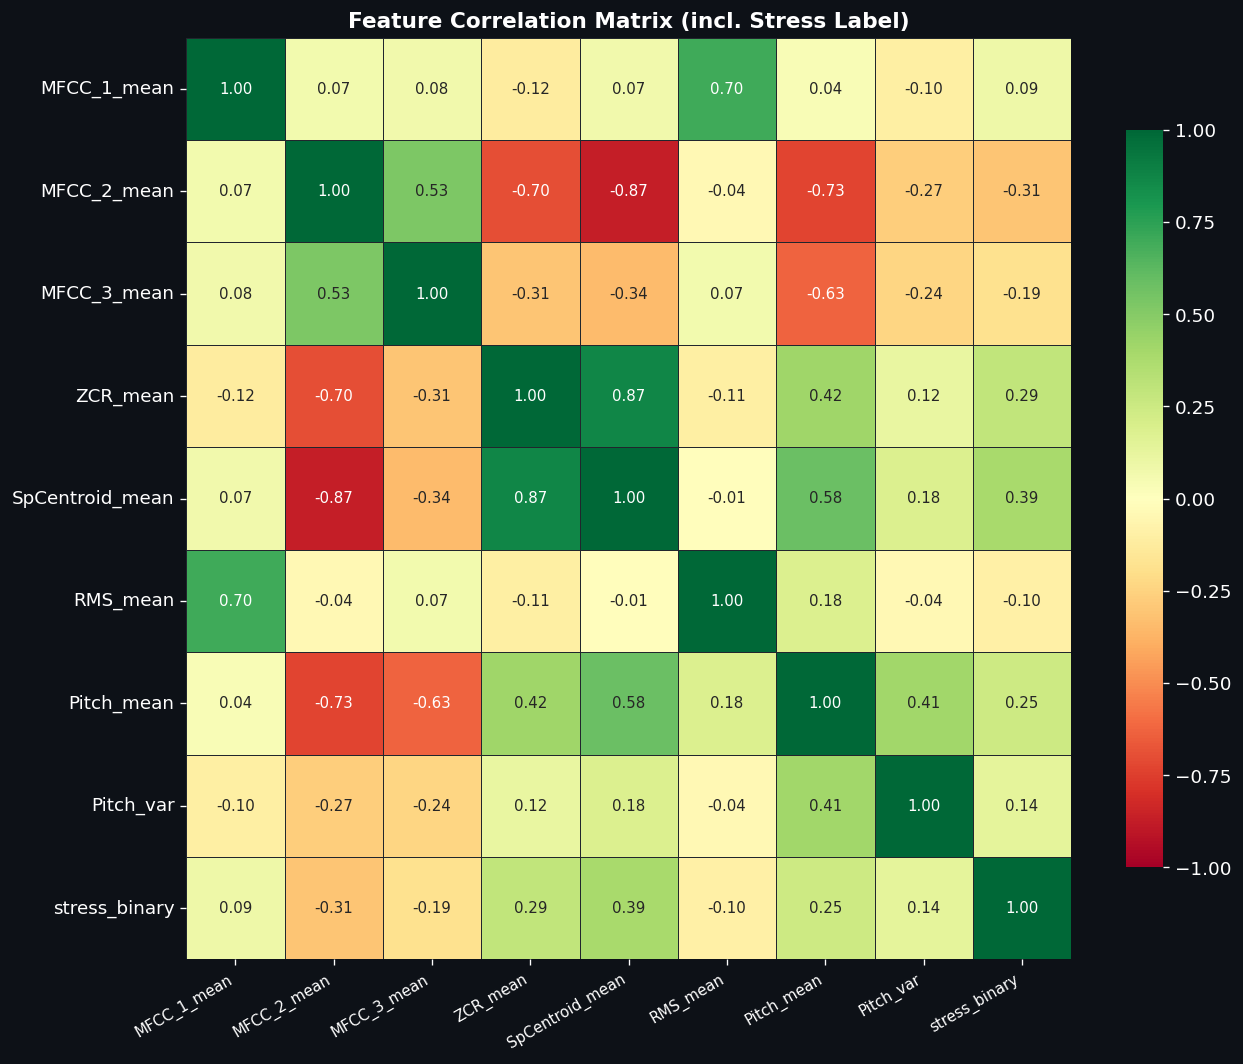


Top features correlated with STRESS:
  [UP  ] SpCentroid_mean                    : r = +0.388
  [DOWN] MFCC_2_mean                        : r = -0.306
  [UP  ] ZCR_mean                           : r = +0.290
  [UP  ] Pitch_mean                         : r = +0.249
  [DOWN] MFCC_3_mean                        : r = -0.187
  [UP  ] Pitch_var                          : r = +0.135
  [DOWN] RMS_mean                           : r = -0.098
  [UP  ] MFCC_1_mean                        : r = +0.089


In [21]:
df_corr = df_features[key_features].copy()
df_corr['stress_binary'] = (df_features['stress_label'] == 'stressed').astype(int)
corr_matrix = df_corr.corr()

fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax,
            linewidths=0.5, linecolor='#21262d',
            annot_kws={'size': 9}, vmin=-1, vmax=1, cbar_kws={'shrink': 0.8})
ax.set_title('Feature Correlation Matrix (incl. Stress Label)', fontweight='bold', fontsize=13)
plt.xticks(rotation=30, ha='right', fontsize=9)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', bbox_inches='tight')
plt.show()

stress_corr = corr_matrix['stress_binary'].drop('stress_binary').sort_values(key=abs, ascending=False)
print("\nTop features correlated with STRESS:")
for feat, val in stress_corr.head(8).items():
    direction = 'UP  ' if val > 0 else 'DOWN'
    print(f"  [{direction}] {feat:<35}: r = {val:+.3f}")

## ✂️ Cell 16 — Train/Test Split & Feature Scaling

In [22]:
X_clean = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y, test_size=0.2, random_state=42, stratify=y
)

scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

print("Data split and scaled:")
print(f"  X_train: {X_train.shape}  |  X_test: {X_test.shape}")
print(f"  Train balance: {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"  Test  balance: {dict(zip(*np.unique(y_test,  return_counts=True)))}")
print(f"  X_train mean (should be ~0): {X_train.mean():.6f}")
print(f"  X_train std  (should be ~1): {X_train.std():.6f}")

Data split and scaled:
  X_train: (2304, 187)  |  X_test: (576, 187)
  Train balance: {np.int64(0): np.int64(1075), np.int64(1): np.int64(1229)}
  Test  balance: {np.int64(0): np.int64(269), np.int64(1): np.int64(307)}
  X_train mean (should be ~0): 0.000000
  X_train std  (should be ~1): 1.000000


## 🤖 Cell 17 — Model Training: SVM, KNN, Random Forest, Gradient Boosting

In [23]:
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

classifiers = {

    'SVM (RBF Kernel)':  SVC(kernel='rbf', C=5, gamma='scale', probability=False, random_state=42),

    'SVM (Linear)':      LinearSVC(C=1, max_iter=5000, random_state=42),

    'KNN (k=7)':         KNeighborsClassifier(n_neighbors=7, metric='euclidean', weights='distance'),

    'Random Forest':     RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42, n_jobs=-1),

    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42),

}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results = {}

print('Training and evaluating classifiers...\n')
print(f'{"Model":<22} {"Train":>8} {"Test":>8} {"Prec":>8} {"Recall":>8} {"F1":>8} {"CV Mean":>9} {"CV Std":>8}')
print('-' * 85)

for name, clf in classifiers.items():

    clf.fit(X_train, y_train)

    y_pred_train = clf.predict(X_train)
    y_pred_test  = clf.predict(X_test)

    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc  = accuracy_score(y_test,  y_pred_test)
    prec      = precision_score(y_test, y_pred_test, average='weighted')
    rec       = recall_score(y_test,    y_pred_test, average='weighted')
    f1        = f1_score(y_test,        average='weighted', y_pred=y_pred_test)

    # 🔥 Faster CV (on training data only)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

    results[name] = {
        'clf': clf,
        'Train Accuracy': train_acc, # Added Train Accuracy
        'Test Accuracy': test_acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'CV Accuracy': cv_scores.mean(),
        'CV Std': cv_scores.std(), # Added CV Std
        'y_pred': y_pred_test
    }

    print(f'{name:<22} {train_acc:>8.4f} {test_acc:>8.4f} {prec:>8.4f} {rec:>8.4f} {f1:>8.4f} {cv_scores.mean():>9.4f} {cv_scores.std():>8.4f}')

print('-' * 85)

best_model_name = max(results, key=lambda k: results[k]['Test Accuracy'])
print(f"\nBEST MODEL: {best_model_name}  (Test Acc: {results[best_model_name]['Test Accuracy']:.4f})")

Training and evaluating classifiers...

Model                     Train     Test     Prec   Recall       F1   CV Mean   CV Std
-------------------------------------------------------------------------------------
SVM (RBF Kernel)         1.0000   0.9688   0.9694   0.9688   0.9688    0.9549   0.0118
SVM (Linear)             0.9206   0.8733   0.8737   0.8733   0.8733    0.8711   0.0129
KNN (k=7)                1.0000   0.9688   0.9700   0.9688   0.9688    0.9067   0.0121
Random Forest            0.9983   0.9410   0.9410   0.9410   0.9410    0.9236   0.0208
Gradient Boosting        0.9991   0.9583   0.9585   0.9583   0.9584    0.9271   0.0108
-------------------------------------------------------------------------------------

BEST MODEL: SVM (RBF Kernel)  (Test Acc: 0.9688)


## 📊 Cell 18 — Model Comparison Bar Chart

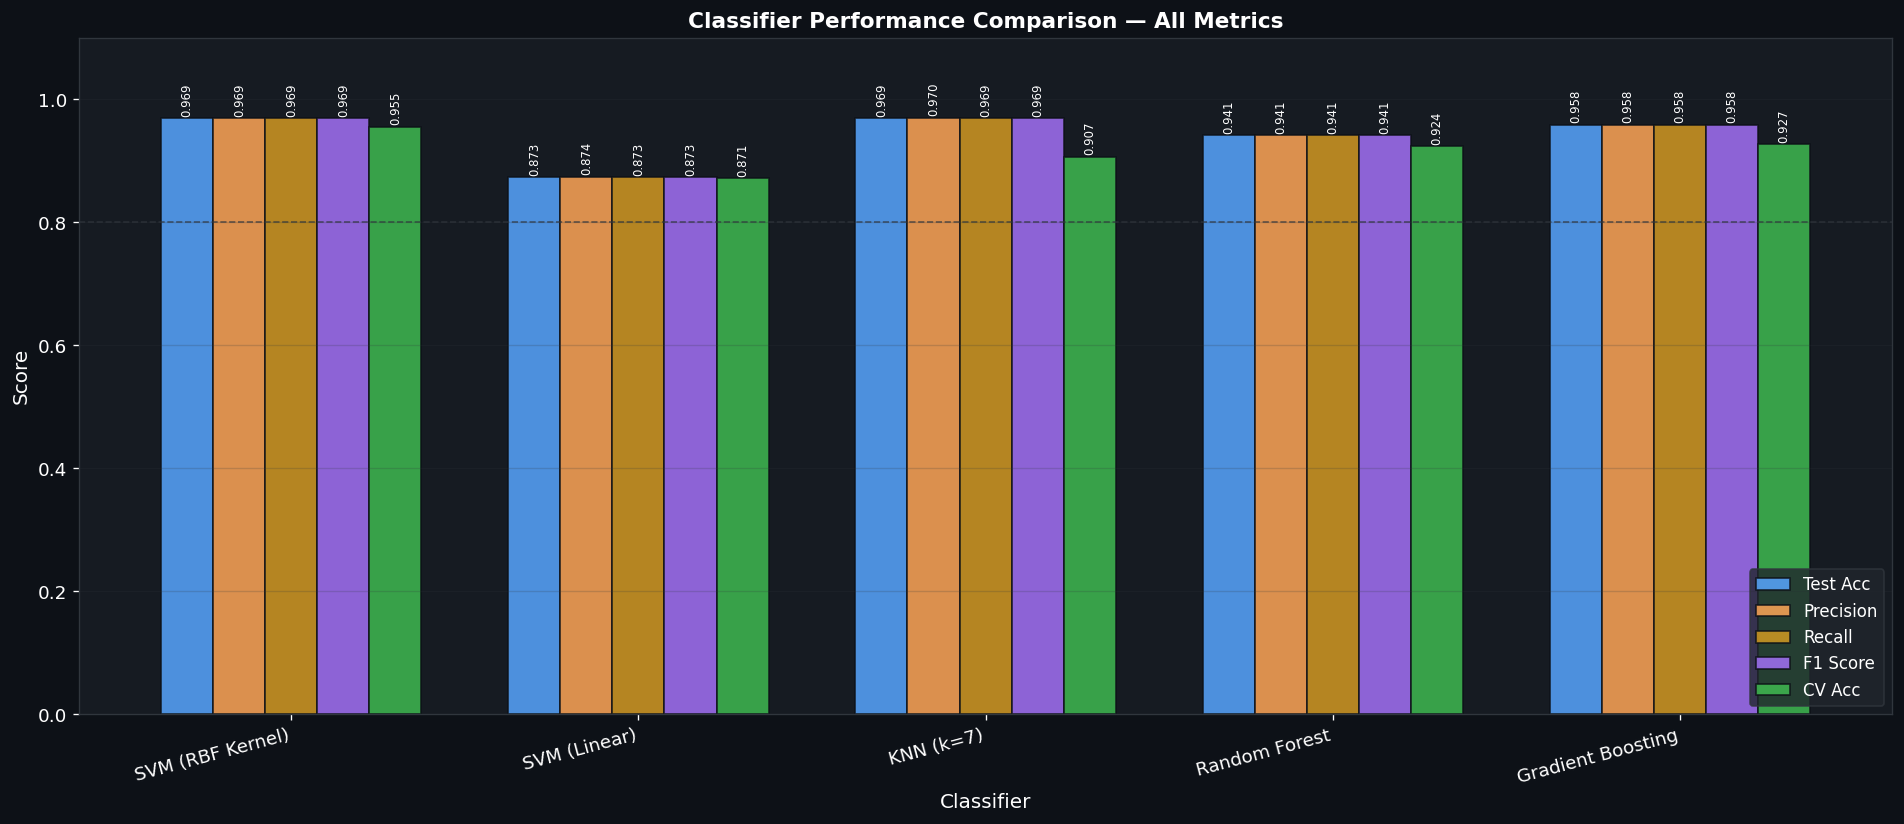

In [24]:
model_names     = list(results.keys())
metrics_to_plot = ['Test Accuracy','Precision','Recall','F1 Score', 'CV Accuracy']
metric_labels   = ['Test Acc','Precision','Recall','F1 Score', 'CV Acc']
bar_colors      = ['#58a6ff','#ffa657','#d29922','#a371f7', '#3fb950'] # Adjusted colors to match the number of metrics

x     = np.arange(len(model_names))
width = 0.15

fig, ax = plt.subplots(figsize=(16, 7))
for i, (metric, label, color) in enumerate(zip(metrics_to_plot, metric_labels, bar_colors)):
    vals = [results[m][metric] for m in model_names]
    bars = ax.bar(x + i * width, vals, width, label=label, color=color, alpha=0.85, edgecolor='#0d1117')
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003,
                f'{val:.3f}', ha='center', va='bottom', fontsize=7, color='white', rotation=90)

ax.set_xlabel('Classifier', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Classifier Performance Comparison — All Metrics', fontweight='bold', fontsize=13)
ax.set_xticks(x + width * (len(metrics_to_plot) - 1) / 2) # Adjust xticks position
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.set_ylim([0, 1.10])
ax.legend(fontsize=10, loc='lower right')
ax.axhline(y=0.8, color='#30363d', linestyle='--', linewidth=1, alpha=0.7)
ax.grid(axis='y', alpha=0.2, color='#30363d')
plt.tight_layout()
plt.savefig('model_comparison.png', bbox_inches='tight')
plt.show()

## 🎯 Cell 19 — Confusion Matrices (All Models)

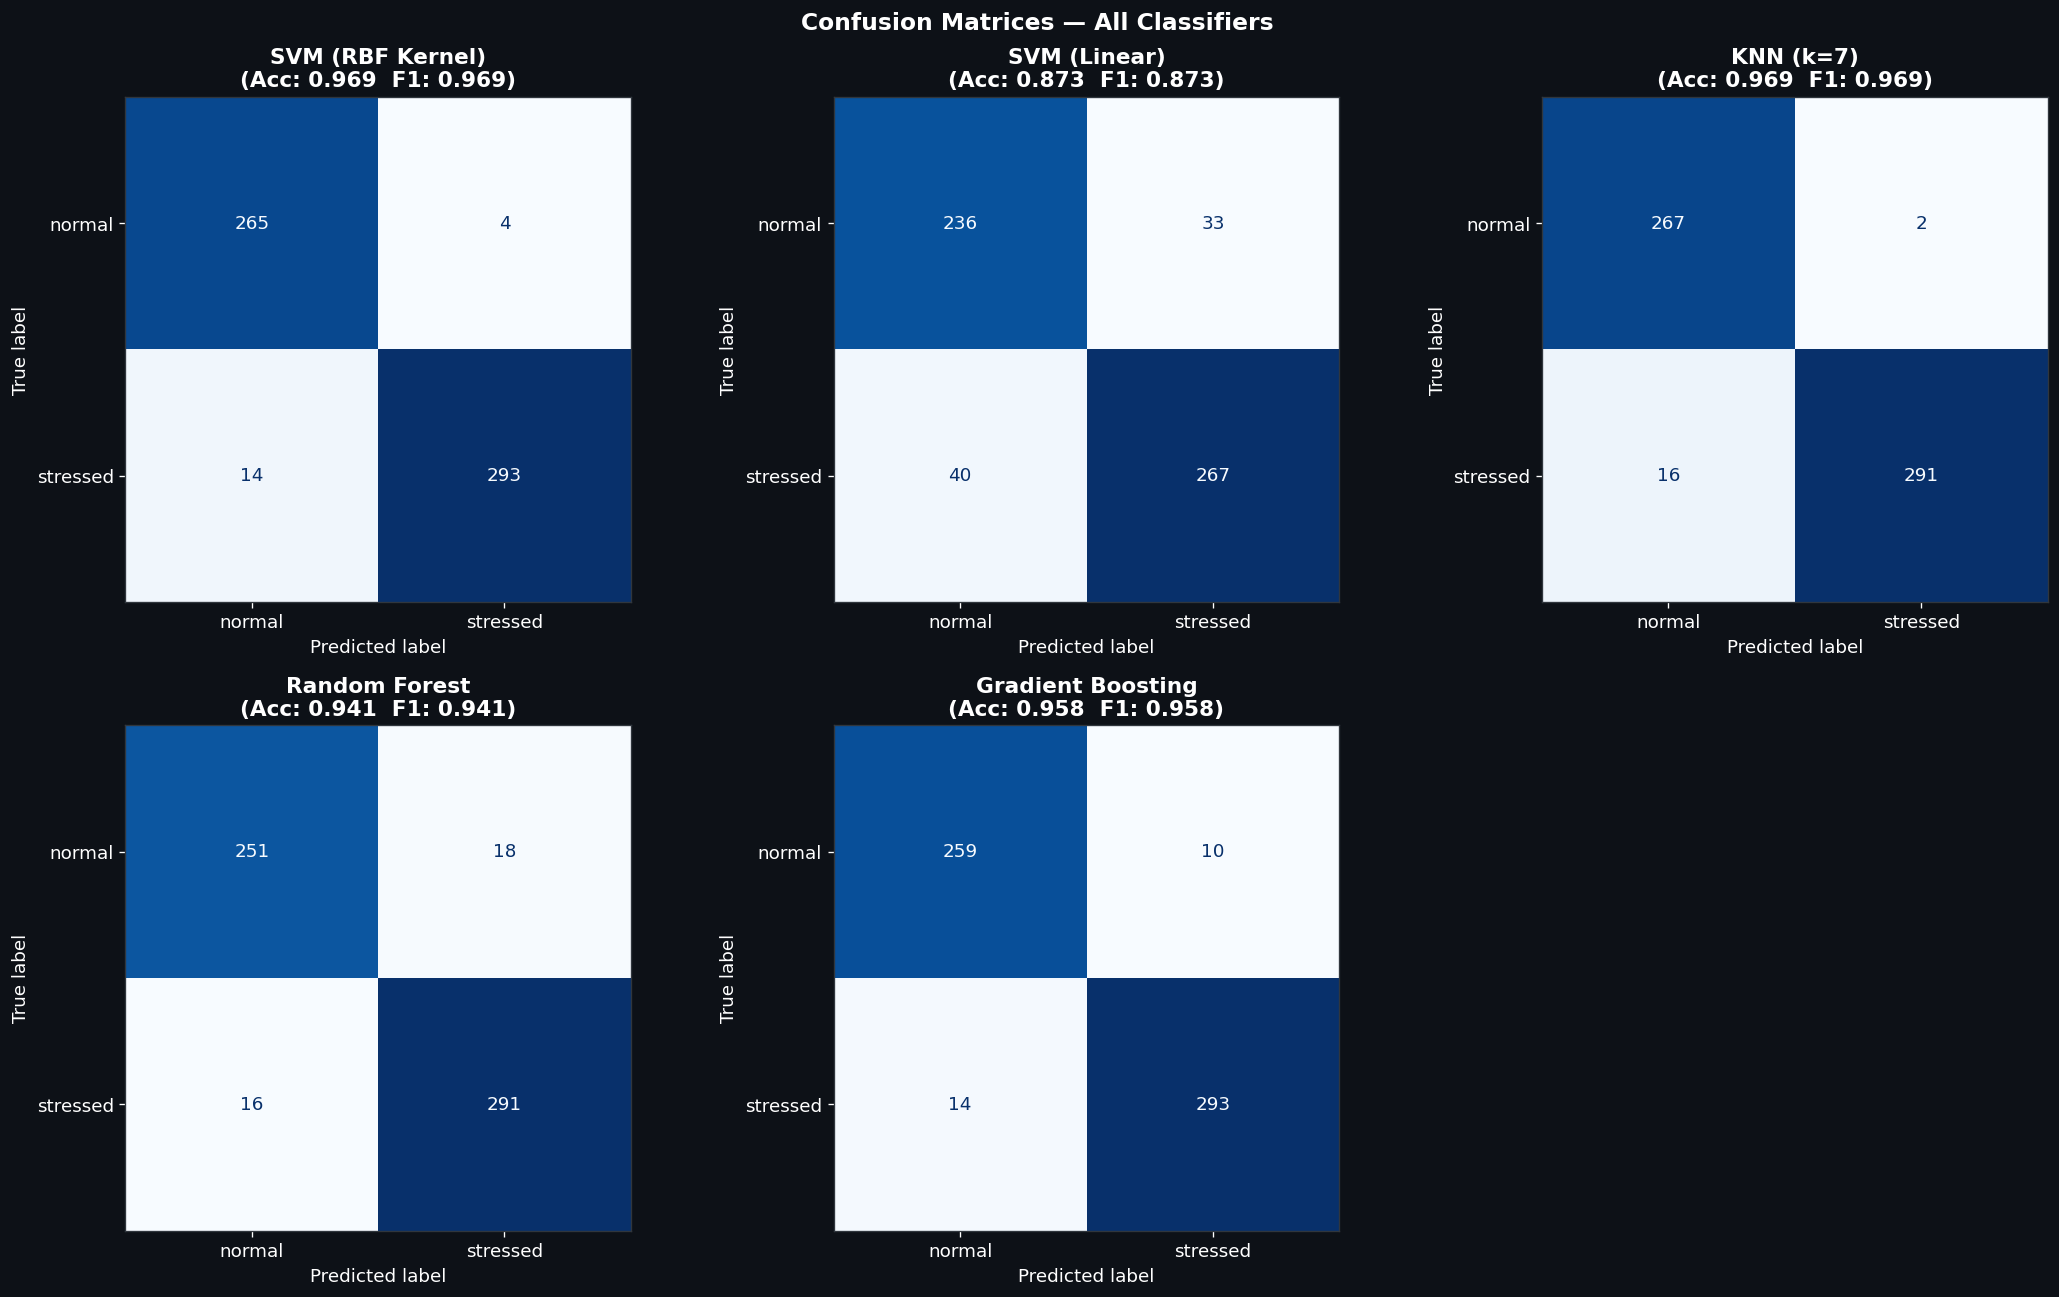

In [25]:
class_names = le.classes_

fig, axes = plt.subplots(2, 3, figsize=(18, 11))
axes = axes.flatten()

for i, (name, res) in enumerate(results.items()):
    cm   = confusion_matrix(y_test, res['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'{name}\n(Acc: {res["Test Accuracy"]:.3f}  F1: {res["F1 Score"]:.3f})', fontweight='bold')

for j in range(len(results), 6):
    axes[j].set_visible(False)

fig.suptitle('Confusion Matrices — All Classifiers', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('confusion_matrices.png', bbox_inches='tight')
plt.show()

## 📉 Cell 19b — ROC Curve (Best SVM Model)

Fitting SVM with probability=True for ROC curve...


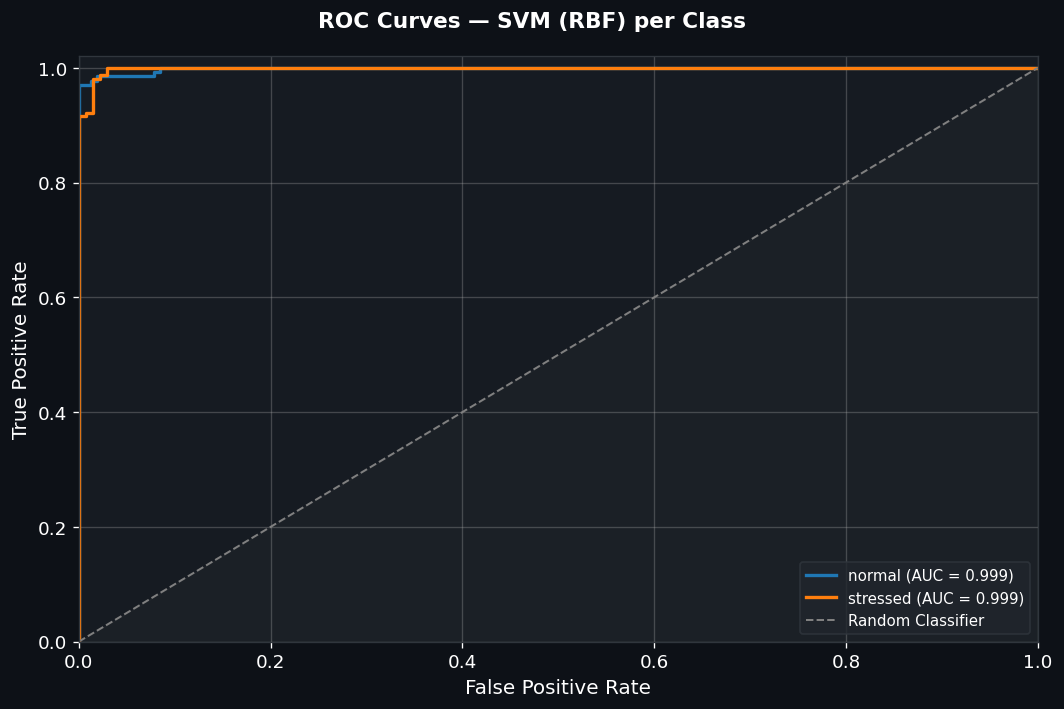

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve, StratifiedKFold
import numpy as np

# ── ROC Curve for best model (re-train SVM with probability=True) ─────────────
print("Fitting SVM with probability=True for ROC curve...")
svm_prob = SVC(kernel='rbf', C=5, gamma='scale', probability=True, random_state=42)
svm_prob.fit(X_train, y_train)
y_pred_prob = svm_prob.predict_proba(X_test)

# ROC for each class (one-vs-rest)
fig, ax = plt.subplots(figsize=(9, 6))
fig.suptitle('ROC Curves — SVM (RBF) per Class', fontsize=13, fontweight='bold')

class_names_list = list(le.classes_)
for i, cls_name in enumerate(class_names_list):
    y_bin = (y_test == i).astype(int)
    if y_bin.sum() == 0:
        continue
    fpr, tpr, _ = roc_curve(y_bin, y_pred_prob[:, i])
    roc_auc      = auc(fpr, tpr)
    ax.plot(fpr, tpr, linewidth=2, label=f'{cls_name} (AUC = {roc_auc:.3f})')

ax.plot([0,1],[0,1], color='gray', linewidth=1.2, linestyle='--', label='Random Classifier')
ax.fill_between([0,1],[0,1], alpha=0.05, color='gray')
ax.set_xlim([0.0, 1.0]); ax.set_ylim([0.0, 1.02])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(loc='lower right', fontsize=9); ax.grid(alpha=0.3)
plt.tight_layout(); plt.show()


## 📊 Cell 19c — Evaluation Metrics Bar Chart & Learning Curves

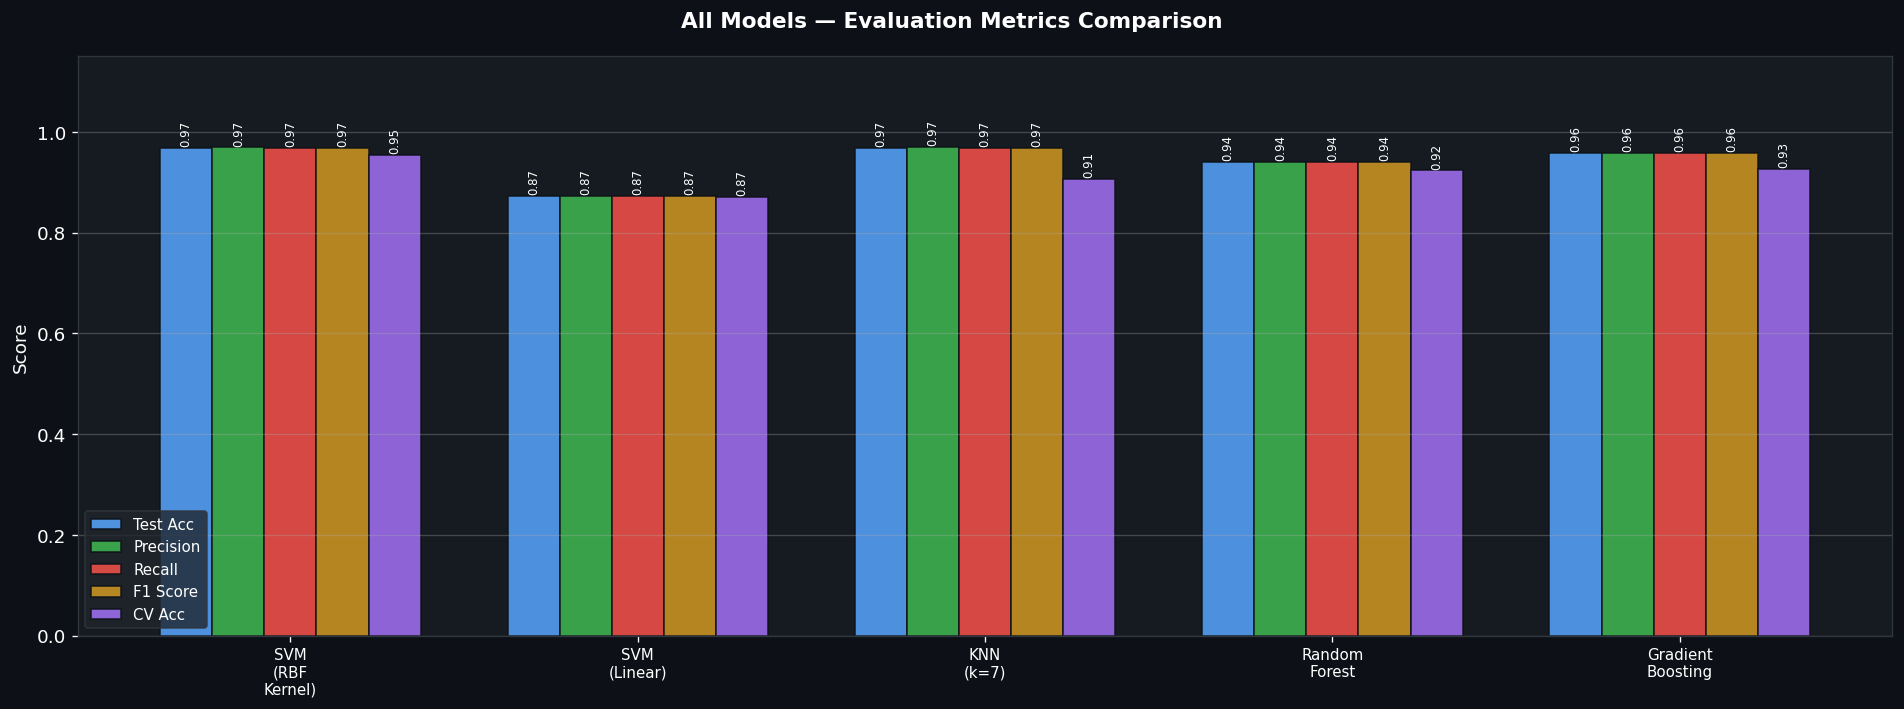


Generating learning curve for best model: SVM (RBF Kernel)...


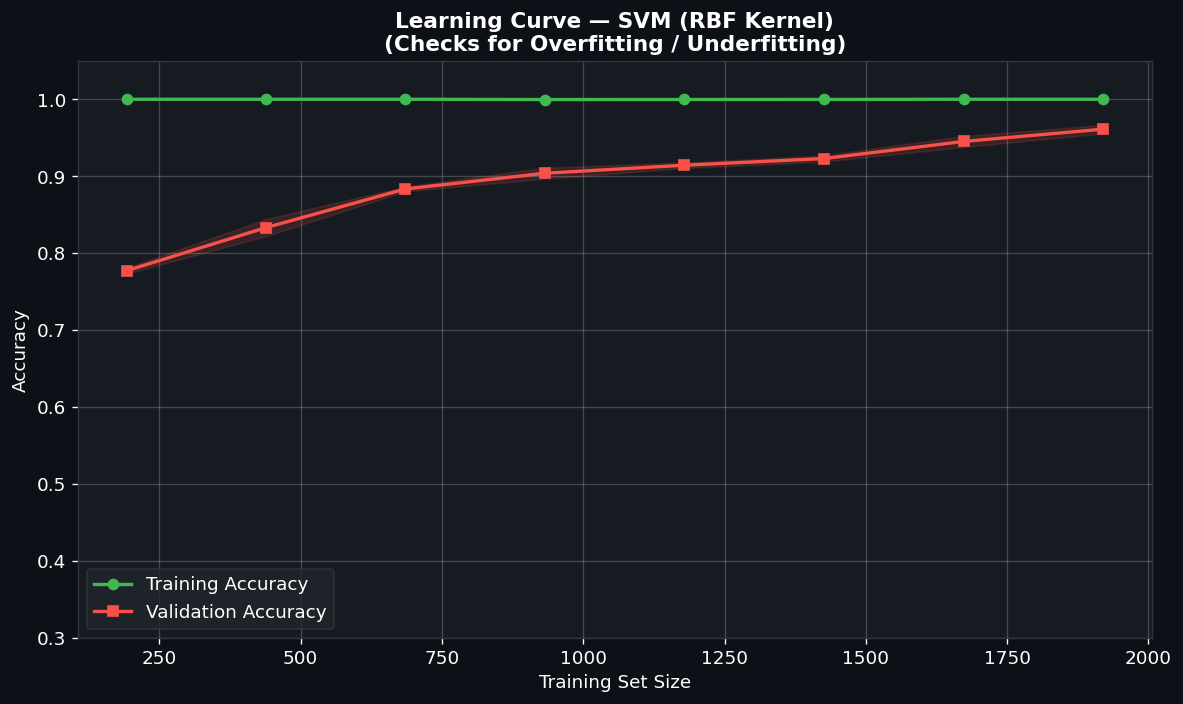

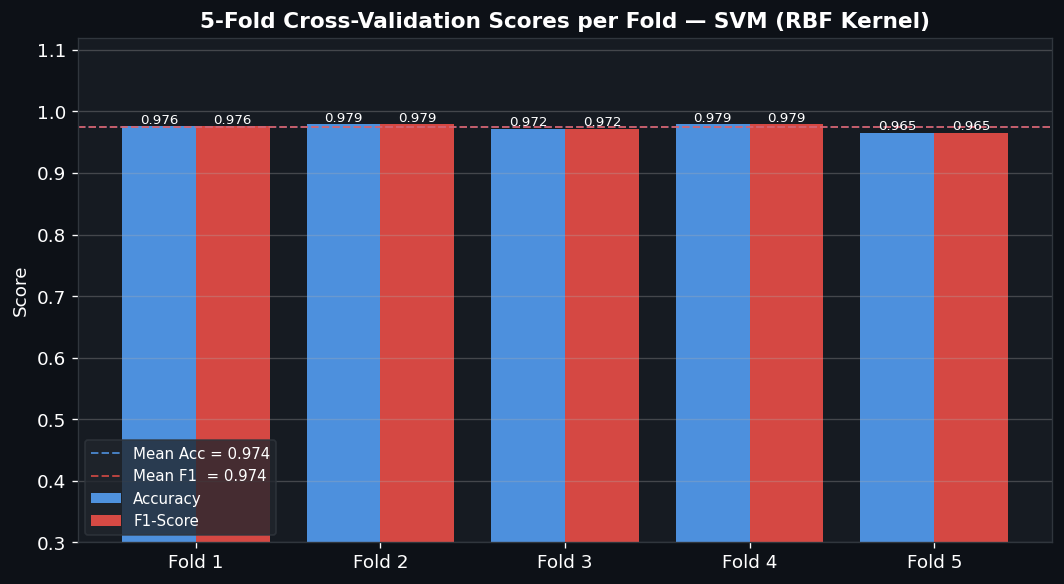


CV Accuracy (5-fold): 0.9743 ± 0.0052
CV F1-Score (5-fold): 0.9743 ± 0.0052


In [27]:
# ── Metrics Bar Chart (all models) ───────────────────────────────────────────
model_list   = list(results.keys())
metric_keys  = ['Test Accuracy', 'Precision', 'Recall', 'F1 Score', 'CV Accuracy']
metric_labels= ['Test Acc', 'Precision', 'Recall', 'F1 Score', 'CV Acc']

x = np.arange(len(model_list))
width = 0.15
colors_bar = ['#58a6ff', '#3fb950', '#f85149', '#d29922', '#a371f7']

fig, ax = plt.subplots(figsize=(16, 6))
fig.suptitle('All Models — Evaluation Metrics Comparison', fontsize=13, fontweight='bold')

for j, (mkey, mlabel, color) in enumerate(zip(metric_keys, metric_labels, colors_bar)):
    vals = [results[m][mkey] for m in model_list]
    bars = ax.bar(x + j*width, vals, width, label=mlabel, color=color, alpha=0.85, edgecolor='#0d1117')
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003,
                f'{val:.2f}', ha='center', va='bottom', fontsize=7, rotation=90)

ax.set_xticks(x + width*2)
ax.set_xticklabels([m.replace(' ', '\n') for m in model_list], fontsize=9)
ax.set_ylim([0, 1.15]); ax.set_ylabel('Score')
ax.legend(fontsize=9); ax.grid(axis='y', alpha=0.3)
plt.tight_layout(); plt.show()

# ── Learning Curve for best model ────────────────────────────────────────────
from sklearn.base import clone
print(f"\nGenerating learning curve for best model: {best_model_name}...")

best_clf_clone = clone(results[best_model_name]['clf'])
pipe_lc = Pipeline([('scaler', StandardScaler()), ('clf', best_clf_clone)])

train_sizes, train_scores, val_scores = learning_curve(
    pipe_lc, X_clean, le.transform(df_features['stress_label']),
    cv          = StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring     = 'accuracy',
    train_sizes = np.linspace(0.1, 1.0, 8),
    n_jobs      = -1
)

train_mean = train_scores.mean(axis=1); train_std = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1);   val_std   = val_scores.std(axis=1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_sizes, train_mean, 'o-', color='#3fb950', linewidth=2, markersize=6, label='Training Accuracy')
ax.plot(train_sizes, val_mean,   's-', color='#f85149', linewidth=2, markersize=6, label='Validation Accuracy')
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='#3fb950')
ax.fill_between(train_sizes, val_mean - val_std,     val_mean + val_std,     alpha=0.15, color='#f85149')
ax.set_title(f'Learning Curve — {best_model_name}\n(Checks for Overfitting / Underfitting)',
             fontsize=13, fontweight='bold')
ax.set_xlabel('Training Set Size'); ax.set_ylabel('Accuracy')
ax.legend(fontsize=11); ax.grid(alpha=0.3); ax.set_ylim([0.3, 1.05])
plt.tight_layout(); plt.show()

# ── CV Scores per Fold (best model) ──────────────────────────────────────────
cv_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_all  = le.transform(df_features['stress_label'])
pipe_cv = Pipeline([('scaler', StandardScaler()), ('clf', clone(results[best_model_name]['clf']))])

cv_acc_folds = cross_val_score(pipe_cv, X_clean, y_all, cv=cv_skf, scoring='accuracy', n_jobs=-1)
cv_f1_folds  = cross_val_score(pipe_cv, X_clean, y_all, cv=cv_skf, scoring='f1_weighted', n_jobs=-1)

fig, ax = plt.subplots(figsize=(9, 5))
folds = [f'Fold {i+1}' for i in range(5)]
xf    = np.arange(5)
ax.bar(xf - 0.2, cv_acc_folds, 0.4, label='Accuracy', color='#58a6ff', alpha=0.85)
ax.bar(xf + 0.2, cv_f1_folds,  0.4, label='F1-Score', color='#f85149', alpha=0.85)
for i, (a, f) in enumerate(zip(cv_acc_folds, cv_f1_folds)):
    ax.text(i - 0.2, a + 0.005, f'{a:.3f}', ha='center', fontsize=8)
    ax.text(i + 0.2, f + 0.005, f'{f:.3f}', ha='center', fontsize=8)
ax.set_xticks(xf); ax.set_xticklabels(folds)
ax.set_ylim([0.3, 1.12])
ax.axhline(cv_acc_folds.mean(), color='#58a6ff', linestyle='--', linewidth=1.2, alpha=0.7,
           label=f'Mean Acc = {cv_acc_folds.mean():.3f}')
ax.axhline(cv_f1_folds.mean(),  color='#f85149', linestyle='--', linewidth=1.2, alpha=0.7,
           label=f'Mean F1  = {cv_f1_folds.mean():.3f}')
ax.set_title(f'5-Fold Cross-Validation Scores per Fold — {best_model_name}',
             fontsize=13, fontweight='bold')
ax.set_ylabel('Score'); ax.legend(fontsize=9); ax.grid(axis='y', alpha=0.3)
plt.tight_layout(); plt.show()

print(f"\nCV Accuracy (5-fold): {cv_acc_folds.mean():.4f} ± {cv_acc_folds.std():.4f}")
print(f"CV F1-Score (5-fold): {cv_f1_folds.mean():.4f} ± {cv_f1_folds.std():.4f}")


In [28]:
best_res = results[best_model_name]

# Retrieve or re-calculate missing metrics
train_acc_best_model = accuracy_score(y_train, best_res['clf'].predict(X_train))
cv_scores_best_model = cross_val_score(best_res['clf'], X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
cv_std_best_model    = cv_scores_best_model.std()

print('=' * 60)
print(f'  BEST MODEL: {best_model_name}')
print('=' * 60)
print(classification_report(y_test, best_res['y_pred'], target_names=class_names))
print(f"  5-Fold CV : {best_res['CV Accuracy']:.4f} +/- {cv_std_best_model:.4f}")
print(f"  Train Acc : {train_acc_best_model:.4f}")
print(f"  Overfit   : {train_acc_best_model - best_res['Test Accuracy']:.4f}")
print('=' * 60)

  BEST MODEL: SVM (RBF Kernel)
              precision    recall  f1-score   support

      normal       0.95      0.99      0.97       269
    stressed       0.99      0.95      0.97       307

    accuracy                           0.97       576
   macro avg       0.97      0.97      0.97       576
weighted avg       0.97      0.97      0.97       576

  5-Fold CV : 0.9549 +/- 0.0118
  Train Acc : 1.0000
  Overfit   : 0.0312


## 📋 Cell 20 — Detailed Classification Report (Best Model)

In [29]:
best_res = results[best_model_name]

# Retrieve or re-calculate missing metrics
train_acc_best_model = accuracy_score(y_train, best_res['clf'].predict(X_train))
cv_scores_best_model = cross_val_score(best_res['clf'], X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
cv_std_best_model    = cv_scores_best_model.std()

print('=' * 60)
print(f'  BEST MODEL: {best_model_name}')
print('=' * 60)
print(classification_report(y_test, best_res['y_pred'], target_names=class_names))
print(f"  5-Fold CV : {best_res['CV Accuracy']:.4f} +/- {cv_std_best_model:.4f}")
print(f"  Train Acc : {train_acc_best_model:.4f}")
print(f"  Overfit   : {train_acc_best_model - best_res['Test Accuracy']:.4f}")
print('=' * 60)

  BEST MODEL: SVM (RBF Kernel)
              precision    recall  f1-score   support

      normal       0.95      0.99      0.97       269
    stressed       0.99      0.95      0.97       307

    accuracy                           0.97       576
   macro avg       0.97      0.97      0.97       576
weighted avg       0.97      0.97      0.97       576

  5-Fold CV : 0.9549 +/- 0.0118
  Train Acc : 1.0000
  Overfit   : 0.0312


## 🌲 Cell 21 — Feature Importances (Random Forest)

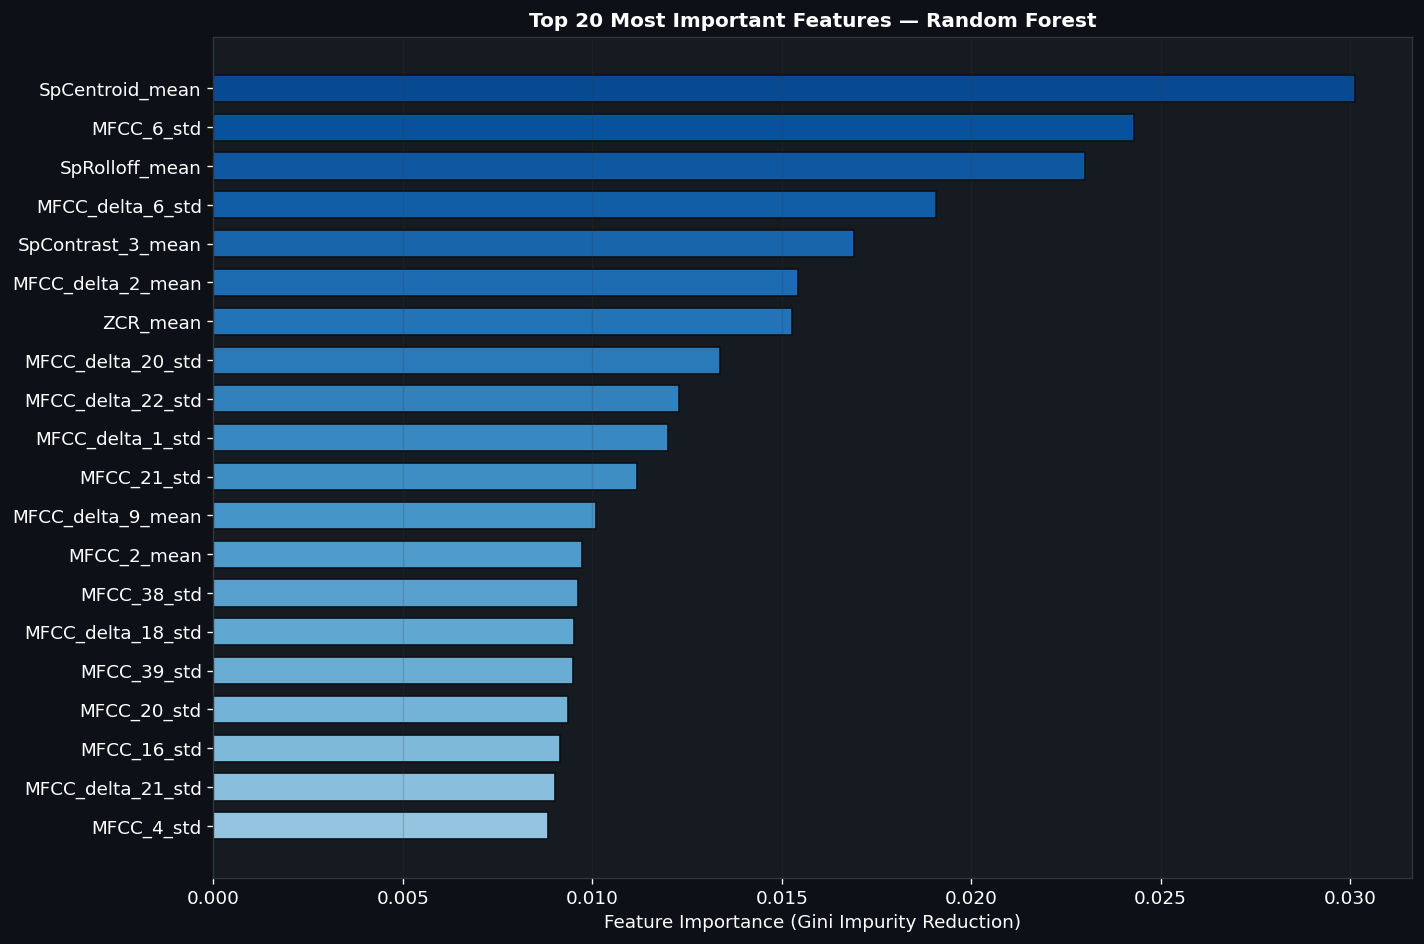


Top 10 Most Important Features:
   1. SpCentroid_mean                          : 0.03014
   2. MFCC_6_std                               : 0.02429
   3. SpRolloff_mean                           : 0.02301
   4. MFCC_delta_6_std                         : 0.01906
   5. SpContrast_3_mean                        : 0.01692
   6. MFCC_delta_2_mean                        : 0.01544
   7. ZCR_mean                                 : 0.01527
   8. MFCC_delta_20_std                        : 0.01337
   9. MFCC_delta_22_std                        : 0.01229
  10. MFCC_delta_1_std                         : 0.01199


In [30]:
rf_clf      = results['Random Forest']['clf']
importances = rf_clf.feature_importances_
feat_labels = feat_names[:n_feats]

feat_importance_df = pd.DataFrame({
    'feature': feat_labels, 'importance': importances
}).sort_values('importance', ascending=False)

top20 = feat_importance_df.head(20)
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(top20['feature'], top20['importance'],
        color=plt.cm.Blues(np.linspace(0.9, 0.4, 20)), edgecolor='#0d1117', height=0.7)
ax.set_xlabel('Feature Importance (Gini Impurity Reduction)', fontsize=11)
ax.set_title('Top 20 Most Important Features — Random Forest', fontweight='bold', fontsize=12)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.2, color='#30363d')
plt.tight_layout()
plt.savefig('feature_importances.png', bbox_inches='tight')
plt.show()

print("\nTop 10 Most Important Features:")
for rank, (_, row) in enumerate(feat_importance_df.head(10).iterrows(), 1):
    print(f"  {rank:2d}. {row['feature']:<40} : {row['importance']:.5f}")

## 📈 Cell 22 — Time-Series Variance & Seasonality Analysis

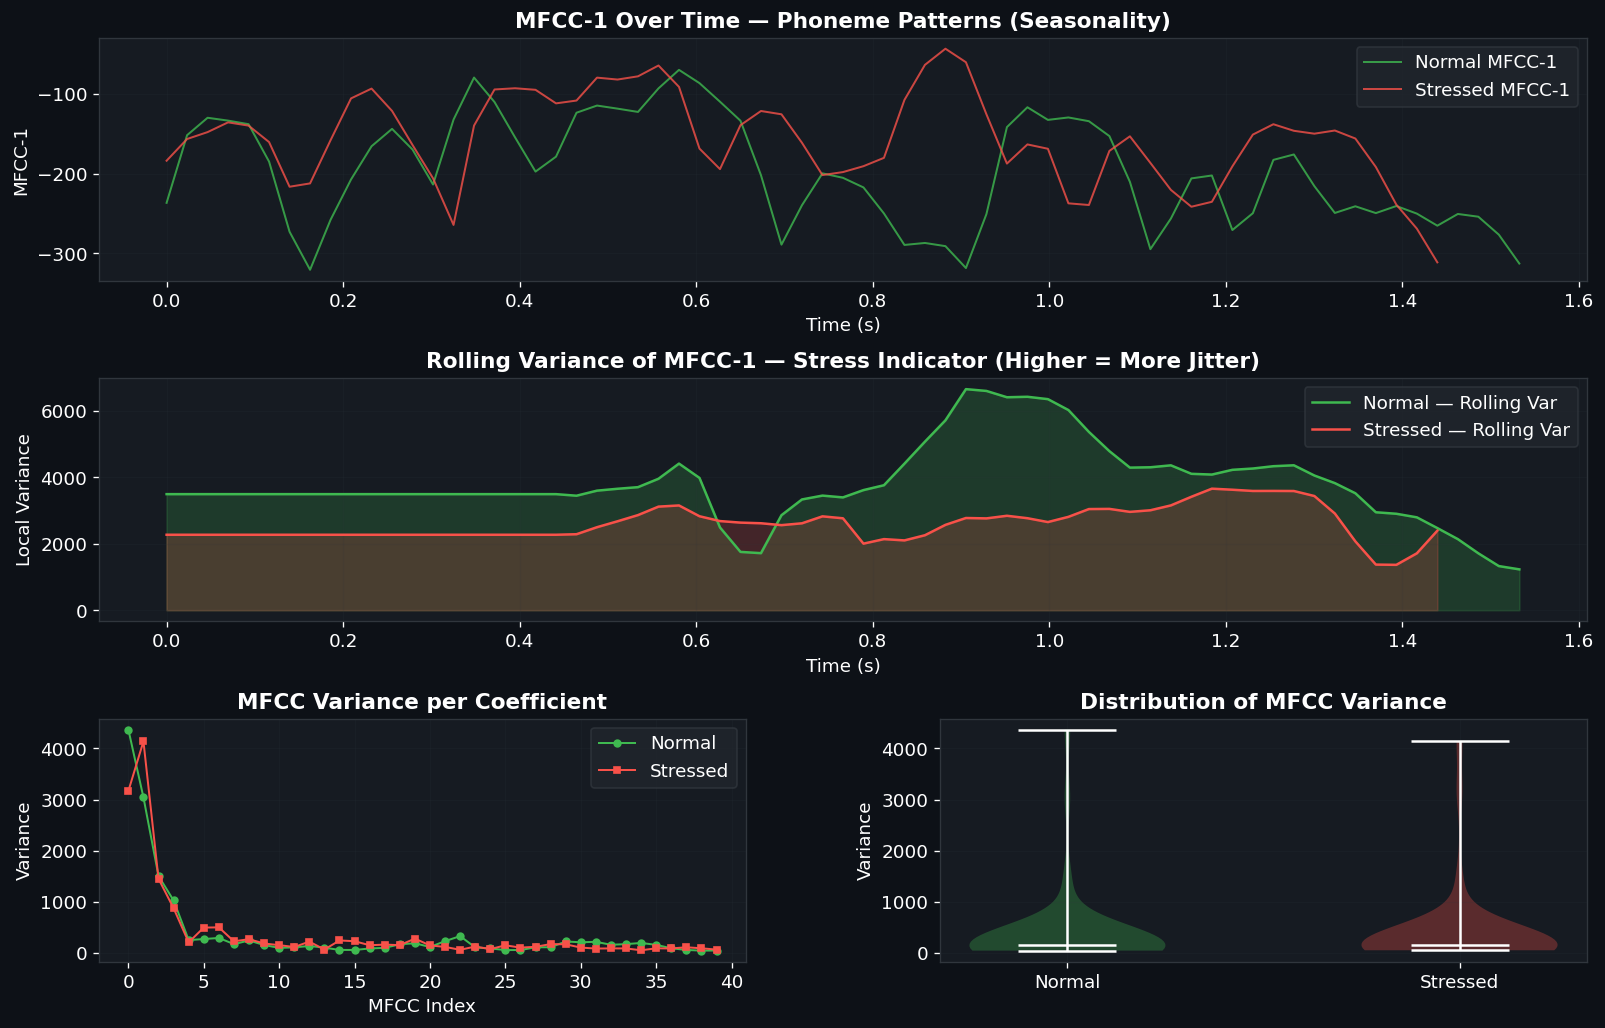

Normal   — MFCC variance mean : 378.361
Stressed — MFCC variance mean : 382.657
Ratio (Stressed/Normal)       : 1.01x


In [31]:
mfcc1_n = mfcc_normal[0]
mfcc1_s = mfcc_stressed[0]
roll_var_n = pd.Series(mfcc1_n).rolling(20).var().bfill()
roll_var_s = pd.Series(mfcc1_s).rolling(20).var().bfill()

fig = plt.figure(figsize=(16, 10))
gs  = gridspec.GridSpec(3, 2, figure=fig, hspace=0.4, wspace=0.3)

t_n = librosa.frames_to_time(np.arange(len(mfcc1_n)), sr=SR, hop_length=HOP_LENGTH)
t_s = librosa.frames_to_time(np.arange(len(mfcc1_s)), sr=SR, hop_length=HOP_LENGTH)

ax1 = fig.add_subplot(gs[0, :])
ax1.plot(t_n, mfcc1_n, color='#3fb950', linewidth=1.2, label='Normal MFCC-1',   alpha=0.8)
ax1.plot(t_s, mfcc1_s, color='#f85149', linewidth=1.2, label='Stressed MFCC-1', alpha=0.8)
ax1.set_title('MFCC-1 Over Time — Phoneme Patterns (Seasonality)', fontweight='bold')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('MFCC-1')
ax1.legend()
ax1.grid(alpha=0.15, color='#30363d')

ax2 = fig.add_subplot(gs[1, :])
ax2.plot(t_n[:len(roll_var_n)], roll_var_n.values, color='#3fb950', linewidth=1.5, label='Normal — Rolling Var')
ax2.plot(t_s[:len(roll_var_s)], roll_var_s.values, color='#f85149', linewidth=1.5, label='Stressed — Rolling Var')
ax2.fill_between(t_n[:len(roll_var_n)], roll_var_n.values, alpha=0.2, color='#3fb950')
ax2.fill_between(t_s[:len(roll_var_s)], roll_var_s.values, alpha=0.2, color='#f85149')
ax2.set_title('Rolling Variance of MFCC-1 — Stress Indicator (Higher = More Jitter)', fontweight='bold')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Local Variance')
ax2.legend()
ax2.grid(alpha=0.15, color='#30363d')

mfcc_var_n = mfcc_normal.var(axis=1)
mfcc_var_s = mfcc_stressed.var(axis=1)

ax3 = fig.add_subplot(gs[2, 0])
ax3.plot(mfcc_var_n, 'o-', color='#3fb950', label='Normal',   markersize=4, linewidth=1.2)
ax3.plot(mfcc_var_s, 's-', color='#f85149', label='Stressed', markersize=4, linewidth=1.2)
ax3.set_title('MFCC Variance per Coefficient', fontweight='bold')
ax3.set_xlabel('MFCC Index')
ax3.set_ylabel('Variance')
ax3.legend()
ax3.grid(alpha=0.15, color='#30363d')

ax4 = fig.add_subplot(gs[2, 1])
vp = ax4.violinplot([mfcc_var_n, mfcc_var_s], positions=[1, 2], showmedians=True)
vp['bodies'][0].set_facecolor('#3fb950')
vp['bodies'][1].set_facecolor('#f85149')
for part in ('cbars','cmins','cmaxes','cmedians'):
    vp[part].set_edgecolor('white')
ax4.set_xticks([1, 2])
ax4.set_xticklabels(['Normal', 'Stressed'])
ax4.set_title('Distribution of MFCC Variance', fontweight='bold')
ax4.set_ylabel('Variance')
ax4.grid(alpha=0.15, color='#30363d')

plt.savefig('timeseries_analysis.png', bbox_inches='tight')
plt.show()
print(f"Normal   — MFCC variance mean : {mfcc_var_n.mean():.3f}")
print(f"Stressed — MFCC variance mean : {mfcc_var_s.mean():.3f}")
print(f"Ratio (Stressed/Normal)       : {mfcc_var_s.mean()/mfcc_var_n.mean():.2f}x")

## 🔮 Cell 23 — Final Summary Dashboard

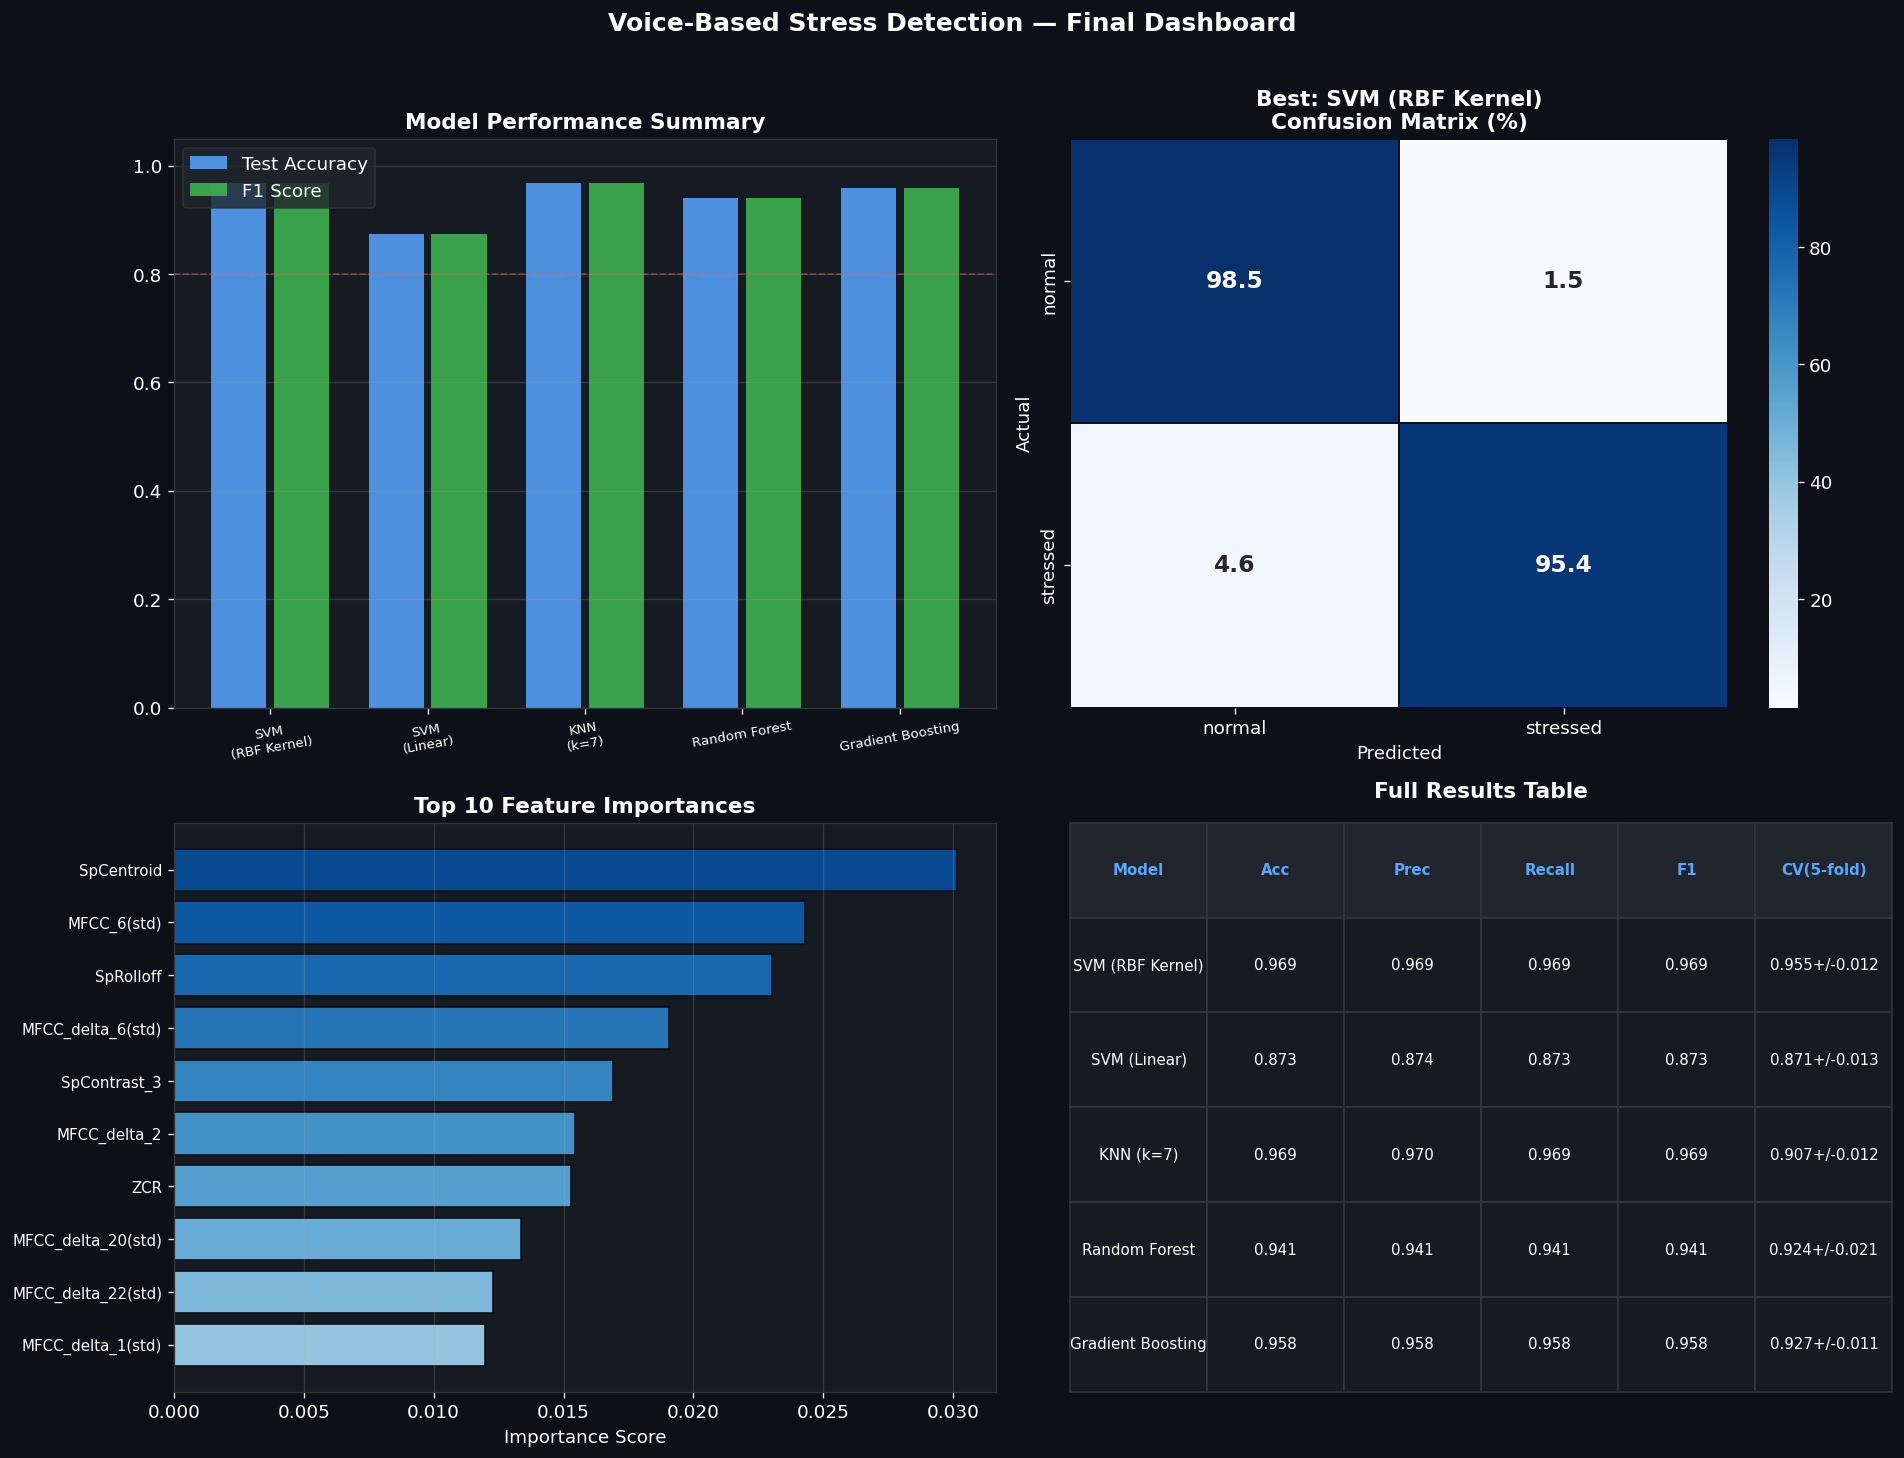

Final dashboard saved.


In [32]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy comparison
ax1 = axes[0, 0]
names = list(results.keys())
accs  = [results[n]['Test Accuracy'] for n in names] # Corrected key
f1s   = [results[n]['F1 Score']       for n in names] # Corrected key
x_pos = np.arange(len(names))
ax1.bar(x_pos - 0.2, accs, 0.35, label='Test Accuracy', color='#58a6ff', alpha=0.85)
ax1.bar(x_pos + 0.2, f1s,  0.35, label='F1 Score',      color='#3fb950', alpha=0.85)
ax1.set_title('Model Performance Summary', fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([n.replace(' (', '\n(') for n in names], fontsize=8, rotation=10)
ax1.set_ylim([0, 1.05])
ax1.legend()
ax1.axhline(y=0.8, color='#f85149', linestyle='--', linewidth=1, alpha=0.5)
ax1.grid(axis='y', alpha=0.2)

# 2. Best model confusion matrix %
ax2 = axes[0, 1]
cm_best = confusion_matrix(y_test, results[best_model_name]['y_pred'])
cm_pct  = cm_best.astype(float) / cm_best.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='Blues', ax=ax2,
            xticklabels=class_names, yticklabels=class_names,
            linewidths=1, linecolor='#0d1117', annot_kws={'size': 14, 'weight': 'bold'})
ax2.set_title(f'Best: {best_model_name}\nConfusion Matrix (%)', fontweight='bold')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

# 3. Feature importances top 10
ax3 = axes[1, 0]
top10_feat = feat_importance_df.head(10)
ax3.barh(range(10), top10_feat['importance'],
         color=plt.cm.Blues(np.linspace(0.9, 0.4, 10)), edgecolor='#0d1117')
ax3.set_yticks(range(10))
ax3.set_yticklabels([f.replace('_mean','').replace('_std','(std)') for f in top10_feat['feature']], fontsize=9)
ax3.invert_yaxis()
ax3.set_title('Top 10 Feature Importances', fontweight='bold')
ax3.set_xlabel('Importance Score')
ax3.grid(axis='x', alpha=0.2)

# 4. Results table
ax4 = axes[1, 1]
ax4.axis('off')
table_data = [[name, f"{res['Test Accuracy']:.3f}", f"{res['Precision']:.3f}", # Corrected keys
               f"{res['Recall']:.3f}", f"{res['F1 Score']:.3f}", # Corrected keys
               f"{res['CV Accuracy']:.3f}+/-{res['CV Std']:.3f}"] # Corrected keys
              for name, res in results.items()]
table = ax4.table(
    cellText=table_data,
    colLabels=['Model','Acc','Prec','Recall','F1','CV(5-fold)'],
    cellLoc='center', loc='center', bbox=[0, 0, 1, 1]
)
table.auto_set_font_size(False)
table.set_fontsize(9)
for key, cell in table.get_celld().items():
    cell.set_facecolor('#161b22')
    cell.set_edgecolor('#30363d')
    cell.set_text_props(color='white')
    if key[0] == 0:
        cell.set_facecolor('#21262d')
        cell.set_text_props(color='#58a6ff', fontweight='bold')
ax4.set_title('Full Results Table', fontweight='bold', pad=15)

fig.suptitle('Voice-Based Stress Detection — Final Dashboard', fontweight='bold', fontsize=15, y=1.01)
plt.tight_layout()
plt.savefig('final_dashboard.png', bbox_inches='tight', dpi=150)
plt.show()
print("Final dashboard saved.")

## 📝 Cell 24 — Full Project Summary Report

In [33]:
best = results[best_model_name]

# Retrieve or re-calculate missing metrics
train_acc_best_model = accuracy_score(y_train, best['clf'].predict(X_train))
cv_std_best_model = best['CV Std'] # Now stored in results dictionary

print(f"""
{'='*70}
  VOICE-BASED STRESS DETECTION — COMPLETE PROJECT SUMMARY
{'='*70}
  Dataset      : RAVDESS Emotional Speech Audio (Kaggle)
  Total Files  : {len(df_meta)} audio samples (.wav, 22050 Hz)
  Classes      : normal / stressed (binary classification)
{'='*70}
  PREPROCESSING
  - Silence trimming (top_db=20), amplitude normalization
  - Hanning window framing: frame_length=2048, hop_length=512

  FEATURES ({n_feats} per sample)
  - MFCC 40 coeff mean+std      : 80
  - MFCC Delta mean+std         : 80
  - Zero Crossing Rate          : 2
  - Spectral Centroid           : 2
  - Spectral Rolloff            : 2
  - Spectral Bandwidth          : 2
  - Spectral Contrast (7 bands) : 14
  - RMS Energy                  : 2
  - Pitch F0 mean+std+var       : 3
{'='*70}
  BEST MODEL   : {best_model_name}
  Test Accuracy: {best['Test Accuracy']:.4f}
  Precision    : {best['Precision']:.4f}
  Recall       : {best['Recall']:.4f}
  F1 Score     : {best['F1 Score']:.4f}
  CV (5-fold)  : {best['CV Accuracy']:.4f} +/- {cv_std_best_model:.4f}
{'='*70}
  PLOTS SAVED: dataset_distribution, waveforms, framing_windowing,
  spectrograms, mel_spectrograms, mfcc_heatmap, mfcc_trajectories,
  pitch_contours, feature_comparison, correlation_heatmap,
  model_comparison, confusion_matrices, feature_importances,
  timeseries_analysis, final_dashboard
{'='*70}
""")


  VOICE-BASED STRESS DETECTION — COMPLETE PROJECT SUMMARY
  Dataset      : RAVDESS Emotional Speech Audio (Kaggle)
  Total Files  : 2880 audio samples (.wav, 22050 Hz)
  Classes      : normal / stressed (binary classification)
  PREPROCESSING
  - Silence trimming (top_db=20), amplitude normalization
  - Hanning window framing: frame_length=2048, hop_length=512

  FEATURES (187 per sample)
  - MFCC 40 coeff mean+std      : 80
  - MFCC Delta mean+std         : 80
  - Zero Crossing Rate          : 2
  - Spectral Centroid           : 2
  - Spectral Rolloff            : 2
  - Spectral Bandwidth          : 2
  - Spectral Contrast (7 bands) : 14
  - RMS Energy                  : 2
  - Pitch F0 mean+std+var       : 3
  BEST MODEL   : SVM (RBF Kernel)
  Test Accuracy: 0.9688
  Precision    : 0.9694
  Recall       : 0.9688
  F1 Score     : 0.9688
  CV (5-fold)  : 0.9549 +/- 0.0118
  PLOTS SAVED: dataset_distribution, waveforms, framing_windowing,
  spectrograms, mel_spectrograms, mfcc_heatmap, 